# A Rigorous Machine Learning Pipeline (Supervised Binary Classification):
* Author: Ryan Urbanowicz, PhD 
*  Affiliation: University of Pennsylvania - Department of Biostatistics, Epidemiology, and Informatics & Institute for Biomedical Informatics (IBI) 
* Date: 1/25/20
* Requirements: Anaconda (with Python 3), skrebate
    - Install most recent version of anaconda
    - [pip install skrebate]
    - [pip install xgboost]
    - [pip install lightgbm]
    - [pip install optuna]
    - [pip install -U plotly>=4.0.0]
    - [conda install -c plotly plotly-orca]

***
## Introduction
This notebook presents an example of a 'rigorous' machine learning (ML) analysis pipeline that could be reasonablly applied to various supervised learning classification tasks. This pipeline was developed with biomedical data mining/modeling in mind. The notebook is set up with the following assumptions:
- The user is starting from a single binary class dataset with a column for class labels (0 for major class, 1 for minor class), some number of potentially predictive feature/variables as columns, and (optionaly) a column providing instance id's and potentially other columns that should be excluded from analysis
- The user realizes that any unique dataset may require its own unique data cleaning, feature transformation, or feature engineering in order to maximize ML performance
- This pipeline is not necesarily ideal for all datasets, however it offers a rigorous starting point for analysis.
- Target dataset is saved in the working directory contiaining this notebook
- Target dataset is a .txt file (however notebook code may be modified to work with other file types)
- User knows the column names corresponding to all features to include in analysis as well as the column name corresponding to the outcome/endpoint/class to be included 
- All variables in the dataset have been numerically encoded (otherwise additional data preprocessing may be needed)

## Notebook Organization
#### Part 1: Exploratory analysis, data cleaning, and creating n-fold CV partitioned datasets 
- Instances missing a class value are excluded
- The user can indicate other columns that should be excluded from the analysis
- The user can turn on/off the option to apply standard scaling to the data prior to CV partitioning or imputation
    - We use no scaling by default. This is because most methods should work properly without it, and in applying the model downstream, it is difficult to properly scale new data so that models may be re-applied later.
    - ANN modeling is sensitive to feature scaling, thus without it, performance not be as good. However this is only one of many challenges in getting ANN to perform well. 
- The user can turn on/off the option to impute missing values following CV partitioning
- The user can turn on/off the option for the code to automatically attempt to discriminate nominal from ordinal features
- The user can choose the number of CV partitions as well as the strategy for CV partitioning (i.e.  random (R), stratified (S), and matched (M) 
- CV training and testing datasets are saved as .txt files so that the same partitions may be analyzed external to this code
    
#### Part 2: Feature selection
- The user can turn on/off the option to filter out the lowest scoring features in the data (i.e. to conduct not just feature importance evaluation but feature selection)
- Feature importance evaluation and feature selection are conducted within each respective CV training partition
- The pipeline reports feature importance estimates via two feature selection algorithms:
    - Mutual Information: Proficient at detecting univariate associations
    - MultiSURF: Proficient at detecting univariate associations, 2-way epistatic interactions, and heterogeneous associations
    
- When selected by the user, feature selection conservatively keeps any feature identified as 'potentially relevant' (i.e. score > 0) by either algorithm
- Since MultiSURF scales quadratically with the number of training instances, there is an option to utilize a random subset of instances when running this algorithm to save computational time
    
#### Part 3: Machine learning modeling
- Seven ML modeling algorithms have been implemented in this pipeline:
    - Logistic Regression (scikit learn)
    - Decision Tree (scikit learn)
    - Random Forest (scikit learn)
    - Naïve Bayes (scikit learn)
    - XGBoost (separate python package)
    - LightGBM (separate python package)
    - SVM (scikit learn)
    - ANN (scikit learn)
    - ExSTraCS (v2.0.2.1) - a Learning Classifier System (LCS) algorithm manually configured to run in this notebook
- User can select any subset of these methods to run
- ML modeling is conducted within each respective CV training partition on the respective feature subset selected within the given CV partition
- ML modeling begins with a hyperparameter sweep conducted with a grid search of hard coded run parameter options (user can edit as needed)
- Balanced accuracy is applied as the evaluation metric for the hyperparameter sweep

#### Part 4: ML feature importance vizualization

***
## Schematic of ML Analysis Pipeline

<img src="ML pipeline schematic.png" />

---
# Import Necessary Python Packages 

In [1]:
import pandas as pd
import numpy as np
import os
import random
import copy
import sys
import pickle
import time

from data_processing_methods import cv_partitioner
from data_processing_methods import identifyCategoricalFeatures
from data_processing_methods import imputeCVData
from data_processing_methods import dataScaling

from feature_selection_methods import reportAllFS
from feature_selection_methods import reportTopFS
from feature_selection_methods import sort_save_fi_scores
from feature_selection_methods import sort_save_fs_fi_scores
from feature_selection_methods import run_mi
from feature_selection_methods import run_multisurf
from feature_selection_methods import selectFeatures
from feature_selection_methods import genFilteredDatasets

from modeling_methods import classEval
from modeling_methods import roc_plot_single
from modeling_methods import save_performance
from modeling_methods import save_FI
from modeling_methods import eval_Algorithm_FI
from modeling_methods import eval_LCS
from modeling_methods import eval_LCS_QRF

#LCS package
#sys.path.append('C:/home/work/research_urbslab/Core_ML_Pipeline/ml_pipeline_lcs/exstracs_2.0.2.1_noclassmutate_lynch')
#import exstracs_main

#Statistics packages
from scipy import stats

#Visualization Packages:
#This code ensures that the output of plotting commands is displayed inline directly below the code cell that produced it.
%matplotlib inline 
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) # display all the columns
import scipy.stats as scs
from scipy.stats import randint
from matplotlib import rc
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import Progress bar:
from tqdm import tnrange, tqdm_notebook

C:\Users\ryanu\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


---
# Set Dataset Pipeline Variables (Mandatory)
These variables values will have to be respecified to run this pipeline on a given dataset or computer

In [2]:
#Unique dataset name (include dataset extension) (must be updated for a given dataset analysis)
target_data = 'Epi_DietAdj_Matched_20180710.txt' 

#Dataset specific constants (Must be updated for a given dataset)
outcomeLabel = 'panc_type01' #i.e. class outcome column label
categoricalOutcome = True  #Is outcome nominal (i.e. discrete/classification) This script will not function correctly if False!
instLabel = 'plco_id' #If data includes instance labels, given respective column name here, otherwise put None
ignore_columns = ['arm','panscan_in_study','panscan3_in_study','hispanic_f']  #list of column names to exclude from the analysis (only insert column names if needed, otherwise leave empty)
categorical_variables = [] #Leave empty for 'auto-detect' otherwise list feature names to be treated as categorical.

---
# Set Other Pipeline Variables (Optional) 
These variables can be left as is, or modified to update key aspects of how the ML pipeline will be run and what methods will be included

In [3]:
#Descriptive Analysis options ------------------------------------------------------------------------------------
doCorrelation = True #Generate visualization of feature correlations (Not recommended for feature sets > 100)
doUA = True #Perform a univariate analysis of features in the dataset 

#Cross Validation run parameters (change as needed) --------------------------------------------------------------
cv_partitions = 10 #number of CV partitions (3-10 recommended)
partition_method = 'M' #Options: random (R), stratified (S), matched (M)
matchName = 'shared_cell' #Name of column used for matched CV partitioning. Put None otherwise.

#Data cleaning options--------------------------------------------------------------------------------------------
scaleData = True  #Prescale original dataset values (important for ML and feature importance interpretation of some algorithms)
imputeData = True  #Impute missing values (separate methods used for categorical vs ordinal variables)
autoDetectCategorical = True #keep in mind that this can incorectly identify some ordinal values as being categorical (e.g. tumor state/grade)
categoricalCutoff = 10 #If the number of unique values is greater than this value, the feature is assumed to be ordinal/continuous-valued

#Feature Selection----------------------------------------------------------------------------------------------
algorithms = ['mutual_information','multisurf']
instanceSubset = 2000 #Sample subset size to use with MultiSURF (since they scale quandratically with n)
maxFeaturesToKeep = 50 #Maximum number of features to keep during feature selection - pute None if no max desired)
filterPoorFeatures = True
topResults = 20 #Top features to illustrate in feature selection results figures

#ML Modeling -----------------------------------------------------------------------------------------------------
#Algorithms available: logistic_regression,decision_tree, random_forest, naive_bayes, xg_boost, lg_boost, SVM, ANN
algorithmsToRun = ['logistic_regression','decision_tree', 'random_forest', 'naive_bayes', 'XGB', 'LGB','SVM','ANN','LCS','LCS_QRF'] 
methodsKey = ('Logistic Regression', 'Decision Tree', 'Random Forest', 'Naïve Bayes','XGB','LGB', 'SVM', 'ANN','LCS','LCS_QRF')
algColors = ['black','yellow','orange','grey','purple', 'aqua', 'red', 'pink', 'green', 'blue']

"""
algorithmsToRun = ['logistic_regression'] 
methodsKey = ('Logistic Regression')
algColors = ['black']

algorithmsToRun = ['decision_tree'] 
methodsKey = ('Decision Tree')
algColors = ['black']

algorithmsToRun = ['random_forest'] 
methodsKey = ('Random Forest')
algColors = ['black']

algorithmsToRun = ['XGB'] 
methodsKey = ('XGB')
algColors = ['black']

algorithmsToRun = ['LGB'] 
methodsKey = ('LGB')
algColors = ['black']

algorithmsToRun = ['SVM'] 
methodsKey = ('SVM')
algColors = ['black']

algorithmsToRun = ['ANN'] 
methodsKey = ('ANN')
algColors = ['black']

"""
#Notebook run parameters (i.e. set random seed for notebook replication consistency)
randomSeed = 42
random.seed(randomSeed)

"\nalgorithmsToRun = ['logistic_regression'] \nmethodsKey = ('Logistic Regression')\nalgColors = ['black']\n\nalgorithmsToRun = ['decision_tree'] \nmethodsKey = ('Decision Tree')\nalgColors = ['black']\n\nalgorithmsToRun = ['random_forest'] \nmethodsKey = ('Random Forest')\nalgColors = ['black']\n\nalgorithmsToRun = ['XGB'] \nmethodsKey = ('XGB')\nalgColors = ['black']\n\nalgorithmsToRun = ['LGB'] \nmethodsKey = ('LGB')\nalgColors = ['black']\n\nalgorithmsToRun = ['SVM'] \nmethodsKey = ('SVM')\nalgColors = ['black']\n\nalgorithmsToRun = ['ANN'] \nmethodsKey = ('ANN')\nalgColors = ['black']\n\n"

## ML Modeling Hyperparamters

In [4]:
#Optima Hyperparameter sweep run parameters
n_trials = 100 #number of bayesian hyperparameter optimization trials (using optuna)
scoring_metric = 'balanced_accuracy' #metric used to pick best hyperparamters
hype_cv = 3 #Internal cv partitions for hyperparamter sweep evaluations
timeout = 300 #Seconds until hyperparameter sweep stopped - 3600 sec = 1 hour, 300 sec = 5 min

#Logistic Regression
param_grid_LR = {'penalty' : ['l2','l1'],
                'C' : [1e-5, 1e5], 
                'dual' : [True, False],
                'solver' : ['newton-cg','lbfgs', 'liblinear', 'sag','saga'],
                'class_weight' : [None, 'balanced'],
                'max_iter' : [10, 1000],
                'n_jobs' : [-1]}

#Decision Tree
param_grid_DT = {'criterion' : ['gini', 'entropy'],
                'splitter' : ['best', 'random'],
                'max_depth' : [1, 30],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'max_features' : [None, 'auto','log2'],
                'class_weight' : [None, 'balanced']}

#Random Forest
param_grid_RF = {'n_estimators': [10,1000],
                'criterion' : ['gini', 'entropy'],
                'max_depth' : [1, 30],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'max_features' : [None, 'auto','log2'],
                'bootstrap' : [True],
                'oob_score' : [False, True],
                'n_jobs' : [-1],
                'class_weight' : [None, 'balanced']}

#XG Boost - note: class weight balance is included as option internally
param_grid_XGB = {'booster': ['gbtree'],
                'objective' : ['binary:logistic'],
                'verbosity' : [0],
                'reg_lambda' : [1e-8, 1.0],
                'alpha' : [1e-8, 1.0],
                'eta' : [1e-8, 1.0],
                'gamma' : [1e-8, 1.0],
                'max_depth' : [1, 30],
                'grow_policy' : ['depthwise', 'lossguide'],
                'n_estimators': [10,1000],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'subsample' : [0.5, 1.0],
                'min_child_weight': [0.1, 10],
                'colsample_bytree': [0.1, 1.0]}

#LG Boost - note: class weight balance is included as option internally
param_grid_LGB = {'objective' : ['binary'],
                'metric': ['binary_logloss'],
                'verbosity' : [-1],
                'boosting_type': ['gbdt'],
                'num_leaves': [2,256],
                'max_depth' : [1, 30],
                'lambda_l1': [1e-8, 10.0],
                'lambda_l2': [1e-8, 10.0],
                'feature_fraction': [0.4, 1.0],
                'bagging_fraction': [0.4, 1.0],
                'bagging_freq': [1,7],
                'min_child_samples': [5,100],
                'n_estimators': [10,1000]}

#SVM
param_grid_SVM = {'kernel' : ['linear','poly','rbf'],
                'C': [0.1, 1000],
                'gamma': ['scale'],
                'degree': [1,6],
                'probability' : [True],
                'class_weight' : [None, 'balanced']}
        
#ANN
param_grid_ANN = {'n_layers' : [1,3],
                'layer_size' : [1,100],
                'activation': ['identity','logistic', 'tanh', 'relu'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'],
                'momentum': [.1,.9],
                'solver': ['sgd', 'adam'],
                'batch_size': ['auto'],
                'alpha': [0.0001, 0.05],
                'max_iter' : [200]}

param_grid = {} #stores all user selected algorithm hyperparameters

for algorithm in algorithmsToRun: #['logistic_regression','decision_tree', 'random_forest', 'naive_bayes', 'xg_boost','SVM','ANN'] 
    if algorithm == 'logistic_regression':
        param_grid['logistic_regression'] = param_grid_LR
    elif algorithm == 'decision_tree':
        param_grid['decision_tree'] = param_grid_DT
    elif algorithm == 'random_forest':
        param_grid['random_forest'] = param_grid_RF
    elif algorithm == 'naive_bayes':
        pass #no hyperparameters
    elif algorithm == 'XGB':
        param_grid['XGB'] = param_grid_XGB
    elif algorithm == 'LGB':
        param_grid['LGB'] = param_grid_LGB
    elif algorithm == 'SVM':
        param_grid['SVM'] = param_grid_SVM
    elif algorithm == 'ANN':
        param_grid['ANN'] = param_grid_ANN
    elif algorithm =='LCS':
        pass #parameters are set directly
    elif algorithm =='LCS_QRF':
        pass #parameters are set directly
    else:
        print("Error: Algorithm not found!")

#LCS Hyperparameters (not set up for parameter sweep - uses specified and default hyperparameters)
lcs_path = 'exstracs_2.0.2.1_noclassmutate_lynch/exstracs_main.py' #LCS file to call
iterations = 200000
popsize = 2000
lcs_alg = 'ExSTraCS_2.0.2.1'

#Visualization ---------------------------------------------------------------------------------------------------
focus_metric = 'Balanced Accuracy'

#Statistical Significance-----------------------------------------------------------------------------------------
sig_cutoff = 0.05

---
# Notebook/Folder Initialization
For simplicity it is recommended that this not be altered.

In [5]:
#Standard Names (no need to change)
output_folder = 'results'
cv_data_folder = 'cv_datasets'
ua_folder = 'univariate'
model_folder = 'models'
lcs_folder = 'lcs'

#Working directory path automatically detected
wd_path = os.getcwd()
wd_path = wd_path.replace('\\','/')
wd_path = wd_path+'/'
print("Working Directory: "+wd_path)

#Save data name without extension for later file labeling
data_name = target_data.split('.')[0] 

#Create output folder if it doesn't already exist
if not os.path.exists(wd_path+(output_folder)):
    os.mkdir(wd_path+(output_folder))

#Create CV dataset folder if it doesn't already exist
if not os.path.exists(wd_path+(cv_data_folder)):
    os.mkdir(wd_path+(cv_data_folder))

#Create univariate analysis folder if it doesn't already exist
if not os.path.exists(wd_path+(ua_folder)):
    os.mkdir(wd_path+(ua_folder))
    
#Create model pickle folder if it doesn't already exist
if not os.path.exists(wd_path+(model_folder)):
    os.mkdir(wd_path+(model_folder))
    
#Create LCS output folder if it doesn't already exist
if not os.path.exists(wd_path+(lcs_folder)):
    os.mkdir(wd_path+(lcs_folder))

data_changed = False #Keeps track of whether cleaning changed original dataset (leave this set to False)

run_time_dict = {}
notebook_start_time = time.time()

Working Directory: C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_Epi_DietAdj_Matched/


---
# Load Dataset
This code assumes that the data is being loaded as a tab delimited '.txt' file with columns as features/outcome, and rows as instances. It is also assumed that the target file includes a header and that missing values are indicated with 'NA' or an empty cell. This command can be updated depending on users dataset format. 

In [6]:
td = pd.read_csv(target_data, na_values='NA', sep = "\t") #Data loaded so that blank excell cells are 'NA'
td.shape

(980, 44)

### Debugging data simplification (This code should be commented out during normal run)

In [7]:
#td = td.sample(frac=0.5, replace=False, random_state=randomSeed)

---
# Initial Exploratory Analysis

In [8]:
# Count the number of rows and columns
num_rows = td.shape[0]
print('Dataset contains '+str(num_rows)+' rows.')
num_cols = td.shape[1]
print('Dataset contains '+str(num_cols)+' columns.')

Dataset contains 980 rows.
Dataset contains 44 columns.


In [9]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 44 columns):
panc_type01            980 non-null int64
cig_stat               980 non-null int64
cig_stop               525 non-null float64
cig_years              967 non-null float64
pack_years             966 non-null float64
total_alcadj           959 non-null float64
total_fatadj           959 non-null float64
tot_Kcal               959 non-null float64
totalcarbadj           959 non-null float64
total_proteinadj       959 non-null float64
totalfolate_NDSRadj    959 non-null float64
total_GlyIndex         959 non-null float64
total_GlyLoad          959 non-null float64
totalcholadj           959 non-null float64
Totalredmeatadj        959 non-null float64
totalCALCIUMadj        959 non-null float64
bmi_curc               973 non-null float64
bmi_curr               973 non-null float64
diabetes_f             977 non-null float64
panc_fh                976 non-null float64
fh_cancer          

In [10]:
td.describe()

panc_type01    cig_stat    cig_stop   cig_years  pack_years  \
count   980.000000  980.000000  525.000000  967.000000  966.000000   
mean      0.334694    0.974490   16.758095   15.631334   21.574534   
std       0.472124    0.941801   13.752882   17.687353   31.715504   
min       0.000000    0.000000    0.000000    0.000000    0.000000   
25%       0.000000    0.000000    2.000000    0.000000    0.000000   
50%       0.000000    1.000000   16.000000    9.000000    6.000000   
75%       1.000000    2.000000   28.000000   31.000000   34.000000   
max       1.000000    2.000000   54.000000   64.000000  230.000000   

       total_alcadj  total_fatadj     tot_Kcal  totalcarbadj  \
count    959.000000    959.000000   959.000000    959.000000   
mean       0.005194      0.032512  2106.280810      0.134747   
std        0.009825      0.006736   936.516414      0.021286   
min        0.000000      0.013130   169.208000      0.047906   
25%        0.000135      0.027792  1479.777500      0.120840   
50%        0.000823      0.032420  1938.909000      0.135524   
75%        0.005639      0.036807  2554.787000      0.149188   
max        0.083619      0.058318  9599.991000      0.196799   

       total_proteinadj  totalfolate_NDSRadj  total_GlyIndex  total_GlyLoad  \
count        959.000000           959.000000      959.000000     959.000000   
mean           0.039410             0.244221       54.744751     139.677334   
std            0.006202             0.063089        3.958364      61.517853   
min            0.014850             0.080310       41.114823      14.651000   
25%            0.035408             0.203482       52.354148      99.629500   
50%            0.039239             0.238316       54.480215     130.672000   
75%            0.043239             0.276578       56.928923     167.381000   
max            0.069320             0.609999       77.595628     602.661000   

       totalcholadj  Totalredmeatadj  totalCALCIUMadj    bmi_curc    bmi_curr  \
count    959.000000       959.000000       959.000000  973.000000  973.000000   
mean       0.111381         0.036107         0.621916    2.843782   26.960577   
std        0.038562         0.021622         0.326763    0.733007    4.496778   
min        0.027606         0.001133         0.161369    1.000000   17.751244   
25%        0.085089         0.020306         0.412003    2.000000   24.012958   
50%        0.105837         0.031480         0.534803    3.000000   26.555030   
75%        0.128637         0.047495         0.734883    3.000000   29.158887   
max        0.402053         0.142975         4.248794    4.000000   49.703482   

       diabetes_f    panc_fh   fh_cancer      bmi_20      bmi_50         asp  \
count  977.000000  976.00000  979.000000  969.000000  976.000000  977.000000   
mean     0.090072    0.32582    0.564862   22.183068   25.772257    0.481064   
std      0.286431    1.60716    0.496028    2.973412    4.148282    0.499897   
min      0.000000    0.00000    0.000000   15.439303   15.336355    0.000000   
25%      0.000000    0.00000    0.000000   20.161331   23.060947    0.000000   
50%      0.000000    0.00000    1.000000   21.940906   25.140621    0.000000   
75%      0.000000    0.00000    1.000000   23.759763   27.521362    1.000000   
max      1.000000    9.00000    1.000000   43.838472   56.795104    1.000000   

            asppd        ibup      ibuppd  gallblad_f  liver_comorbidity  \
count  978.000000  977.000000  974.000000  977.000000         977.000000   
mean     1.498978    0.249744    1.096509    0.119754           0.041965   
std      2.167618    0.433087    2.116088    0.324840           0.200612   
min      0.000000    0.000000    0.000000    0.000000           0.000000   
25%      0.000000    0.000000    0.000000    0.000000           0.000000   
50%      1.000000    0.000000    0.000000    0.000000           0.000000   
75%      2.000000    0.000000    1.000000    0.000000           0.000000   
max      7.000000    1.00000

In [11]:
td.dtypes

panc_type01              int64
cig_stat                 int64
cig_stop               float64
cig_years              float64
pack_years             float64
total_alcadj           float64
total_fatadj           float64
tot_Kcal               float64
totalcarbadj           float64
total_proteinadj       float64
totalfolate_NDSRadj    float64
total_GlyIndex         float64
total_GlyLoad          float64
totalcholadj           float64
Totalredmeatadj        float64
totalCALCIUMadj        float64
bmi_curc               float64
bmi_curr               float64
diabetes_f             float64
panc_fh                float64
fh_cancer              float64
bmi_20                 float64
bmi_50                 float64
asp                    float64
asppd                  float64
ibup                   float64
ibuppd                 float64
gallblad_f             float64
liver_comorbidity      float64
age                      int64
agelevel                 int64
educat                 float64
race7   

In [12]:
td.nunique()

panc_type01              2
cig_stat                 3
cig_stop                53
cig_years               61
pack_years             149
total_alcadj           791
total_fatadj           959
tot_Kcal               959
totalcarbadj           959
total_proteinadj       959
totalfolate_NDSRadj    959
total_GlyIndex         959
total_GlyLoad          958
totalcholadj           959
Totalredmeatadj        959
totalCALCIUMadj        959
bmi_curc                 4
bmi_curr               579
diabetes_f               2
panc_fh                  3
fh_cancer                2
bmi_20                 370
bmi_50                 434
asp                      2
asppd                    8
ibup                     2
ibuppd                   8
gallblad_f               2
liver_comorbidity        2
age                     20
agelevel                 4
educat                   7
race7                    5
hispanic_f               2
total_Marital            5
occupat                  7
panscan3_in_study        2
p

### Assess Missingness in Columns

In [13]:
for i,c in enumerate(td.columns):
    na_percent = np.sum(td[c].isnull())/len(td)*100
    if na_percent > 0:
        print(c,'\t\t% Missing(N/A) = ',np.sum(td[c].isnull())/len(td)*100)

cig_stop 		% Missing(N/A) =  46.42857142857143
cig_years 		% Missing(N/A) =  1.3265306122448979
pack_years 		% Missing(N/A) =  1.4285714285714286
total_alcadj 		% Missing(N/A) =  2.142857142857143
total_fatadj 		% Missing(N/A) =  2.142857142857143
tot_Kcal 		% Missing(N/A) =  2.142857142857143
totalcarbadj 		% Missing(N/A) =  2.142857142857143
total_proteinadj 		% Missing(N/A) =  2.142857142857143
totalfolate_NDSRadj 		% Missing(N/A) =  2.142857142857143
total_GlyIndex 		% Missing(N/A) =  2.142857142857143
total_GlyLoad 		% Missing(N/A) =  2.142857142857143
totalcholadj 		% Missing(N/A) =  2.142857142857143
Totalredmeatadj 		% Missing(N/A) =  2.142857142857143
totalCALCIUMadj 		% Missing(N/A) =  2.142857142857143
bmi_curc 		% Missing(N/A) =  0.7142857142857143
bmi_curr 		% Missing(N/A) =  0.7142857142857143
diabetes_f 		% Missing(N/A) =  0.30612244897959184
panc_fh 		% Missing(N/A) =  0.40816326530612246
fh_cancer 		% Missing(N/A) =  0.10204081632653061
bmi_20 		% Missing(N/A) =  1.122

Text(0.5, 0, 'Missing Value Counts')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Missing Value Counts In Feature Set')

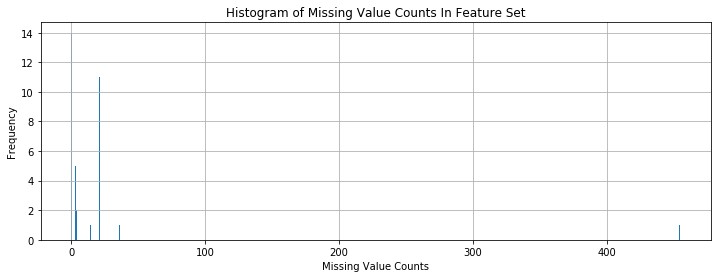

In [14]:
missing_count = td.isnull().sum()
#Plot a histogram of the missingness observed over all features in the dataset
ax = missing_count.hist(bins=num_rows,figsize=(12,4))
ax.set_xlabel("Missing Value Counts")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Missing Value Counts In Feature Set")

---
# Data Cleaning

### Remove instances (rows) with missing outcome values

In [15]:
print("Number of training instances in original dataset = ",num_rows)
td = td.dropna(axis=0,how='any',subset=[outcomeLabel])
print("Number of training instances after removing instances with missing endpoint = ",len(td))
diff = num_rows-len(td)
print("Number of instances removed = ", diff)
num_rows = len(td) #reassign value (if changed)
if diff > 0:
    data_changed = True
td.shape

Number of training instances in original dataset =  980
Number of training instances after removing instances with missing endpoint =  980
Number of instances removed =  0


(980, 44)

In [16]:
#It's critical to reset the index after dropping rows to work with data frame later with pd.concat of separate columns
td = td.reset_index(drop=True)
td.shape
#Ensure Class variable is cast as an int
td[outcomeLabel] = td[outcomeLabel].astype(dtype='int64')
td.info()

(980, 44)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 44 columns):
panc_type01            980 non-null int64
cig_stat               980 non-null int64
cig_stop               525 non-null float64
cig_years              967 non-null float64
pack_years             966 non-null float64
total_alcadj           959 non-null float64
total_fatadj           959 non-null float64
tot_Kcal               959 non-null float64
totalcarbadj           959 non-null float64
total_proteinadj       959 non-null float64
totalfolate_NDSRadj    959 non-null float64
total_GlyIndex         959 non-null float64
total_GlyLoad          959 non-null float64
totalcholadj           959 non-null float64
Totalredmeatadj        959 non-null float64
totalCALCIUMadj        959 non-null float64
bmi_curc               973 non-null float64
bmi_curr               973 non-null float64
diabetes_f             977 non-null float64
panc_fh                976 non-null float64
fh_cancer          

In [17]:
#Confirm no missing values in outcome variable
na_percent = np.sum(td[outcomeLabel].isnull())/len(td[outcomeLabel])*100
if na_percent > 0:
    print(c,'\t\t% Missing(N/A) = ',np.sum(td[outcomeLabel].isnull())/len(td)*100)
else:
    print('No missing values found in: '+ str(outcomeLabel))

No missing values found in: panc_type01


### Remove columns to be ignored in analysis

In [18]:
print("Number of columns in original dataset = ", num_cols)
td = td.drop(ignore_columns, axis=1)
print("Number of columns after removing ignored columns = ", len(td.columns))
diff = num_cols-len(td.columns)
print("Number of columns removed = ", diff)
num_cols = len(td.columns)
if diff > 0:
    data_changed = True
td.shape

Number of columns in original dataset =  44
Number of columns after removing ignored columns =  40
Number of columns removed =  4


(980, 40)

### Assess class imbalance (assuming discrete outcome)

Counts of each class
0    652
1    328
Name: panc_type01, dtype: int64


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Class Counts (Checking for Imbalance)')

(980, 40)

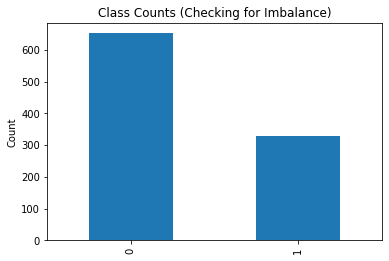

In [19]:
print("Counts of each class")
print(td[outcomeLabel].value_counts())
td[outcomeLabel].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')
td.shape

### Identify categorical variables in dataset

In [20]:
if autoDetectCategorical:
    #Separate independent variables from the rest
    if instLabel == None or instLabel == 'None':
        x_data = td.drop([outcomeLabel], axis=1)
    else:
        x_data = td.drop([outcomeLabel,instLabel], axis=1)

    categorical_variables = identifyCategoricalFeatures(x_data,categoricalCutoff)
    #print(categorical_variables)
    td.shape

(980, 40)

---
# Example Code for other potential data cleaning/processing
- Not applied in this example script, but available here as an example

### Delete Rows/Instances with any missing values
- An extreme alternative to imputation when missing values must be eliminated from the dataset prior to machine learning

In [21]:
#num_rows = td.shape[0]
#print("Number of training instances in original dataset = ",num_rows)
#td = td.dropna()
#print("Number of training instances after removing instances with any missing values = ",td.shape[0])
#diff = num_rows-td.shape[0]
#if diff > 0:
#    data_changed = True

### Delete Columns with any missing values
- An extreme alternative to imputation when missing values must be eliminated from the dataset prior to machine learning

In [22]:
#num_cols = td.shape[1]
#print("Number of training instances in original dataset = ",num_cols)
#td = df.dropna(axis='columns')
#print("Number of training instances after removing instances with any missing values = ",td.shape[1])
#diff = num_cols-td.shape[1]
#if diff > 0:
#    data_changed = True

### One hot encoding of categorical variables
- Ensures that categorical variables are not treated in an ordinal manner by ML algorithms
- The code below is an example of how to convert a single column to one hot encoding, and is not meant to be run as is. 

In [23]:
## Example below assumes a data frame 'df' with a column called 'B'
#one_hot = pd.get_dummies(df['B'])
#df = df.drop('B',axis = 1)
#df = df.join(one_hot)

### Other possible cleaning steps:
- encode text values as numerics
- oversample or undersample to reduce class imbalance
- drop additional rows based on assigned cutoffs, etc
- cast variable types as nominal or ordinal
- construct missingness features with MissingIndicator: https://scikit-learn.org/stable/modules/impute.html

In [24]:
#Saved for later, determines if imputation attempted.
isMissingData = False
if td.isnull().values.any():
    isMissingData = True

## Save cleaned dataset if it has been modified

In [25]:
if data_changed:
    print('Saving cleaned data.')
    td.shape
    data_name = data_name +'_clean'
    td.to_csv(data_name+'.txt', index=None, sep='\t')

Saving cleaned data.


(980, 40)

---
# Further Exploratory/Descriptive Analysis
- Visualize feature correlations in data
- Appropriate univariate analyses

## Feature Correlations

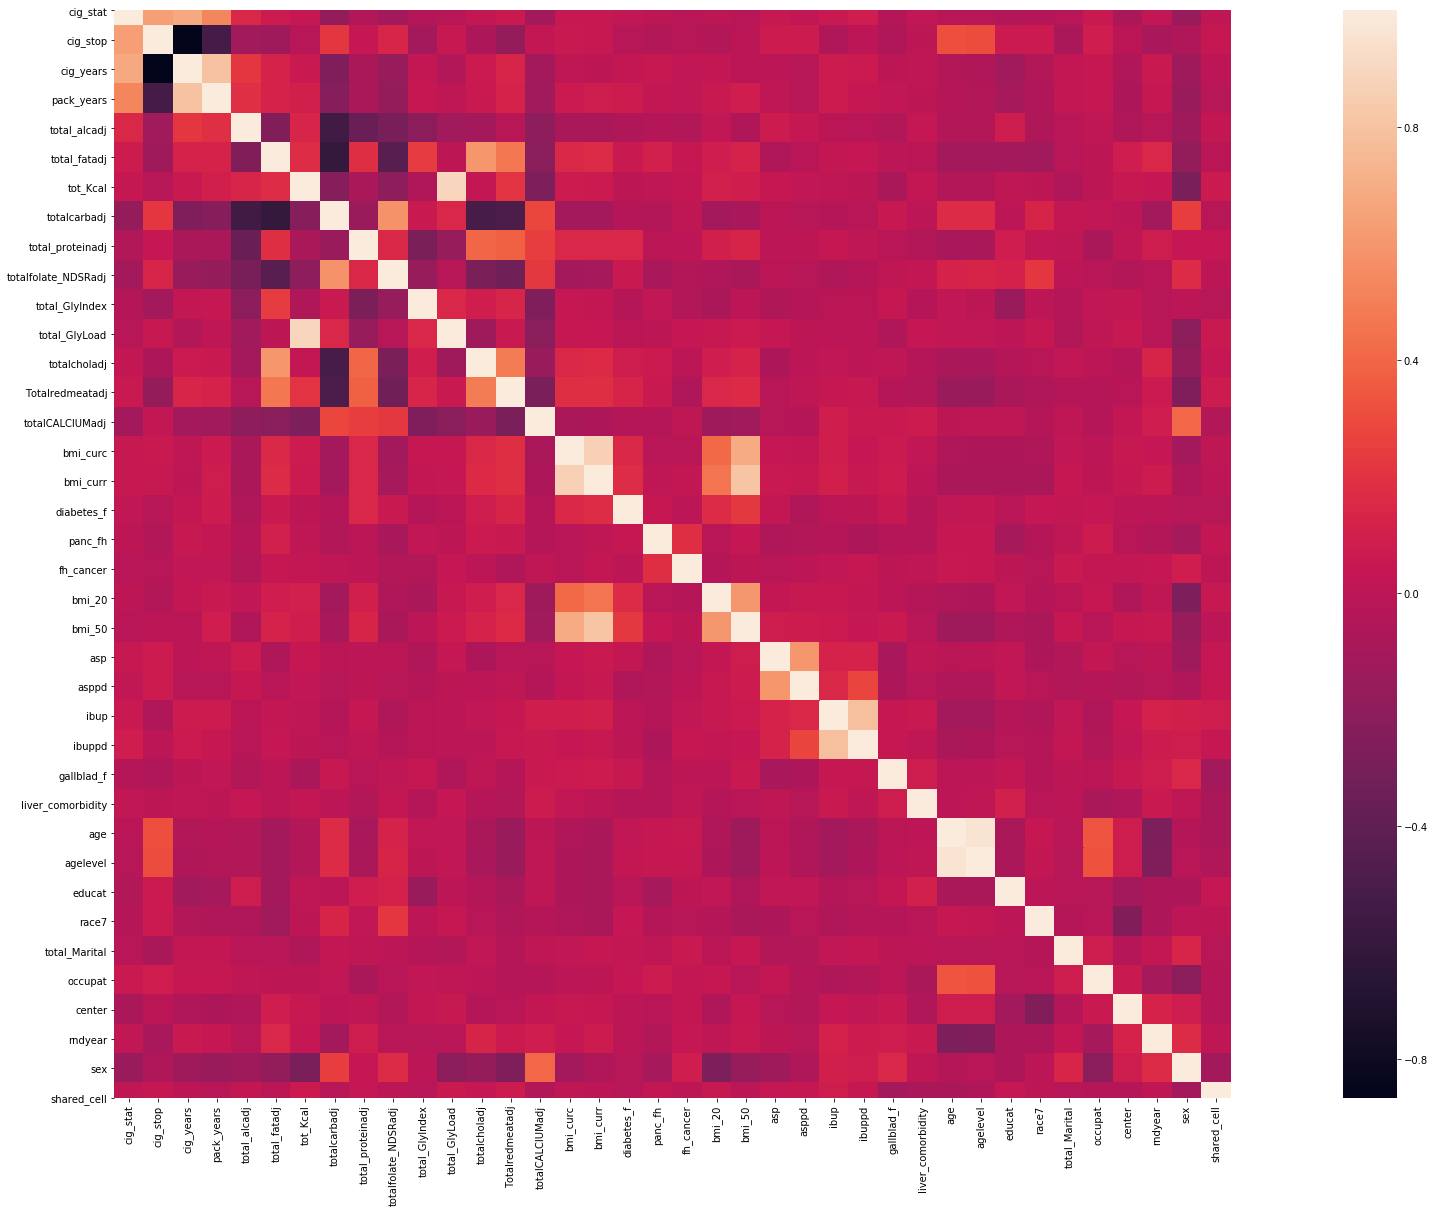

In [26]:
if doCorrelation:
    #Drop outcome column for correlation analysis
    td_cor = td.drop([outcomeLabel], axis=1)
    
    #Compute correlation between the outcome and each feature , excluding NA/null values.
    corrmat = td_cor.corr(method='pearson') 
    f, ax = plt.subplots(figsize = (40,20)) # Note: need large size
    sns.heatmap(corrmat, vmax =1.0,square = True) # Set max value and square-shaped


## Univariate Analysis and Plots
Below we have encoded a method to automatically select an appropriate plot and univariate association test between a single feature and the target outcome in the dataset.

In [27]:
# Code to analyze the univariate relationship between the outcome and each feature
def test_selector(featureName, outcomeLabel, td, categorical_variables):
    p_val = 0
    #Feature and Outcome are discrete/categorical/binary
    if featureName in categorical_variables:  
        #Calculate Contingency Table - Counts
        table = pd.crosstab(td[featureName], td[outcomeLabel])
        
        #Univariate association test (Chi Square Test of Independence - Non-parametric)
        c, p, dof, expected = scs.chi2_contingency(table)
        p_val = p
        
    #Feature is continuous and Outcome is discrete/categorical/binary
    else: 
        #Univariate association test (Mann-Whitney Test - Non-parametric)
        c, p = scs.mannwhitneyu(x=td[featureName].loc[td[outcomeLabel] == 0],y=td[featureName].loc[td[outcomeLabel] == 1])
        p_val = p
        
    return p_val

In [28]:
# Function select appropriate visualizations to examine univariate relationships between each feature and outcome

def graph_selector(featureName, outcomeLabel, td, categorical_variables):
    #Feature and Outcome are discrete/categorical/binary
    if featureName in categorical_variables:  
        #Generate contingency table count bar plot. ------------------------------------------------------------------------
        #Calculate Contingency Table - Counts
        table = pd.crosstab(td[featureName], td[outcomeLabel])
        geom_bar_data = pd.DataFrame(table)
        mygraph = geom_bar_data.plot(kind='bar')
        plt.ylabel('Count')
        new_feature_name = featureName.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig((wd_path+ua_folder+'/'+'UA_Barplot_' + str(new_feature_name)+'_'+outcomeLabel+'_'+data_name), bbox_inches = "tight")
        plt.show()
        
    #Feature is continuous and Outcome is discrete/categorical/binary    
    else: 
        #Generate boxplot-----------------------------------------------------------------------------------------------------
        mygraph = td.boxplot(column=featureName,by=outcomeLabel)
        plt.ylabel(featureName)
        plt.title('')
        new_feature_name = featureName.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig((wd_path+ua_folder+'/'+'UA_Boxplot_' + str(new_feature_name)+'_'+outcomeLabel+'_'+data_name), bbox_inches = "tight")
        plt.show()

Plotting top significant 20 features.
###################################################
Significant Univariate Associations:
cig_stop: (p-val = 6.9547877140841624e-15)
cig_stat: (p-val = 3.406936080140237e-07)
cig_years: (p-val = 1.1214529509753237e-05)
pack_years: (p-val = 0.00010790869313252349)
bmi_20: (p-val = 0.002419775546942775)
diabetes_f: (p-val = 0.034050193588316416)
total_alcadj: (p-val = 0.11092560188467288)
educat: (p-val = 0.14116001036960754)
totalcarbadj: (p-val = 0.15241464272889738)
Totalredmeatadj: (p-val = 0.16934049702918125)
gallblad_f: (p-val = 0.19429130939587547)
bmi_curc: (p-val = 0.2126961301090912)
occupat: (p-val = 0.2148120705837724)
total_GlyIndex: (p-val = 0.2238588661054154)
bmi_curr: (p-val = 0.26232974890923455)
shared_cell: (p-val = 0.2657307565672749)
total_GlyLoad: (p-val = 0.28900462208917277)
center: (p-val = 0.3134287354527783)
totalCALCIUMadj: (p-val = 0.3230902024935792)
total_fatadj: (p-val = 0.3495231276057661)


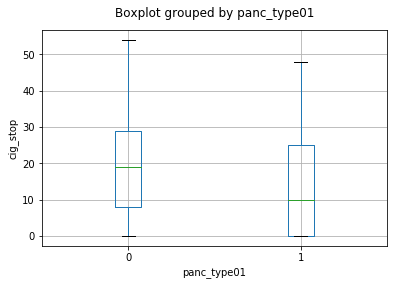

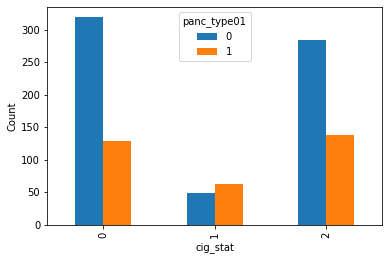

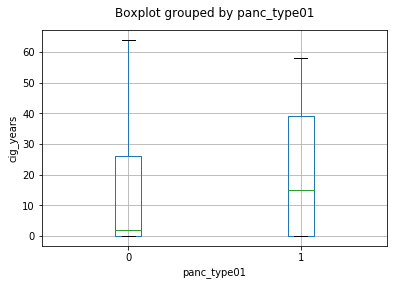

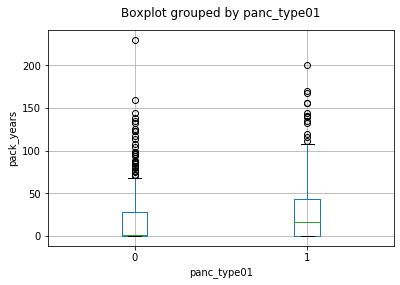

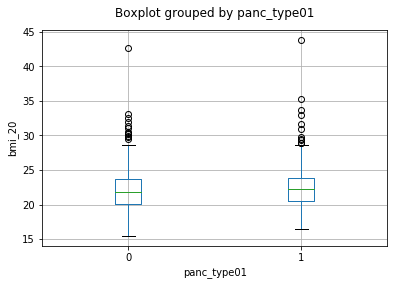

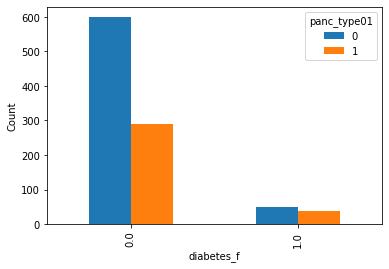

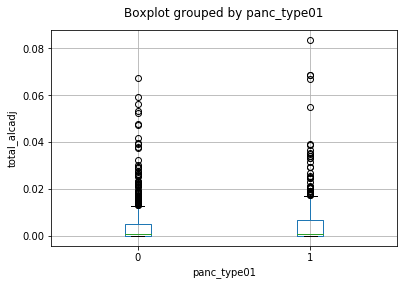

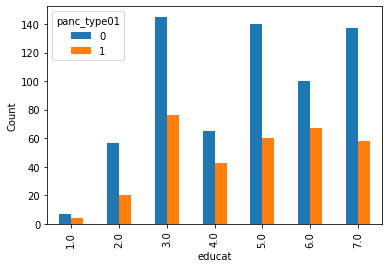

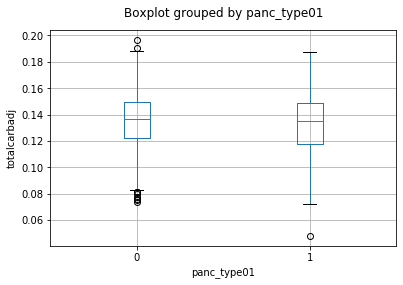

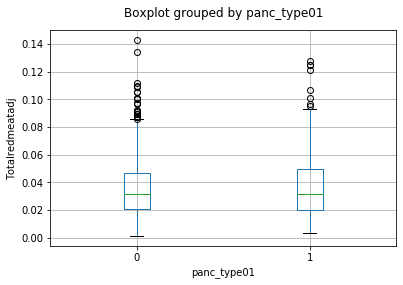

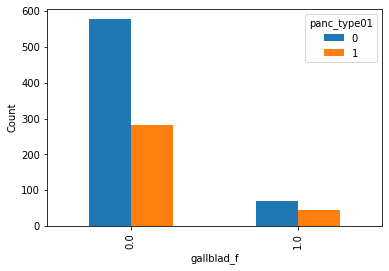

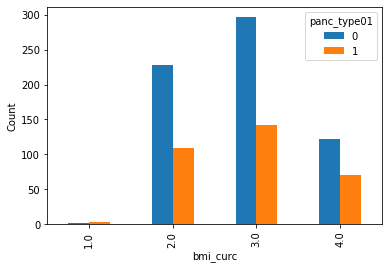

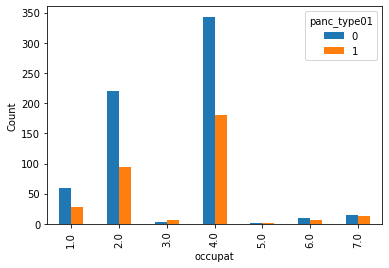

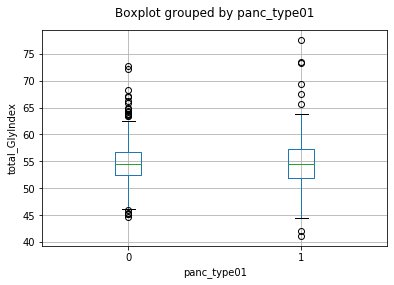

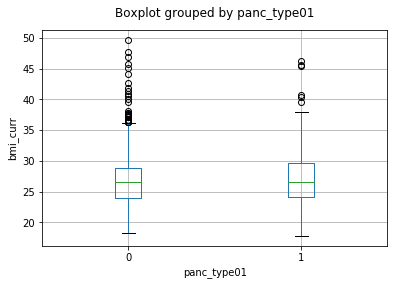

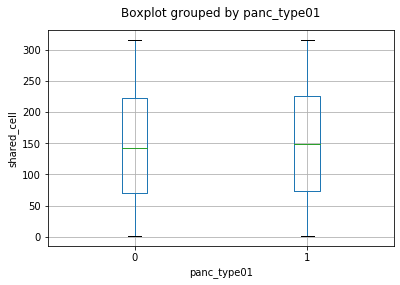

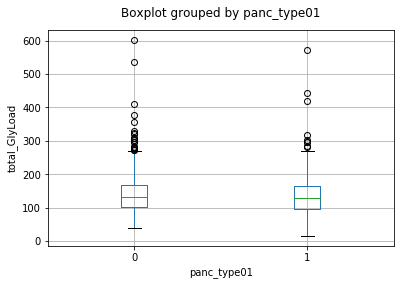

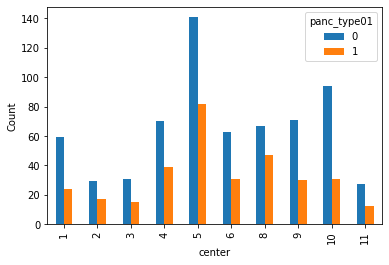

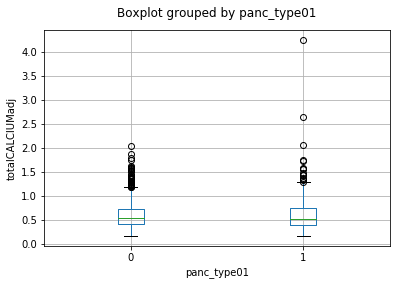

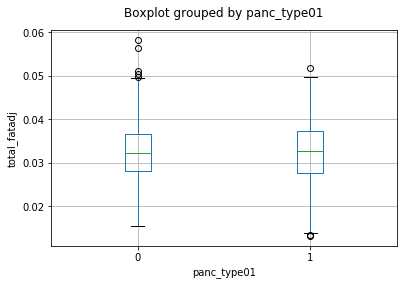

In [29]:
if doUA:
    p_val_dict = {}
    # run appropriate univariate association test for each independent variable
    for each in td:
        if each != outcomeLabel: 
            p_val_dict[each] = test_selector(each, outcomeLabel, td, categorical_variables)
    
    num_features = td.shape[1] - 1
    
    sorted_p_list = sorted(p_val_dict.items(), key = lambda item:item[1])
    
    #Save all p-values to file
    pval_df = pd.DataFrame.from_dict(p_val_dict, orient='index')
    filepath = wd_path+ua_folder+'/'+'UA_Significance_'+data_name+'.csv'
    pval_df.to_csv(filepath, header=['p-value'], index=True)  
    
    min_num = min(topResults,num_features)
    sorted_p_list = sorted_p_list[: min_num]
    print('Plotting top significant '+ str(min_num) + ' features.')
    
    # summarize significant values of selected number of features
    print('###################################################')
    print('Significant Univariate Associations:')
    for each in sorted_p_list[:min_num]:
        print(each[0]+": (p-val = "+str(each[1]) +")")

    #generate appropriate descriptive plot for selected number of features
    for i in sorted_p_list:
        for j in td:
            if j == i[0]:# if the feature name is within the selected feature list
                graph_selector(j, outcomeLabel, td, categorical_variables) #plot appropriate figure for each feature

---
# Create n-fold Cross Validation (CV) Datasets 
- i.e. Training and Testing Datasets

In [30]:
#Create a header list of independant feature names
header = td.columns.values.tolist()
header.remove(outcomeLabel)
if instLabel != None and instLabel != 'None':
    header.remove(instLabel)

#Perform CV partitioning (get back list of training and testing partition dataframes)
train_dfs, test_dfs = cv_partitioner(td, cv_partitions, partition_method, outcomeLabel, categoricalOutcome, matchName, randomSeed)

if partition_method == 'M':
    header.remove(matchName)

Nominal Matched Partitioning


---
# Transform data - Standard Scaling
- Features are independently scaled to allow them to be more comparable in downstream logistic regression modeling, etc
- Scaling is learned on the training data and saved with pickel so that the same scaling may be applied to any future testing data
- Completed within each training and testing partition independently

In [31]:
if scaleData:
    print('Scaling Data')
    data_name = data_name +'_scale'
    name_path = wd_path+model_folder+'/'+'Scalar_' + data_name+'_'
    train_dfs, test_dfs = dataScaling(train_dfs, test_dfs, outcomeLabel, instLabel, name_path, header)

Scaling Data


---
# Impute Missing Data Values
- Missing data values in categorical features are imputed with simple 'mode' imputation
- Remaining missing data values are imputed using Iterative Imputer (i.e. MICE) 
- Completed within each training and testing partition independently

In [32]:
if imputeData and isMissingData:
    print('Imputing Data')
    data_name = data_name + '_imp'
    train_dfs, test_dfs = imputeCVData(outcomeLabel, instLabel, categorical_variables, header, train_dfs, test_dfs, randomSeed)

Imputing Data


### Confirm Missing Data Imputation

In [33]:
print("Training Datasets")
for each in train_dfs:
    each.isnull().sum().sum()

print("Testing Datasets")
for each in test_dfs:
    each.isnull().sum().sum()

Training Datasets


0

0

0

0

0

0

0

0

0

0

Testing Datasets


0

0

0

0

0

0

0

0

0

0

## Save Training and Testing Datasets as .txt Files

In [34]:
data_name = data_name+'_CV_'+str(partition_method)

counter = 0
for each in train_dfs:
    each.to_csv(cv_data_folder+'/'+data_name+'_'+str(counter)+'_Train.txt', index=None, sep='\t')
    counter += 1
    
counter = 0
for each in test_dfs:
    each.to_csv(cv_data_folder+'/'+data_name+'_'+str(counter)+'_Test.txt', index=None, sep='\t')
    counter += 1

---
# Load, Check, and Prepare Saved CV Datasets for ML

## Load CV Partition Datasets
Re-loads training and testing datasets from saved .txt files

In [35]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []

for i in range(cv_partitions):
    #Load training partition
    trainSet = pd.read_csv(cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt', na_values='NA', sep = "\t")
    trainList.append(trainSet)
    
    #Load testing partition
    testSet = pd.read_csv(cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt', na_values='NA', sep = "\t")
    testList.append(testSet)
    
print('Number of Training Partitions: '+ str(len(trainList)))
print('Number of Training Partitions: '+ str(len(testList)))

Number of Training Partitions: 10
Number of Training Partitions: 10


#### Quality Control Check (Checking one of the partitions)
Merge the first training/testing datasets to confirm original dataset is reconstituted

In [36]:
#Confirm case/control counts when merging one training and testing dataset
classesTrain = trainList[0].apply(lambda x: True if x[outcomeLabel] == 1 else False , axis=1)
casesTrain = len(classesTrain[classesTrain == True].index)
controlsTrain = len(classesTrain[classesTrain == False].index)

classesTest = testList[0].apply(lambda x: True if x[outcomeLabel] == 1 else False , axis=1)
casesTest = len(classesTest[classesTest == True].index)
controlsTest = len(classesTest[classesTest == False].index)

print("Number of Cases in Original Dataset: "+str(casesTrain+casesTest))
print("Number of Controls in Original Dataset: "+str(controlsTrain+controlsTest))

Number of Cases in Original Dataset: 328
Number of Controls in Original Dataset: 652


In [37]:
#Confirm training and testing set dimensions
print("Training Set Dimensions: " + str(trainList[0].shape))
print("Testing Set Dimensions: " + str(testList[0].shape))
numColumns = trainList[0].shape[1]

Training Set Dimensions: (887, 39)
Testing Set Dimensions: (93, 39)


## Partition Data Preprocessing
If present, remove instance id's from datasets prior to analysis. Also confirm that training and testing sets have same set of columns.

In [38]:
# Drop Instance ID from all training and test sets
if instLabel != None and instLabel != 'None':
    for i in range(cv_partitions):
        trainList[i] = trainList[i].drop([instLabel] , axis = 1)
        testList[i] = testList[i].drop([instLabel] , axis = 1)

In [39]:
trainColumnNames = list(trainList[0])
testColumnNames = list(testList[0])

if not trainColumnNames == testColumnNames:
    print('Error: Training columns do not match testing columns!')

# As we can see, instLabel is no longer a column name for any of the sets
#print(trainColumnNames)
#print(testColumnNames)

#Create master list of feature names (excluding outcome column)
ordered_feature_names = copy.deepcopy(trainColumnNames) #Stores original ordered feature list 
ordered_feature_names.remove(outcomeLabel)
#ordered_feature_names

## Format data for Scikit learn (separate features from outcome)

In [40]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(cv_partitions):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
 
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)

---
# Feature Importance Evaluation
- Completed independently within each training dataset

In [41]:
#Store indexes of 'interesting' features identified by each algorithm in algorithm labeled dictionary
selectedFeatureLists = {}
metaScoreDict = {}
metaFeatureRanks = {}

## Mutual information


Mutual Information Run Time: 2.1562607288360596


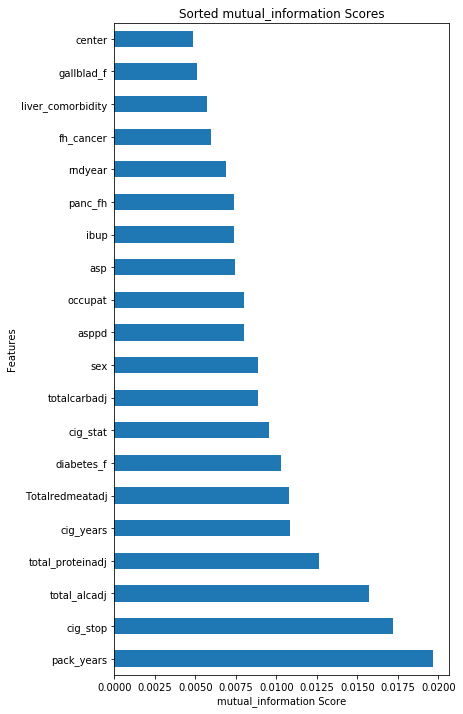

In [42]:
#Run Mutual Information for each CV------------------------------------------------------------------------------
algorithm = 'mutual_information'
if algorithm in algorithms:
    start_time = time.time()
    scoreSet = [] #Used to save excel filel with data-ordered scores for each CV partition
    featureNameRanks = [] #list of feature name ranks for each CV partition
    scoreDictSet = [] #list of feature/score dictionaries (one for each cv partition)
    cvKeepList = [] #Used for initial feature selection attempt to keep only features with 'informative' support
    
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #Run algorithm and return scores and sorted score dictionary
        scores, scoreDict, score_sorted_features = run_mi(xTrainList[i],yTrainList[i], i, data_name, output_folder,randomSeed,ordered_feature_names,algorithm)
        scoreSet.append(scores) #store data-ordered scores for this cv partition
        scoreDictSet.append(scoreDict)
        featureNameRanks.append(score_sorted_features)
        
        #Add list of feature names that meet the 'informative' cutoff
        keepList = []
        for each in scoreDict:
            if scoreDict[each] > 0:
                keepList.append(each)
                #keepList.append(ordered_feature_names.index(each))
        cvKeepList.append(keepList)
        
        #Create dictionary of average scores
        if i == 0:
            scoreSum = copy.deepcopy(scoreDict)
        else:
            for each in scoreDict:
                scoreSum[each] += scoreDict[each]
    
    #Save/report analysis results
    #cv_output_name = data_name+'_clean_imp_CV_'+partition_method
    reportAllFS(scoreSet, algorithm, ordered_feature_names,output_folder,data_name) #Save CV scores file for algorithm
    reportTopFS(scoreSum, algorithm, cv_partitions,topResults,wd_path,output_folder,data_name)
    
    #Store info for downstream feature selection
    selectedFeatureLists[algorithm] = cvKeepList
    metaScoreDict[algorithm] = scoreDictSet
    metaFeatureRanks[algorithm] = featureNameRanks

    elapsed_time = time.time() - start_time
    print('Mutual Information Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## MultiSURF


MultiSURF Run Time: 169.15310287475586


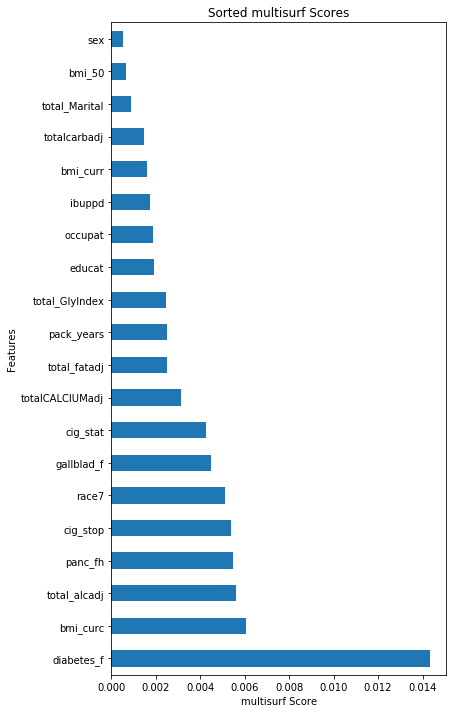

In [43]:
#Run MultiSURF for each CV------------------------------------------------------------------------------
algorithm = 'multisurf'
if algorithm in algorithms:
    start_time = time.time()
    scoreSet = [] #Used to save excel filel with data-ordered scores for each CV partition
    scoreDictSet = [] #list of feature/score dictionaries (one for each cv partition)
    cvKeepList = [] #Used for initial feature selection attempt to keep only features with 'informative' support
    
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #If training set is large MultiSURF will run very slowly - quadradic time complexity with # instances (so use subset)
        tempData = pd.concat([pd.DataFrame(yTrainList[i]),pd.DataFrame(xTrainList[i])], axis=1, sort=False)
        if len(tempData) < instanceSubset:
            dataSample = tempData.sample(n=len(tempData), axis = 0)
        else:
            dataSample = tempData.sample(n=instanceSubset, axis = 0)

        xTrain = dataSample.iloc[:, 1:].values
        yTrain = dataSample.iloc[:, 0].values
        #Run algorithm and return scores and sorted score dictionary
        scores, scoreDict, score_sorted_features = run_multisurf(xTrain,yTrain, i, data_name, output_folder,randomSeed,ordered_feature_names,algorithm)
        scoreSet.append(scores) #store data-ordered scores for this cv partition
        scoreDictSet.append(scoreDict)
        featureNameRanks.append(score_sorted_features)
        
        #Add list of feature names that meet the 'informative' cutoff
        keepList = []
        for each in scoreDict:
            if scoreDict[each] > 0:
                keepList.append(each)
                #keepList.append(ordered_feature_names.index(each))
        cvKeepList.append(keepList)
        
        #Create dictionary of average scores
        if i == 0:
            scoreSum = copy.deepcopy(scoreDict)
        else:
            for each in scoreDict:
                scoreSum[each] += scoreDict[each]
    
    #Save/report analysis results
    reportAllFS(scoreSet, algorithm, ordered_feature_names,output_folder,data_name) #Save CV scores file for algorithm
    reportTopFS(scoreSum, algorithm, cv_partitions,topResults,wd_path,output_folder,data_name)
    
    #Store info for downstream feature selection
    selectedFeatureLists[algorithm] = cvKeepList
    metaScoreDict[algorithm] = scoreDictSet
    metaFeatureRanks[algorithm] = featureNameRanks

    elapsed_time = time.time() - start_time
    print('MultiSURF Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

---
# Feature Selection

## Identify union of 'interesting' features from different algorithms
- Operates no matter how many feature selection methods are being applied
- But assumes that all methods have larger scores as being more informative

In [44]:
cv_Selected_List = selectFeatures(algorithms, cv_partitions, selectedFeatureLists, maxFeaturesToKeep,metaFeatureRanks)

### Report counts of 'interesting' features identified by each algorithm

In [45]:
print('Original feature count: '+str(len(ordered_feature_names)))

for each in algorithms:
    print(each)
    for cv in selectedFeatureLists[each]:
        print(len(cv))
    
print("Selected Counts")
for each in cv_Selected_List:
    print(len(each))

Original feature count: 37
mutual_information
20
18
25
19
22
22
16
18
22
15
multisurf
21
20
18
19
18
19
19
20
20
17
Selected Counts
29
27
30
28
29
29
26
29
29
24


## Generate Filtered Datasets (Save as new .txt files)
- These datasets included only the selected features for each respective partition
- Note that the feature order from the original datasets is no longer preserved in these datasets

In [46]:
if filterPoorFeatures:
    genFilteredDatasets(cv_Selected_List, outcomeLabel, instLabel,cv_partitions,cv_data_folder,data_name)
    data_name = data_name +'_FS'

## Generate Filtered MultiSURF Files (Save as new .txt files)

In [47]:
if 'multisurf' in algorithms: #This method is only meant for working with MultiSURF scores
    if filterPoorFeatures:
        for i in range(cv_partitions):
            tempDict = scoreDictSet[i]

            #create new dictionary with only selected features
            scoreDict = {}
            for j in cv_Selected_List[i]:
                scoreDict[j] = tempDict[j]
            
            filename = output_folder+'/'+'multisurf'+'_'+data_name+'_'+str(i)+'_Train.txt'
            sort_save_fs_fi_scores(scoreDict, 'multisurf', filename)

---
# Load, Check, and Prepare Filtered CV Datasets for ML
- If user opted not to filter datasets then the code below will simply reload the original CV datasets again.

## Load CV Partition Datasets (Filtered Datasets)

In [48]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []

for i in range(cv_partitions):
    #Load training partition
    trainset_name = cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt'
    trainSet = pd.read_csv(trainset_name, na_values='NA', sep = "\t")
    trainList.append(trainSet)

    #Load testing partition
    testset_name = cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt'
    testSet = pd.read_csv(testset_name, na_values='NA', sep = "\t")
    testList.append(testSet)
    
print('Number of Training Partitions: '+ str(len(trainList)))
print('Number of Training Partitions: '+ str(len(testList)))

Number of Training Partitions: 10
Number of Training Partitions: 10


## CV partition data cleaning (Filtered Datasets)

In [49]:
# Drop Instance ID from all training and test sets
if instLabel != None and instLabel != 'None':
    for i in range(cv_partitions):
        trainList[i] = trainList[i].drop([instLabel] , axis = 1)
        testList[i] = testList[i].drop([instLabel] , axis = 1)

In [50]:
global_ordered_features = [] #Holds the new order of features in the FS CV datasets
for i in range(cv_partitions):
    cv_ordered_features = list(trainList[i])
    cv_ordered_features.remove(outcomeLabel)
    #print(cv_ordered_features)
    global_ordered_features.append(cv_ordered_features)

## Format data for Scikit learn (filtered datasets)

In [51]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(cv_partitions):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
 
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)


---
# Machine Learning Modeling
ML algorithms are run one after the other below. Within each we conduct a hyperparameter sweep, train a best model and evaluate it indendently within each CV training/testing partition. 
- All standard classification metrics are computed for the resulting models as well as an ROC curve and precision/recall curve

## Run Logistic Regression

Running logistic_regression
Best trial:
  Value:  0.5606428594100821
  Params: 
    penalty: l2
    dual: False
    C: 0.0003630322466779861
    solver: liblinear
    class_weight: None
    max_iter: 539.948440978743
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5721649484536082
  Params: 
    penalty: l2
    dual: False
    C: 0.0003630322466779861
    solver: liblinear
    class_weight: None
    max_iter: 539.948440978743
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.57001517001517
  Params: 
    penalty: l2
    dual: True
    C: 0.0009736974684895653
    solver: liblinear
    class_weight: None
    max_iter: 348.7712624545931
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.576356970722453
  Params: 
    penalty: l2
    dual: False
    C: 0.0003630322466779861
    solver: liblinear
    class_weight: None
    max_iter: 539.948440978743
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5734128332802854
  Params: 
    penalty: l2
    dual: False
    C: 297.3042389323509
    solver: saga
    class_weight: balanced
    max_iter: 51.70191786366991
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5791246848389705
  Params: 
    penalty: l2
    dual: True
    C: 0.0009736974684895653
    solver: liblinear
    class_weight: None
    max_iter: 348.7712624545931
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5594773885196406
  Params: 
    penalty: l2
    dual: False
    C: 0.0003630322466779861
    solver: liblinear
    class_weight: None
    max_iter: 539.948440978743
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5693129018002114
  Params: 
    penalty: l2
    dual: True
    C: 0.0009736974684895653
    solver: liblinear
    class_weight: None
    max_iter: 348.7712624545931
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5705018868543161
  Params: 
    penalty: l2
    dual: True
    C: 0.0009736974684895653
    solver: liblinear
    class_weight: None
    max_iter: 348.7712624545931
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5729204657776087
  Params: 
    penalty: l2
    dual: True
    C: 0.0009736974684895653
    solver: liblinear
    class_weight: None
    max_iter: 348.7712624545931
    n_jobs: -1


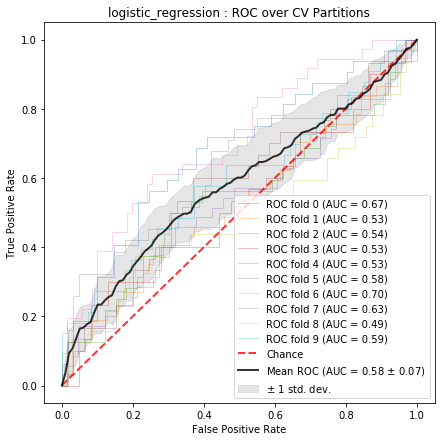

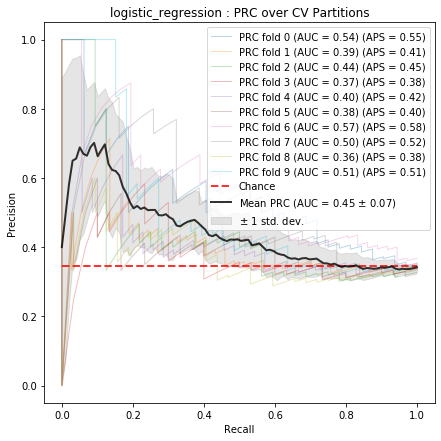

Avg. Model Balanced Accuracy = 0.5683332496733177 (std. dev. = 0.045272130580548145)
Avg. Model Accuracy = 0.644302797972629 (std. dev. = 0.0704010672579136)
Avg. Model F1-Score = 0.38824144892162055 (std. dev. = 0.0687333573379603)
Avg. Model Recall = 0.34231178706985155 (std. dev. = 0.09967934688090074)
Avg. Model Specificity = 0.7943547122767837 (std. dev. = 0.13929737750015564)
Avg. Model Precision = 0.48888451427244534 (std. dev. = 0.11219530543221297)
Avg. Model True Positives = 11.3 (std. dev. = 3.6345563690772495)
Avg. Model True Negatives = 51.8 (std. dev. = 9.620810776644554)
Avg. Model False Positives = 13.4 (std. dev. = 9.167333309092673)
Avg. Model False Negatives = 21.5 (std. dev. = 3.2326459750489227)
Avg. ROC AUC = 0.5791921581701148 (std. dev. = 0.06726000040247289)
Avg. PRC AUC = 0.4468486866211336 (std. dev. = 0.074411128151289)
Avg. PRC Precision Score = 0.4618933525360496 (std. dev. = 0.07042061780124044)

---Feature Importances---



Names    Scores
1           cig_stop  0.032790
2          cig_years  0.011290
17        diabetes_f  0.011148
8   total_proteinadj  0.007612
3         pack_years  0.006929
33           occupat  0.006163
26        gallblad_f  0.005317
13   Totalredmeatadj  0.004668
19         fh_cancer  0.004663
20            bmi_20  0.004541
30            educat  0.003781
5       total_fatadj  0.003138
18           panc_fh  0.003055
23             asppd  0.002382
14   totalCALCIUMadj  0.002322
0           cig_stat  0.002320
29          agelevel  0.002309
31             race7  0.002309
6           tot_Kcal  0.002235
15          bmi_curc  0.002230

Logistic Regression Run Time: 122.38004541397095


In [52]:
algorithm = 'logistic_regression'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Logistic Regression Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Decision Tree

Running decision_tree
Best trial:
  Value:  0.5691536728520049
  Params: 
    criterion: gini
    splitter: random
    max_depth: 29
    min_samples_split: 16
    min_samples_leaf: 43
    max_features: None
    class_weight: None
Running decision_tree
Best trial:
  Value:  0.5661512027491409
  Params: 
    criterion: gini
    splitter: random
    max_depth: 29
    min_samples_split: 16
    min_samples_leaf: 43
    max_features: None
    class_weight: None
Running decision_tree
Best trial:
  Value:  0.5791840434697577
  Params: 
    criterion: entropy
    splitter: random
    max_depth: 4
    min_samples_split: 15
    min_samples_leaf: 20
    max_features: None
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.5757152745731425
  Params: 
    criterion: entropy
    splitter: best
    max_depth: 1
    min_samples_split: 13
    min_samples_leaf: 22
    max_features: None
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.5914276813024972
  Param

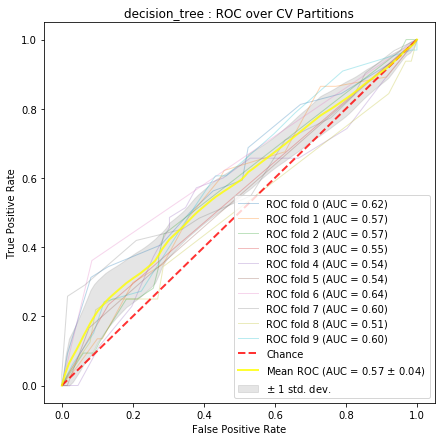

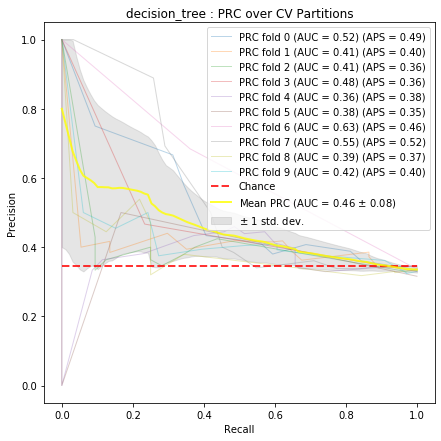

Avg. Model Balanced Accuracy = 0.5551454048517146 (std. dev. = 0.045048231575934544)
Avg. Model Accuracy = 0.6471381180658888 (std. dev. = 0.051561897051275785)
Avg. Model F1-Score = 0.3231308681451369 (std. dev. = 0.13257653292556693)
Avg. Model Recall = 0.2782856479227447 (std. dev. = 0.14684008461745904)
Avg. Model Specificity = 0.8320051617806848 (std. dev. = 0.12097429474620883)
Avg. Model Precision = 0.4781618703723967 (std. dev. = 0.11198683526775985)
Avg. Model True Positives = 9.1 (std. dev. = 4.948737212663449)
Avg. Model True Negatives = 54.4 (std. dev. = 9.32952303175248)
Avg. Model False Positives = 10.8 (std. dev. = 7.652450587883597)
Avg. Model False Negatives = 23.7 (std. dev. = 5.404627646748664)
Avg. ROC AUC = 0.5728671159103866 (std. dev. = 0.037420716992295974)
Avg. PRC AUC = 0.4553857504765311 (std. dev. = 0.08279511049462389)
Avg. PRC Precision Score = 0.4102961976520361 (std. dev. = 0.05776733505506944)

---Feature Importances---



Names    Scores
1           cig_stop  0.589648
2          cig_years  0.053495
13   Totalredmeatadj  0.038551
17        diabetes_f  0.036285
11     total_GlyLoad  0.036069
15          bmi_curc  0.032197
30            educat  0.028599
16          bmi_curr  0.025829
0           cig_stat  0.022633
8   total_proteinadj  0.021129
5       total_fatadj  0.018503
19         fh_cancer  0.015625
33           occupat  0.013208
7       totalcarbadj  0.008994
32     total_Marital  0.008780
28               age  0.008076
22               asp  0.007128
24              ibup  0.006591
14   totalCALCIUMadj  0.006309
6           tot_Kcal  0.005758

Decision Tree Run Time: 110.0914626121521


In [53]:
algorithm = 'decision_tree'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Decision Tree Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Random Forest

Running random_forest
Best trial:
  Value:  0.5690009839756033
  Params: 
    n_estimators: 605
    criterion: gini
    max_depth: 3
    min_samples_split: 27
    min_samples_leaf: 26
    max_features: log2
    bootstrap: True
    oob_score: True
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.5687285223367696
  Params: 
    n_estimators: 813
    criterion: gini
    max_depth: 24
    min_samples_split: 4
    min_samples_leaf: 8
    max_features: auto
    bootstrap: True
    oob_score: False
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.5784203891346749
  Params: 
    n_estimators: 156
    criterion: entropy
    max_depth: 1
    min_samples_split: 31
    min_samples_leaf: 12
    max_features: None
    bootstrap: True
    oob_score: False
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.5895887812131467
  Params: 
    n_estimators: 567
    criterion: entropy
    max_de

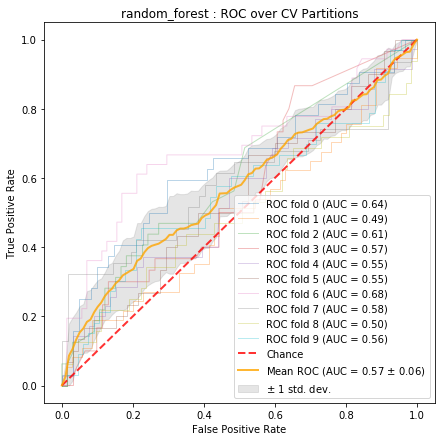

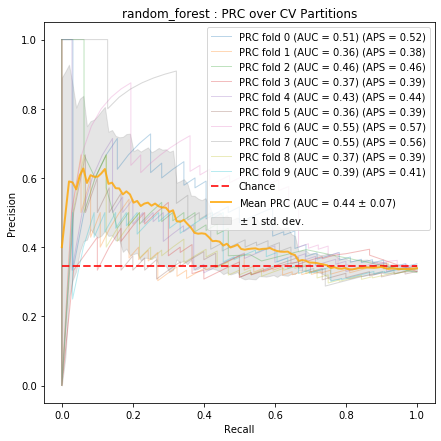

Avg. Model Balanced Accuracy = 0.5582337168995241 (std. dev. = 0.04441983663207923)
Avg. Model Accuracy = 0.6324700445412856 (std. dev. = 0.046315696690262864)
Avg. Model F1-Score = 0.3732036463770502 (std. dev. = 0.08747433801186713)
Avg. Model Recall = 0.33551824682873066 (std. dev. = 0.09304477937699959)
Avg. Model Specificity = 0.7809491869703173 (std. dev. = 0.07557472529355846)
Avg. Model Precision = 0.4442710011931662 (std. dev. = 0.08338387813398049)
Avg. Model True Positives = 11.0 (std. dev. = 3.1304951684997055)
Avg. Model True Negatives = 51.0 (std. dev. = 6.387487769068525)
Avg. Model False Positives = 14.2 (std. dev. = 4.853864439804639)
Avg. Model False Negatives = 21.8 (std. dev. = 3.4583232931581165)
Avg. ROC AUC = 0.570838513206812 (std. dev. = 0.05561022832521542)
Avg. PRC AUC = 0.43589803967088353 (std. dev. = 0.07279400728982201)
Avg. PRC Precision Score = 0.4497028183455294 (std. dev. = 0.06931743512477238)

---Feature Importances---



Names    Scores
1           cig_stop  0.312241
2          cig_years  0.130574
3         pack_years  0.050883
7       totalcarbadj  0.047586
10    total_GlyIndex  0.046757
11     total_GlyLoad  0.041897
20            bmi_20  0.041376
5       total_fatadj  0.036747
4       total_alcadj  0.036126
14   totalCALCIUMadj  0.033358
8   total_proteinadj  0.029897
16          bmi_curr  0.029072
6           tot_Kcal  0.023907
21            bmi_50  0.022584
13   Totalredmeatadj  0.019509
30            educat  0.015240
0           cig_stat  0.011164
33           occupat  0.009296
23             asppd  0.008397
15          bmi_curc  0.006404

Random Forest Run Time: 1552.6087908744812


In [54]:
algorithm = 'random_forest'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
    
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Random Forest Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Naive Bayes

Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes


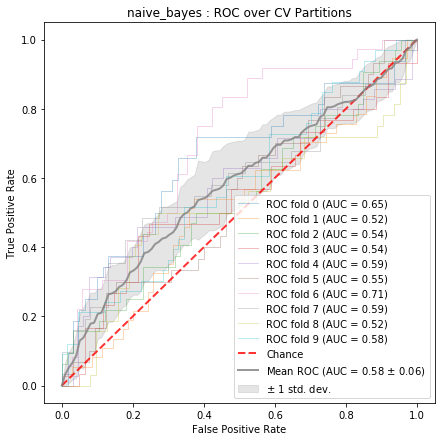

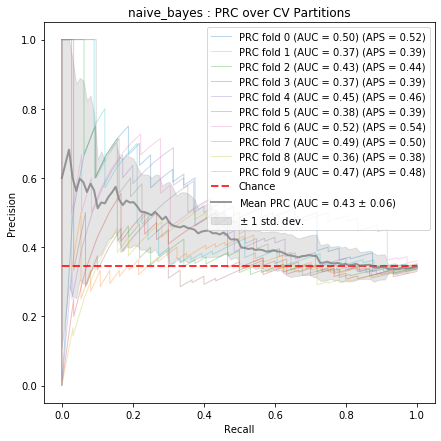

Avg. Model Balanced Accuracy = 0.5728992394579444 (std. dev. = 0.037495607432694214)
Avg. Model Accuracy = 0.6409606032256118 (std. dev. = 0.039015894810184124)
Avg. Model F1-Score = 0.4050564321312312 (std. dev. = 0.058017518202606984)
Avg. Model Recall = 0.3673364286469125 (std. dev. = 0.06592991125590604)
Avg. Model Specificity = 0.7784620502689764 (std. dev. = 0.05826967880100103)
Avg. Model Precision = 0.45953491611411257 (std. dev. = 0.07038899607692505)
Avg. Model True Positives = 12.0 (std. dev. = 2.04939015319192)
Avg. Model True Negatives = 50.8 (std. dev. = 5.035871324805668)
Avg. Model False Positives = 14.4 (std. dev. = 3.6660605559646724)
Avg. Model False Negatives = 20.8 (std. dev. = 2.993325909419153)
Avg. ROC AUC = 0.5789341536860263 (std. dev. = 0.05649350673394889)
Avg. PRC AUC = 0.4342050718388718 (std. dev. = 0.057601208542589946)
Avg. PRC Precision Score = 0.44735389642713513 (std. dev. = 0.05739553412810451)

---Feature Importances---



Names    Scores
2          cig_years  0.018716
17        diabetes_f  0.017711
1           cig_stop  0.016884
3         pack_years  0.014752
4       total_alcadj  0.012225
14   totalCALCIUMadj  0.008871
18           panc_fh  0.007395
7       totalcarbadj  0.006597
5       total_fatadj  0.006181
33           occupat  0.005658
10    total_GlyIndex  0.004768
0           cig_stat  0.004452
26        gallblad_f  0.003903
15          bmi_curc  0.003576
21            bmi_50  0.002953
11     total_GlyLoad  0.002872
8   total_proteinadj  0.002207
13   Totalredmeatadj  0.002093
20            bmi_20  0.001704
22               asp  0.001521

Naive Bayes Run Time: 1.7603187561035156


In [55]:
algorithm = 'naive_bayes'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Naive Bayes Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run XGBoost

Running XGB
Best trial:
  Value:  0.5555668044790597
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 1.278677336824462e-05
    alpha: 1.5770691027023113e-07
    eta: 8.637873586499504e-08
    gamma: 0.041716936133269815
    max_depth: 26
    grow_policy: lossguide
    n_estimators: 561
    min_samples_split: 47
    min_samples_leaf: 19
    subsample: 0.8489299280807407
    min_child_weight: 1.4998053887946656
    colsample_bytree: 0.5753045341576124
    scale_pos_weight: 1.9966216216216217



Running XGB
Best trial:
  Value:  0.577319587628866
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 2.287289637788906e-05
    alpha: 0.001962464648205736
    eta: 0.05279470079332802
    gamma: 2.6979334811400915e-05
    max_depth: 2
    grow_policy: lossguide
    n_estimators: 13
    min_samples_split: 19
    min_samples_leaf: 30
    subsample: 0.5908479642673916
    min_child_weight: 0.32110482324792294
    colsample_bytree: 0.20501446705013254
    scale_pos_weight: 2.0



Running XGB
Best trial:
  Value:  0.5527403813118098
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.00018131533187089465
    alpha: 1.5912127223381323e-06
    eta: 0.03538871385976686
    gamma: 0.7332747825896724
    max_depth: 1
    grow_policy: depthwise
    n_estimators: 125
    min_samples_split: 12
    min_samples_leaf: 13
    subsample: 0.5183447334721007
    min_child_weight: 1.128081540114447
    colsample_bytree: 0.2540886730237528
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.5415276282281359
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.0006738474192240593
    alpha: 1.642916375161057e-08
    eta: 8.76151404814791e-06
    gamma: 0.07833221205285987
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 220
    min_samples_split: 21
    min_samples_leaf: 49
    subsample: 0.6502426869208637
    min_child_weight: 0.6397015607098319
    colsample_bytree: 0.40592468150834543
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.5597481842327203
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 6.674451030957036e-07
    alpha: 1.3180636297855331e-07
    eta: 4.671569630100465e-08
    gamma: 0.02034087395758918
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 185
    min_samples_split: 31
    min_samples_leaf: 44
    subsample: 0.5675593166121482
    min_child_weight: 0.27131094259426514
    colsample_bytree: 0.34194836460991723
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.5842528371099799
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 1.2020790444545703e-08
    alpha: 0.0035499616811938807
    eta: 1.9514913410375328e-07
    gamma: 0.013454691806347752
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 15
    min_samples_split: 45
    min_samples_leaf: 28
    subsample: 0.7153039960721841
    min_child_weight: 8.758497263362727
    colsample_bytree: 0.3075951531042436
    scale_pos_weight: 1.9697986577181208



Running XGB
Best trial:
  Value:  0.5396294568251957
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 3.481368856312722e-07
    alpha: 0.0006287318633357605
    eta: 0.0013818078967424386
    gamma: 0.0002793291943726986
    max_depth: 27
    grow_policy: depthwise
    n_estimators: 620
    min_samples_split: 7
    min_samples_leaf: 38
    subsample: 0.6242159965509024
    min_child_weight: 7.628635140540309
    colsample_bytree: 0.926221454411301
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.5848089043339224
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 2.975872266540335e-05
    alpha: 4.6070584803884363e-07
    eta: 6.42748635411185e-08
    gamma: 0.138884824185259
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 34
    min_samples_split: 49
    min_samples_leaf: 12
    subsample: 0.5665362244372538
    min_child_weight: 7.714144095912066
    colsample_bytree: 0.6413275234858368
    scale_pos_weight: 1.9865319865319866



Running XGB
Best trial:
  Value:  0.5813801190886035
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 7.118395278595506e-08
    alpha: 0.0050179124485295965
    eta: 0.3217415657684928
    gamma: 0.0007059584584952651
    max_depth: 27
    grow_policy: depthwise
    n_estimators: 594
    min_samples_split: 49
    min_samples_leaf: 2
    subsample: 0.9917542550750117
    min_child_weight: 8.554119839080995
    colsample_bytree: 0.6138088830062555
    scale_pos_weight: 1.989864864864865



Running XGB
Best trial:
  Value:  0.5544595616024187
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.22076411583408861
    alpha: 1.1068791278837622e-07
    eta: 0.000998839014422598
    gamma: 0.0005591246248441093
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 772
    min_samples_split: 3
    min_samples_leaf: 31
    subsample: 0.7875567257970965
    min_child_weight: 7.546976697350519
    colsample_bytree: 0.4266207423401692
    scale_pos_weight: 1.9830508474576272


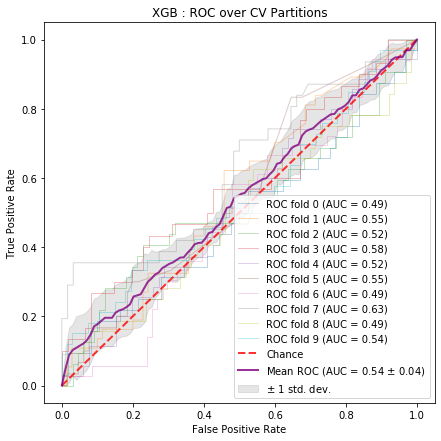

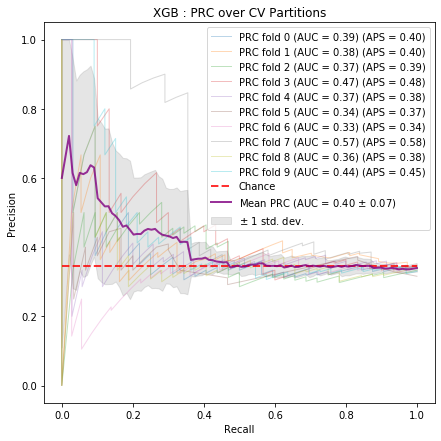

Avg. Model Balanced Accuracy = 0.5184010801195246 (std. dev. = 0.023257660762394147)
Avg. Model Accuracy = 0.5982298813880711 (std. dev. = 0.0508091500993125)
Avg. Model F1-Score = 0.308654295969408 (std. dev. = 0.054192394230534034)
Avg. Model Recall = 0.277747041658332 (std. dev. = 0.08900181623371384)
Avg. Model Specificity = 0.7590551185807175 (std. dev. = 0.11316206281337275)
Avg. Model Precision = 0.38838827105108437 (std. dev. = 0.07220801879409405)
Avg. Model True Positives = 9.1 (std. dev. = 2.947880594596735)
Avg. Model True Negatives = 49.5 (std. dev. = 7.671375365604267)
Avg. Model False Positives = 15.7 (std. dev. = 7.239475119095307)
Avg. Model False Negatives = 23.7 (std. dev. = 3.4365680554879163)
Avg. ROC AUC = 0.5349629098860994 (std. dev. = 0.04160477521229926)
Avg. PRC AUC = 0.40385457982248074 (std. dev. = 0.06989303713116277)
Avg. PRC Precision Score = 0.41748952539077366 (std. dev. = 0.06589992221177052)

---Feature Importances---



Names    Scores
1            cig_stop  0.012514
32      total_Marital  0.010274
27  liver_comorbidity  0.006831
0            cig_stat  0.006576
5        total_fatadj  0.006389
16           bmi_curr  0.006314
25             ibuppd  0.005847
2           cig_years  0.005436
33            occupat  0.005052
7        totalcarbadj  0.004897
24               ibup  0.004496
26         gallblad_f  0.004496
30             educat  0.004361
11      total_GlyLoad  0.004149
35            rndyear  0.003945
13    Totalredmeatadj  0.003883
3          pack_years  0.003721
34             center  0.003701
8    total_proteinadj  0.003517
31              race7  0.003450

XGBoost Run Time: 1047.6246118545532


In [56]:
algorithm = 'XGB'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('XGBoost Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run LGBoost

Running LGB
Best trial:
  Value:  0.5598223856019361
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 20
    max_depth: 25
    lambda_l1: 1.461733224447093
    lambda_l2: 4.883486828815964
    feature_fraction: 0.8853280498135566
    bagging_fraction: 0.929271044447085
    bagging_freq: 1
    min_child_samples: 29
    n_estimators: 488
    scale_pos_weight: 1.0



Running LGB
Best trial:
  Value:  0.5678694158075601
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 27
    max_depth: 1
    lambda_l1: 0.055797548184049715
    lambda_l2: 0.00020305444287627765
    feature_fraction: 0.6727477092623718
    bagging_fraction: 0.44498641008877954
    bagging_freq: 6
    min_child_samples: 63
    n_estimators: 19
    scale_pos_weight: 2.0



Running LGB
Best trial:
  Value:  0.5791494220065648
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 231
    max_depth: 17
    lambda_l1: 3.1374332826336256e-05
    lambda_l2: 0.3314818127456908
    feature_fraction: 0.6551674474240401
    bagging_fraction: 0.6528622508558136
    bagging_freq: 2
    min_child_samples: 90
    n_estimators: 13
    scale_pos_weight: 1.9797297297297298



Running LGB
Best trial:
  Value:  0.5763142422533285
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 236
    max_depth: 15
    lambda_l1: 0.4376333575635439
    lambda_l2: 2.866687134714906e-07
    feature_fraction: 0.6670770934624217
    bagging_fraction: 0.5406248808465155
    bagging_freq: 1
    min_child_samples: 86
    n_estimators: 14
    scale_pos_weight: 1.983221476510067



Running LGB
Best trial:
  Value:  0.5895559439742062
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 92
    max_depth: 1
    lambda_l1: 1.3945894754536206
    lambda_l2: 0.08445700304998983
    feature_fraction: 0.6824215108139389
    bagging_fraction: 0.5529888073268671
    bagging_freq: 6
    min_child_samples: 46
    n_estimators: 507
    scale_pos_weight: 2.0



Running LGB
Best trial:
  Value:  0.5844213458499173
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 51
    max_depth: 1
    lambda_l1: 0.0005983870621973257
    lambda_l2: 2.528533122487162e-05
    feature_fraction: 0.6244251285553774
    bagging_fraction: 0.7630164175428802
    bagging_freq: 4
    min_child_samples: 63
    n_estimators: 33
    scale_pos_weight: 1.9697986577181208



Running LGB
Best trial:
  Value:  0.538488463063234
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 50
    max_depth: 9
    lambda_l1: 0.0003233345026050254
    lambda_l2: 8.938027464198472e-08
    feature_fraction: 0.8883471097514407
    bagging_fraction: 0.6214544466248275
    bagging_freq: 6
    min_child_samples: 65
    n_estimators: 707
    scale_pos_weight: 1.9897260273972603



Running LGB
Best trial:
  Value:  0.5805360574214816
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 2
    max_depth: 8
    lambda_l1: 0.00011663802797276697
    lambda_l2: 0.13325089277806973
    feature_fraction: 0.8206051617178445
    bagging_fraction: 0.732506094490548
    bagging_freq: 4
    min_child_samples: 92
    n_estimators: 33
    scale_pos_weight: 1.9865319865319866



Running LGB
Best trial:
  Value:  0.5904769665647113
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 190
    max_depth: 28
    lambda_l1: 3.3297644128259714e-06
    lambda_l2: 0.03635504927690195
    feature_fraction: 0.5431013087808175
    bagging_fraction: 0.8802614163890491
    bagging_freq: 5
    min_child_samples: 56
    n_estimators: 45
    scale_pos_weight: 1.989864864864865



Running LGB
Best trial:
  Value:  0.5700178128749558
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 244
    max_depth: 22
    lambda_l1: 0.0003336186741830925
    lambda_l2: 0.003418368762452914
    feature_fraction: 0.6249860357560219
    bagging_fraction: 0.6038262866289856
    bagging_freq: 5
    min_child_samples: 60
    n_estimators: 22
    scale_pos_weight: 1.9830508474576272


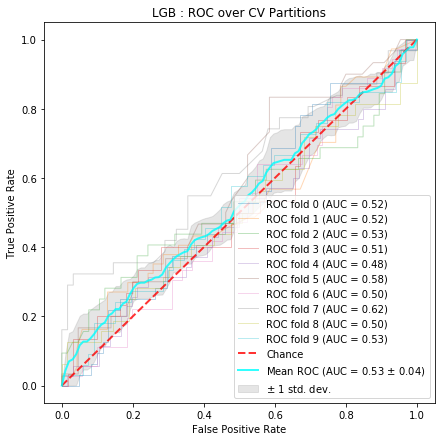

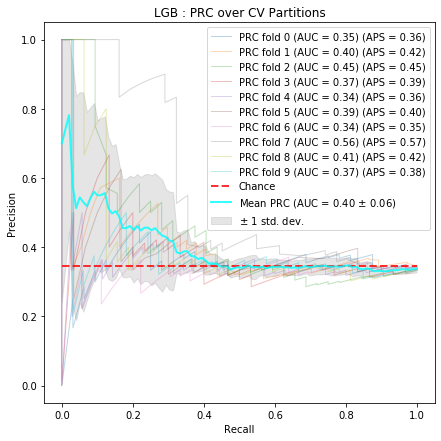

Avg. Model Balanced Accuracy = 0.5241669610764628 (std. dev. = 0.029463710941718797)
Avg. Model Accuracy = 0.5924624152014306 (std. dev. = 0.04083213852141951)
Avg. Model F1-Score = 0.34006624101772404 (std. dev. = 0.05546437465924962)
Avg. Model Recall = 0.3199552568907407 (std. dev. = 0.08221547352664926)
Avg. Model Specificity = 0.7283786652621848 (std. dev. = 0.08126736616228109)
Avg. Model Precision = 0.37546194711110503 (std. dev. = 0.0422593451011079)
Avg. Model True Positives = 10.5 (std. dev. = 2.80178514522438)
Avg. Model True Negatives = 47.5 (std. dev. = 5.953990258641679)
Avg. Model False Positives = 17.7 (std. dev. = 5.404627646748664)
Avg. Model False Negatives = 22.3 (std. dev. = 3.1)
Avg. ROC AUC = 0.5283959757003518 (std. dev. = 0.03825135854809688)
Avg. PRC AUC = 0.3983095133428159 (std. dev. = 0.06305159232121467)
Avg. PRC Precision Score = 0.41029091406304874 (std. dev. = 0.05932012047138985)

---Feature Importances---



Names    Scores
1           cig_stop  0.015437
26        gallblad_f  0.015110
33           occupat  0.014134
30            educat  0.012470
23             asppd  0.011750
3         pack_years  0.011497
24              ibup  0.011385
29          agelevel  0.011283
14   totalCALCIUMadj  0.010618
17        diabetes_f  0.010501
8   total_proteinadj  0.010120
25            ibuppd  0.009235
15          bmi_curc  0.009187
5       total_fatadj  0.009168
6           tot_Kcal  0.008772
22               asp  0.008377
32     total_Marital  0.007572
0           cig_stat  0.007482
13   Totalredmeatadj  0.007143
20            bmi_20  0.007140

LGBoost Run Time: 438.0280499458313


In [57]:
algorithm = 'LGB'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('LGBoost Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run SVM

Running SVM
Best trial:
  Value:  0.5621996581024863
  Params: 
    kernel: rbf
    C: 0.526254426924526
    gamma: scale
    degree: 4
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5756013745704467
  Params: 
    kernel: rbf
    C: 0.10226255669833977
    gamma: scale
    degree: 2
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5708314172599888
  Params: 
    kernel: rbf
    C: 0.5077079167429801
    gamma: scale
    degree: 5
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5801628809243023
  Params: 
    kernel: poly
    C: 0.11079186889422088
    gamma: scale
    degree: 1
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5777209535677872
  Params: 
    kernel: linear
    C: 6.084332734672742
    gamma: scale
    degree: 3
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.577551813266099
  Params: 
    kernel: poly
    C: 0.10458255902901811
    gamma: scale
    degree: 1
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5536396065824439
  Params: 
    kernel: rbf
    C: 0.12541190936553082
    gamma: scale
    degree: 5
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5689230699201693
  Params: 
    kernel: rbf
    C: 1.575259071200788
    gamma: scale
    degree: 4
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5664272041175594
  Params: 
    kernel: rbf
    C: 0.10067048503251556
    gamma: scale
    degree: 4
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.5741361812790384
  Params: 
    kernel: poly
    C: 1.556782722375942
    gamma: scale
    degree: 1
    probability: True
    class_weight: balanced


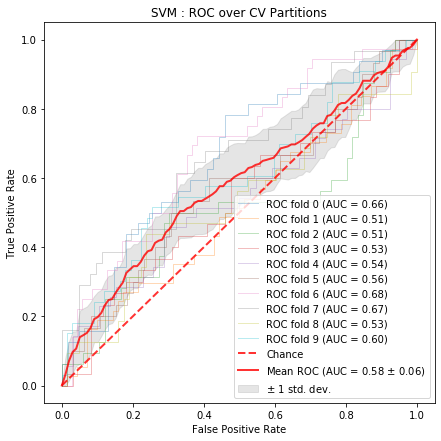

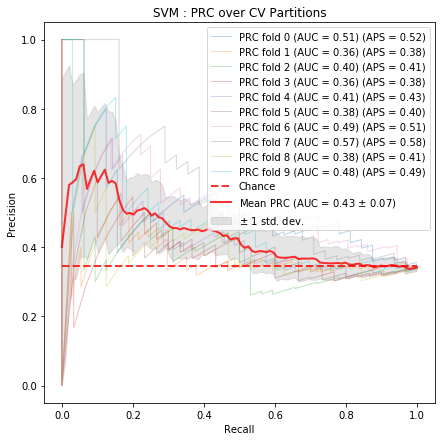

Avg. Model Balanced Accuracy = 0.5669417614354298 (std. dev. = 0.05340076425472406)
Avg. Model Accuracy = 0.5932143878180342 (std. dev. = 0.06210338978399247)
Avg. Model F1-Score = 0.443552929807456 (std. dev. = 0.07006434897037557)
Avg. Model Recall = 0.49068469522098557 (std. dev. = 0.10965773699914146)
Avg. Model Specificity = 0.6431988276498741 (std. dev. = 0.1075103697124875)
Avg. Model Precision = 0.4141455149217078 (std. dev. = 0.0594918560434134)
Avg. Model True Positives = 16.2 (std. dev. = 4.190465367951393)
Avg. Model True Negatives = 41.9 (std. dev. = 7.020683727387241)
Avg. Model False Positives = 23.3 (std. dev. = 7.142128534267638)
Avg. Model False Negatives = 16.6 (std. dev. = 3.32264954516723)
Avg. ROC AUC = 0.5794944374187727 (std. dev. = 0.06456014548328647)
Avg. PRC AUC = 0.43419115765136074 (std. dev. = 0.06906892652575278)
Avg. PRC Precision Score = 0.4494559672013653 (std. dev. = 0.06545199666863308)

---Feature Importances---



Names    Scores
17       diabetes_f  0.019261
2         cig_years  0.017689
1          cig_stop  0.013076
26       gallblad_f  0.011804
29         agelevel  0.010600
33          occupat  0.009939
15         bmi_curc  0.009804
3        pack_years  0.009603
30           educat  0.009016
10   total_GlyIndex  0.007117
0          cig_stat  0.005938
16         bmi_curr  0.005851
31            race7  0.005707
4      total_alcadj  0.005402
21           bmi_50  0.005142
25           ibuppd  0.003926
11    total_GlyLoad  0.003745
13  Totalredmeatadj  0.003729
19        fh_cancer  0.003615
35          rndyear  0.003256

SVM Run Time: 2801.1137437820435


In [58]:
algorithm = 'SVM'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('SVM Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run ANN

Running ANN
Best trial:
  Value:  0.5615327451803159
  Params: 
    activation: tanh
    learning_rate: constant
    momentum: 0.19874146295474004
    solver: adam
    batch_size: auto
    alpha: 0.0016090827504002558
    max_iter: 200
    n_layers: 3
    n_units_l0: 90
    n_units_l1: 19
    n_units_l2: 3



Running ANN
Best trial:
  Value:  0.5601374570446737
  Params: 
    activation: logistic
    learning_rate: invscaling
    momentum: 0.10392495901296517
    solver: adam
    batch_size: auto
    alpha: 0.0395834336111734
    max_iter: 200
    n_layers: 2
    n_units_l0: 94
    n_units_l1: 41



Running ANN
Best trial:
  Value:  0.5627675234818093
  Params: 
    activation: logistic
    learning_rate: constant
    momentum: 0.6865189175336691
    solver: adam
    batch_size: auto
    alpha: 0.0014902933998383083
    max_iter: 200
    n_layers: 2
    n_units_l0: 63
    n_units_l1: 1



Running ANN
Best trial:
  Value:  0.5575772103437079
  Params: 
    activation: identity
    learning_rate: adaptive
    momentum: 0.6987870874646185
    solver: sgd
    batch_size: auto
    alpha: 0.008866975832340744
    max_iter: 200
    n_layers: 2
    n_units_l0: 49
    n_units_l1: 61



Running ANN
Best trial:
  Value:  0.5658001873760342
  Params: 
    activation: identity
    learning_rate: invscaling
    momentum: 0.25033594682875004
    solver: adam
    batch_size: auto
    alpha: 0.014824832233663038
    max_iter: 200
    n_layers: 1
    n_units_l0: 2



Running ANN
Best trial:
  Value:  0.5528048406619835
  Params: 
    activation: logistic
    learning_rate: adaptive
    momentum: 0.6118741416335314
    solver: adam
    batch_size: auto
    alpha: 0.00010652134325439303
    max_iter: 200
    n_layers: 3
    n_units_l0: 46
    n_units_l1: 64
    n_units_l2: 83



Running ANN
Best trial:
  Value:  0.5562833327337665
  Params: 
    activation: logistic
    learning_rate: constant
    momentum: 0.5492656126341215
    solver: adam
    batch_size: auto
    alpha: 0.012789261499651608
    max_iter: 200
    n_layers: 2
    n_units_l0: 76
    n_units_l1: 7



Running ANN
Best trial:
  Value:  0.5494492649133694
  Params: 
    activation: logistic
    learning_rate: adaptive
    momentum: 0.32970588470711043
    solver: adam
    batch_size: auto
    alpha: 0.03381620742646437
    max_iter: 200
    n_layers: 2
    n_units_l0: 98
    n_units_l1: 65



Running ANN
Best trial:
  Value:  0.5579911654966042
  Params: 
    activation: logistic
    learning_rate: adaptive
    momentum: 0.18392846499011817
    solver: adam
    batch_size: auto
    alpha: 0.005528533626855998
    max_iter: 200
    n_layers: 2
    n_units_l0: 84
    n_units_l1: 40



Running ANN
Best trial:
  Value:  0.5594281379995666
  Params: 
    activation: identity
    learning_rate: constant
    momentum: 0.10734065361811324
    solver: sgd
    batch_size: auto
    alpha: 0.012837197468856488
    max_iter: 200
    n_layers: 2
    n_units_l0: 77
    n_units_l1: 62


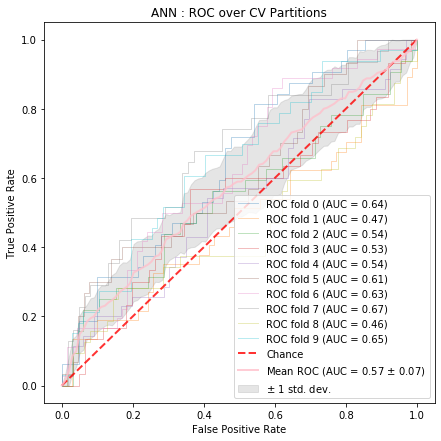

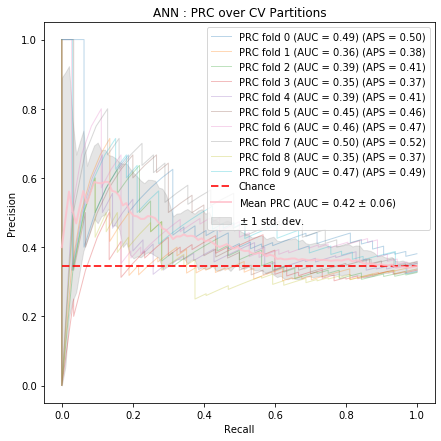

Avg. Model Balanced Accuracy = 0.5467702067557652 (std. dev. = 0.015354529955732638)
Avg. Model Accuracy = 0.6591691065947999 (std. dev. = 0.027217320217838292)
Avg. Model F1-Score = 0.2832772959009162 (std. dev. = 0.05736455453258528)
Avg. Model Recall = 0.2081463336503659 (std. dev. = 0.07182089894339316)
Avg. Model Specificity = 0.8853940798611643 (std. dev. = 0.0657801662166137)
Avg. Model Precision = 0.507618411000764 (std. dev. = 0.0980392281359276)
Avg. Model True Positives = 6.8 (std. dev. = 2.2715633383201093)
Avg. Model True Negatives = 57.8 (std. dev. = 5.912698199637794)
Avg. Model False Positives = 7.4 (std. dev. = 4.079215610874228)
Avg. Model False Negatives = 26.0 (std. dev. = 3.255764119219941)
Avg. ROC AUC = 0.5737997711442897 (std. dev. = 0.07236736903404979)
Avg. PRC AUC = 0.4213125148400715 (std. dev. = 0.056941445246696885)
Avg. PRC Precision Score = 0.4372552218052004 (std. dev. = 0.05528911113452649)

---Feature Importances---



Names    Scores
1           cig_stop  0.026774
36               sex  0.018104
0           cig_stat  0.018073
13   Totalredmeatadj  0.017676
17        diabetes_f  0.017347
33           occupat  0.017274
18           panc_fh  0.015918
3         pack_years  0.014360
24              ibup  0.013910
25            ibuppd  0.013062
31             race7  0.012860
7       totalcarbadj  0.012196
35           rndyear  0.011695
29          agelevel  0.011690
14   totalCALCIUMadj  0.011344
4       total_alcadj  0.010382
8   total_proteinadj  0.009849
26        gallblad_f  0.009394
2          cig_years  0.009187
5       total_fatadj  0.009083

ANN Run Time: 1360.6948790550232


In [59]:
algorithm = 'ANN'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('ANN Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run LCS

In [60]:
def makeConfigFile(train_dataset,test_dataset,outpath,external_ek_file,iterations,popsize,configfile,outcomelabel,instancelabel,discthresh):
    """ Construct Configuration File for CV Analysis """
    configFile = open(configfile,'w')
    
    #Write to Config File#############################################################################################################
    configFile.write('offlineData=1# \n')
    configFile.write('trainFile='+str(train_dataset)+'# \n')
    configFile.write('testFile='+str(test_dataset)+'# \n')
    configFile.write('internalCrossValidation=0# \n')
    
    configFile.write('outFileName='+str(outpath)+'# \n')
    configFile.write('randomSeed=1# \n')
    configFile.write('labelInstanceID='+str(instancelabel)+'# \n')
    configFile.write('labelPhenotype='+str(outcomelabel)+'# \n')
    configFile.write('discreteAttributeLimit='+str(discthresh)+'# \n')
    configFile.write('labelMissingData=NA# \n')
    configFile.write('outputSummary=1# \n')
    configFile.write('outputPopulation=1# \n')
    configFile.write('outputAttCoOccur=1# \n')
    configFile.write('outputTestPredictions=1# \n')  
    configFile.write('maxAttsCoOccur=50# \n')
        
    configFile.write('trackingFrequency=0# \n')
    configFile.write('learningIterations='+str(iterations)+'# \n')
    
    configFile.write('N='+str(popsize)+'# \n') 
    configFile.write('nu=1# \n')
    configFile.write('chi=0.8# \n')
    configFile.write('upsilon=0.04# \n')
    configFile.write('theta_GA=25# \n')
    configFile.write('theta_del=20# \n')   
    configFile.write('theta_sub=20# \n')    
    configFile.write('acc_sub=0.99# \n')    
    configFile.write('beta=0.2# \n')         
    configFile.write('delta=0.1# \n')     
    configFile.write('init_fit=0.01# \n')
    configFile.write('fitnessReduction=0.1# \n')
    configFile.write('theta_sel=0.5# \n')
    configFile.write('RSL_Override=0# \n')

    configFile.write('doSubsumption=1# \n')
    configFile.write('selectionMethod=tournament# \n')
    
    configFile.write('doAttributeTracking=1# \n')
    configFile.write('doAttributeFeedback=1# \n')
    
    configFile.write('useExpertKnowledge=1# \n')
    configFile.write('external_EK_Generation='+str(external_ek_file)+'# \n')
    configFile.write('outEKFileName=None# \n')
    
    configFile.write('filterAlgorithm=None# \n')
    configFile.write('turfPercent=0.2# \n')
    configFile.write('reliefNeighbors=10# \n')
    configFile.write('reliefSampleFraction=1# \n')
    configFile.write('onlyEKScores=0# \n')
    
    configFile.write('doRuleCompaction=1# \n')
    configFile.write('onlyRC=0# \n')
    configFile.write('ruleCompactionMethod=QRF# \n')
    
    configFile.write('doPopulationReboot=0# \n')
    configFile.write('popRebootIteration=0# \n')
    
    configFile.close()

### Generate LCS Configuration Files (needed to pass all run/hyperparamters)

In [61]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    start_time = time.time()
    # Generate LCS configuration files (needed to pass all run/hyper parameters to LCS)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        trainFile = wd_path+cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt'
        testFile = wd_path+cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt'
        ekFile = wd_path+output_folder+'/'+'multisurf'+'_'+data_name+'_'+str(i)+'_Train.txt'
        configfile = wd_path+lcs_folder+'/'+lcs_alg+'_'+data_name+'_'+str(i)+'_Train_ConfigFile.txt'
        outFold = wd_path+lcs_folder+'/'

        makeConfigFile(trainFile,testFile,outFold,ekFile,iterations,popsize,configfile,outcomeLabel,instLabel,categoricalCutoff)

In [62]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    #Use Python Magic to run Exstracs from command line
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #lcs_path = 'exstracs_2.0.2.1_noclassmutate_lynch'+'/'+'exstracs_main.py'
        configFile = wd_path+lcs_folder+'/'+lcs_alg+'_'+data_name+'_'+str(i)+'_Train_ConfigFile.txt'
        %run {lcs_path} {configFile}

----------------------------------------------------------------------------
Environment: Formatting Data... 
DataManagement: Loading Data... C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_Epi_DietAdj_Matched/cv_datasets/Epi_DietAdj_Matched_20180710_clean_scale_imp_CV_M_FS_0_Train.txt
DataManagement: Instance ID Column location = 1
DataManagement: Phenotype Column Location = 0
DataManagement: Number of Attributes = 29
DataManagement: Number of Instances = 887
DataManagement: Loading Data... C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_Epi_DietAdj_Matched/cv_datasets/Epi_DietAdj_Matched_20180710_clean_scale_imp_CV_M_FS_0_Test.txt
DataManagement: Number of Attributes = 29
DataManagement: Number of Instances = 93
DataManagement: Analyzing Phenotype...
DataManagement: Phenotype Detected as Discrete.
DataManagement: Detecting Classes...
DataManagement: Following Classes Detected:
['0', '1']
Class: 0 count = 591
Class: 1 count = 296

Epoch: 38	 Iteration: 33706	 MacroPop: 1927	 MicroPop: 2000	 AccEstimate: 0.7373167981961668	 AveGen: 0.8341206896551485	 ExpRules: 0.6408925791385574	 Time: 2.5455507198969523
Epoch: 39	 Iteration: 34593	 MacroPop: 1918	 MicroPop: 2000	 AccEstimate: 0.741826381059752	 AveGen: 0.8337413793103207	 ExpRules: 0.6553701772679875	 Time: 2.6189061403274536
Epoch: 40	 Iteration: 35480	 MacroPop: 1929	 MicroPop: 2000	 AccEstimate: 0.7361894024802705	 AveGen: 0.8347931034482524	 ExpRules: 0.6283048211508554	 Time: 2.689533829689026
Epoch: 41	 Iteration: 36367	 MacroPop: 1923	 MicroPop: 2000	 AccEstimate: 0.7249154453213078	 AveGen: 0.8348620689654936	 ExpRules: 0.6302652106084243	 Time: 2.7617078542709352
Epoch: 42	 Iteration: 37254	 MacroPop: 1930	 MicroPop: 2000	 AccEstimate: 0.705749718151071	 AveGen: 0.8351379310344593	 ExpRules: 0.6264248704663212	 Time: 2.8331793824831646
Epoch: 43	 Iteration: 38141	 MacroPop: 1941	 MicroPop: 2000	 AccEstimate: 0.7237880496054115	 AveGen: 0.83425862068963

Epoch: 84	 Iteration: 74508	 MacroPop: 1877	 MicroPop: 2000	 AccEstimate: 0.7474633596392334	 AveGen: 0.8434310344827363	 ExpRules: 0.6542354821523708	 Time: 5.765747888882955
Epoch: 85	 Iteration: 75395	 MacroPop: 1865	 MicroPop: 2000	 AccEstimate: 0.7531003382187148	 AveGen: 0.8438965517241156	 ExpRules: 0.6616621983914209	 Time: 5.8326543490091955
Epoch: 86	 Iteration: 76282	 MacroPop: 1868	 MicroPop: 2000	 AccEstimate: 0.7497181510710259	 AveGen: 0.8435172413792877	 ExpRules: 0.6568522483940042	 Time: 5.899608107407888
Epoch: 87	 Iteration: 77169	 MacroPop: 1872	 MicroPop: 2000	 AccEstimate: 0.7531003382187148	 AveGen: 0.844327586206874	 ExpRules: 0.6693376068376068	 Time: 5.965973309675852
Epoch: 88	 Iteration: 78056	 MacroPop: 1880	 MicroPop: 2000	 AccEstimate: 0.7373167981961668	 AveGen: 0.8435689655172185	 ExpRules: 0.6627659574468086	 Time: 6.032162972291311
Epoch: 89	 Iteration: 78943	 MacroPop: 1885	 MicroPop: 2000	 AccEstimate: 0.7282976324689966	 AveGen: 0.8432931034482531

Epoch: 130	 Iteration: 115310	 MacroPop: 1883	 MicroPop: 2000	 AccEstimate: 0.7474633596392334	 AveGen: 0.8457758620689433	 ExpRules: 0.6802973977695167	 Time: 8.856393710772197
Epoch: 131	 Iteration: 116197	 MacroPop: 1890	 MicroPop: 2000	 AccEstimate: 0.7531003382187148	 AveGen: 0.84563793103446	 ExpRules: 0.6894179894179894	 Time: 8.930346393585205
Epoch: 132	 Iteration: 117084	 MacroPop: 1878	 MicroPop: 2000	 AccEstimate: 0.7598647125140925	 AveGen: 0.8465689655172197	 ExpRules: 0.6762513312034079	 Time: 9.005162791411083
Epoch: 133	 Iteration: 117971	 MacroPop: 1866	 MicroPop: 2000	 AccEstimate: 0.7474633596392334	 AveGen: 0.8474655172413574	 ExpRules: 0.6843515541264737	 Time: 9.079464169343312
Epoch: 134	 Iteration: 118858	 MacroPop: 1870	 MicroPop: 2000	 AccEstimate: 0.7350620067643743	 AveGen: 0.8475517241379092	 ExpRules: 0.681283422459893	 Time: 9.15348225037257
Epoch: 135	 Iteration: 119745	 MacroPop: 1864	 MicroPop: 2000	 AccEstimate: 0.7316798196166855	 AveGen: 0.84731034

Epoch: 176	 Iteration: 156112	 MacroPop: 1820	 MicroPop: 2000	 AccEstimate: 0.733934611048478	 AveGen: 0.8569655172413588	 ExpRules: 0.7203296703296703	 Time: 12.034582368532817
Epoch: 177	 Iteration: 156999	 MacroPop: 1805	 MicroPop: 2000	 AccEstimate: 0.7316798196166855	 AveGen: 0.8594482758620486	 ExpRules: 0.7008310249307479	 Time: 12.095984331766765
Epoch: 178	 Iteration: 157886	 MacroPop: 1806	 MicroPop: 2000	 AccEstimate: 0.741826381059752	 AveGen: 0.8606379310344626	 ExpRules: 0.7070874861572536	 Time: 12.156854820251464
Epoch: 179	 Iteration: 158773	 MacroPop: 1798	 MicroPop: 2000	 AccEstimate: 0.7406989853438557	 AveGen: 0.8610689655172212	 ExpRules: 0.7063403781979978	 Time: 12.218545055389404
Epoch: 180	 Iteration: 159660	 MacroPop: 1784	 MicroPop: 2000	 AccEstimate: 0.7034949267192785	 AveGen: 0.8605689655172212	 ExpRules: 0.7135650224215246	 Time: 12.278817208607991
Epoch: 181	 Iteration: 160547	 MacroPop: 1793	 MicroPop: 2000	 AccEstimate: 0.6933483652762119	 AveGen: 0.8

Epoch: 221	 Iteration: 196027	 MacroPop: 1757	 MicroPop: 2000	 AccEstimate: 0.7350620067643743	 AveGen: 0.8662586206896351	 ExpRules: 0.7313602731929425	 Time: 14.687066829204559
Epoch: 222	 Iteration: 196914	 MacroPop: 1755	 MicroPop: 2000	 AccEstimate: 0.7305524239007892	 AveGen: 0.8668965517241183	 ExpRules: 0.7213675213675214	 Time: 14.745277714729308
Epoch: 223	 Iteration: 197801	 MacroPop: 1747	 MicroPop: 2000	 AccEstimate: 0.733934611048478	 AveGen: 0.8651896551723935	 ExpRules: 0.728677733257012	 Time: 14.8033744653066
Epoch: 224	 Iteration: 198688	 MacroPop: 1762	 MicroPop: 2000	 AccEstimate: 0.7249154453213078	 AveGen: 0.8658965517241182	 ExpRules: 0.7122587968217934	 Time: 14.862004232406616
Epoch: 225	 Iteration: 199575	 MacroPop: 1740	 MicroPop: 2000	 AccEstimate: 0.7204058624577226	 AveGen: 0.8656206896551532	 ExpRules: 0.7218390804597701	 Time: 14.919882722695668
-------------------------------------------------------------------------------------------------------------

Epoch: 19	 Iteration: 16587	 MacroPop: 1937	 MicroPop: 2000	 AccEstimate: 0.7044673539518901	 AveGen: 0.7998148148148169	 ExpRules: 0.6768198244708312	 Time: 1.0557825128237406
Epoch: 20	 Iteration: 17460	 MacroPop: 1934	 MicroPop: 2000	 AccEstimate: 0.7067583046964491	 AveGen: 0.8000740740740777	 ExpRules: 0.6695966907962771	 Time: 1.125496006011963
Epoch: 21	 Iteration: 18333	 MacroPop: 1929	 MicroPop: 2000	 AccEstimate: 0.711340206185567	 AveGen: 0.8002037037037076	 ExpRules: 0.6832555728356662	 Time: 1.194793434937795
Epoch: 22	 Iteration: 19206	 MacroPop: 1927	 MicroPop: 2000	 AccEstimate: 0.7147766323024055	 AveGen: 0.7987962962962982	 ExpRules: 0.6746237675142709	 Time: 1.2639271457990011
Epoch: 23	 Iteration: 20079	 MacroPop: 1932	 MicroPop: 2000	 AccEstimate: 0.7250859106529209	 AveGen: 0.798222222222223	 ExpRules: 0.6635610766045549	 Time: 1.3331419785817464
Epoch: 24	 Iteration: 20952	 MacroPop: 1942	 MicroPop: 2000	 AccEstimate: 0.7250859106529209	 AveGen: 0.795814814814814

Epoch: 65	 Iteration: 56745	 MacroPop: 1924	 MicroPop: 2000	 AccEstimate: 0.7342497136311569	 AveGen: 0.8004814814814848	 ExpRules: 0.6294178794178794	 Time: 4.270350591341654
Epoch: 66	 Iteration: 57618	 MacroPop: 1919	 MicroPop: 2000	 AccEstimate: 0.7285223367697594	 AveGen: 0.799759259259263	 ExpRules: 0.6545075560187598	 Time: 4.339335123697917
Epoch: 67	 Iteration: 58491	 MacroPop: 1914	 MicroPop: 2000	 AccEstimate: 0.7468499427262314	 AveGen: 0.8005000000000053	 ExpRules: 0.6426332288401254	 Time: 4.407120092709859
Epoch: 68	 Iteration: 59364	 MacroPop: 1912	 MicroPop: 2000	 AccEstimate: 0.7434135166093929	 AveGen: 0.8027777777777838	 ExpRules: 0.6516736401673641	 Time: 4.4750384052594505
Epoch: 69	 Iteration: 60237	 MacroPop: 1912	 MicroPop: 2000	 AccEstimate: 0.7353951890034365	 AveGen: 0.8028703703703748	 ExpRules: 0.6521966527196653	 Time: 4.54209178686142
Epoch: 70	 Iteration: 61110	 MacroPop: 1894	 MicroPop: 2000	 AccEstimate: 0.7331042382588774	 AveGen: 0.8007592592592627	

Epoch: 111	 Iteration: 96903	 MacroPop: 1886	 MicroPop: 2000	 AccEstimate: 0.7537227949599083	 AveGen: 0.8069259259259303	 ExpRules: 0.6664899257688229	 Time: 7.3281378189722695
Epoch: 112	 Iteration: 97776	 MacroPop: 1879	 MicroPop: 2000	 AccEstimate: 0.7651775486827033	 AveGen: 0.8073518518518594	 ExpRules: 0.6673762639701969	 Time: 7.392266233762105
Epoch: 113	 Iteration: 98649	 MacroPop: 1869	 MicroPop: 2000	 AccEstimate: 0.7502863688430699	 AveGen: 0.8075925925925987	 ExpRules: 0.6698769395398609	 Time: 7.456460638840993
Epoch: 114	 Iteration: 99522	 MacroPop: 1870	 MicroPop: 2000	 AccEstimate: 0.7594501718213058	 AveGen: 0.8073888888888938	 ExpRules: 0.6663101604278074	 Time: 7.520688807964325
Epoch: 115	 Iteration: 100395	 MacroPop: 1883	 MicroPop: 2000	 AccEstimate: 0.7617411225658648	 AveGen: 0.8098703703703753	 ExpRules: 0.6569304301646309	 Time: 7.5880793531735735
Epoch: 116	 Iteration: 101268	 MacroPop: 1878	 MicroPop: 2000	 AccEstimate: 0.7560137457044673	 AveGen: 0.807870

Epoch: 157	 Iteration: 137061	 MacroPop: 1848	 MicroPop: 2000	 AccEstimate: 0.7525773195876289	 AveGen: 0.8137962962963017	 ExpRules: 0.6829004329004329	 Time: 10.247288076082866
Epoch: 158	 Iteration: 137934	 MacroPop: 1837	 MicroPop: 2000	 AccEstimate: 0.7594501718213058	 AveGen: 0.8153333333333387	 ExpRules: 0.6951551442569407	 Time: 10.309074648221333
Epoch: 159	 Iteration: 138807	 MacroPop: 1834	 MicroPop: 2000	 AccEstimate: 0.738831615120275	 AveGen: 0.8153333333333401	 ExpRules: 0.6723009814612868	 Time: 10.371165549755096
Epoch: 160	 Iteration: 139680	 MacroPop: 1831	 MicroPop: 2000	 AccEstimate: 0.7560137457044673	 AveGen: 0.8151111111111203	 ExpRules: 0.6865101037684326	 Time: 10.432767828305563
Epoch: 161	 Iteration: 140553	 MacroPop: 1850	 MicroPop: 2000	 AccEstimate: 0.7605956471935853	 AveGen: 0.8167037037037107	 ExpRules: 0.6772972972972973	 Time: 10.49495145479838
Epoch: 162	 Iteration: 141426	 MacroPop: 1826	 MicroPop: 2000	 AccEstimate: 0.7617411225658648	 AveGen: 0.8

Epoch: 202	 Iteration: 176346	 MacroPop: 1809	 MicroPop: 2000	 AccEstimate: 0.7583046964490263	 AveGen: 0.8248148148148213	 ExpRules: 0.7009397457158651	 Time: 12.993845280011495
Epoch: 203	 Iteration: 177219	 MacroPop: 1809	 MicroPop: 2000	 AccEstimate: 0.7594501718213058	 AveGen: 0.8247037037037123	 ExpRules: 0.689331122166943	 Time: 13.054151026407878
Epoch: 204	 Iteration: 178092	 MacroPop: 1818	 MicroPop: 2000	 AccEstimate: 0.7525773195876289	 AveGen: 0.8254074074074149	 ExpRules: 0.6952695269526953	 Time: 13.115586666266124
Epoch: 205	 Iteration: 178965	 MacroPop: 1811	 MicroPop: 2000	 AccEstimate: 0.7548682703321878	 AveGen: 0.8245555555555637	 ExpRules: 0.6858089453340696	 Time: 13.176606833934784
Epoch: 206	 Iteration: 179838	 MacroPop: 1796	 MicroPop: 2000	 AccEstimate: 0.7548682703321878	 AveGen: 0.8252407407407492	 ExpRules: 0.7121380846325167	 Time: 13.236263831456503
Epoch: 207	 Iteration: 180711	 MacroPop: 1795	 MicroPop: 2000	 AccEstimate: 0.7571592210767468	 AveGen: 0.

DataManagement: Phenotype Detected as Discrete.
DataManagement: Detecting Classes...
DataManagement: Following Classes Detected:
['0', '1']
Class: 0 count = 586
Class: 1 count = 296
{'0': 0.3356009070294784, '1': 0.6643990929705215}
DataManagement: Detecting Attributes...
DataManagement: Identified 18 discrete and 12 continuous attributes.
DataManagement: Characterizing Attributes...
DataManagement: Estimating Classifier Specification Limit
DataManagement: Specification Limit = 6
----------------------------------------------------------------------------
ExSTraCS: Initializing Algorithm...
ExpertKnowledge: Loading external EK.
EK File Loaded.
Beginning ExSTraCS learning iterations.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1	 Iteration: 882	 MacroPop: 210	 MicroPop: 232	 AccEstimate: 0.5249433106575964	 AveGen: 0.9018678160919564	 ExpRules: 0.0	 Time: 0.00643329620361328

Epoch: 42	 Iteration: 37044	 MacroPop: 1931	 MicroPop: 2000	 AccEstimate: 0.7210884353741497	 AveGen: 0.8364999999999795	 ExpRules: 0.6307612635939928	 Time: 2.8507399042447408
Epoch: 43	 Iteration: 37926	 MacroPop: 1928	 MicroPop: 2000	 AccEstimate: 0.7222222222222222	 AveGen: 0.8363999999999788	 ExpRules: 0.6358921161825726	 Time: 2.9319559494654337
Epoch: 44	 Iteration: 38808	 MacroPop: 1933	 MicroPop: 2000	 AccEstimate: 0.7346938775510204	 AveGen: 0.8365666666666457	 ExpRules: 0.6373512674599069	 Time: 3.0117091655731203
Epoch: 45	 Iteration: 39690	 MacroPop: 1945	 MicroPop: 2000	 AccEstimate: 0.7414965986394558	 AveGen: 0.8369333333333141	 ExpRules: 0.632904884318766	 Time: 3.091960672537486
Epoch: 46	 Iteration: 40572	 MacroPop: 1934	 MicroPop: 2000	 AccEstimate: 0.7494331065759637	 AveGen: 0.8373999999999814	 ExpRules: 0.6390899689762151	 Time: 3.169403918584188
Epoch: 47	 Iteration: 41454	 MacroPop: 1912	 MicroPop: 2000	 AccEstimate: 0.7426303854875284	 AveGen: 0.83851666666664

Epoch: 88	 Iteration: 77616	 MacroPop: 1915	 MicroPop: 2000	 AccEstimate: 0.7346938775510204	 AveGen: 0.8414999999999812	 ExpRules: 0.660574412532637	 Time: 6.232991969585418
Epoch: 89	 Iteration: 78498	 MacroPop: 1922	 MicroPop: 2000	 AccEstimate: 0.7324263038548753	 AveGen: 0.8413666666666472	 ExpRules: 0.6670135275754423	 Time: 6.301611455281575
Epoch: 90	 Iteration: 79380	 MacroPop: 1920	 MicroPop: 2000	 AccEstimate: 0.7210884353741497	 AveGen: 0.841883333333312	 ExpRules: 0.6526041666666667	 Time: 6.370061779022217
Epoch: 91	 Iteration: 80262	 MacroPop: 1926	 MicroPop: 2000	 AccEstimate: 0.719954648526077	 AveGen: 0.8424999999999807	 ExpRules: 0.6536863966770509	 Time: 6.439176507790884
Epoch: 92	 Iteration: 81144	 MacroPop: 1917	 MicroPop: 2000	 AccEstimate: 0.7131519274376418	 AveGen: 0.8422666666666477	 ExpRules: 0.6489306207616067	 Time: 6.5084117968877155
Epoch: 93	 Iteration: 82026	 MacroPop: 1913	 MicroPop: 2000	 AccEstimate: 0.7267573696145124	 AveGen: 0.8417499999999825	 

Epoch: 134	 Iteration: 118188	 MacroPop: 1854	 MicroPop: 2000	 AccEstimate: 0.719954648526077	 AveGen: 0.8513333333333161	 ExpRules: 0.6812297734627831	 Time: 9.35659513870875
Epoch: 135	 Iteration: 119070	 MacroPop: 1849	 MicroPop: 2000	 AccEstimate: 0.7335600907029478	 AveGen: 0.8503999999999824	 ExpRules: 0.6863169280692266	 Time: 9.425560108820598
Epoch: 136	 Iteration: 119952	 MacroPop: 1858	 MicroPop: 2000	 AccEstimate: 0.7267573696145124	 AveGen: 0.8523999999999836	 ExpRules: 0.6657696447793326	 Time: 9.496038675308228
Epoch: 137	 Iteration: 120834	 MacroPop: 1829	 MicroPop: 2000	 AccEstimate: 0.7165532879818595	 AveGen: 0.8533333333333191	 ExpRules: 0.6741388737014762	 Time: 9.568212326367696
Epoch: 138	 Iteration: 121716	 MacroPop: 1853	 MicroPop: 2000	 AccEstimate: 0.7267573696145124	 AveGen: 0.8537833333333181	 ExpRules: 0.6762007555315704	 Time: 9.639670590559641
Epoch: 139	 Iteration: 122598	 MacroPop: 1853	 MicroPop: 2000	 AccEstimate: 0.7301587301587301	 AveGen: 0.854949

Epoch: 180	 Iteration: 158760	 MacroPop: 1809	 MicroPop: 2000	 AccEstimate: 0.7233560090702947	 AveGen: 0.8588999999999858	 ExpRules: 0.6876727473742399	 Time: 12.467435940106709
Epoch: 181	 Iteration: 159642	 MacroPop: 1802	 MicroPop: 2000	 AccEstimate: 0.7267573696145124	 AveGen: 0.8603666666666515	 ExpRules: 0.6925638179800222	 Time: 12.529237254460652
Epoch: 182	 Iteration: 160524	 MacroPop: 1799	 MicroPop: 2000	 AccEstimate: 0.7278911564625851	 AveGen: 0.861433333333319	 ExpRules: 0.6876042245692051	 Time: 12.590789210796355
Epoch: 183	 Iteration: 161406	 MacroPop: 1803	 MicroPop: 2000	 AccEstimate: 0.7086167800453514	 AveGen: 0.8607499999999869	 ExpRules: 0.7049362174154188	 Time: 12.651792788505555
Epoch: 184	 Iteration: 162288	 MacroPop: 1790	 MicroPop: 2000	 AccEstimate: 0.717687074829932	 AveGen: 0.8620166666666536	 ExpRules: 0.7011173184357542	 Time: 12.712031626701355
Epoch: 185	 Iteration: 163170	 MacroPop: 1785	 MicroPop: 2000	 AccEstimate: 0.7392290249433107	 AveGen: 0.8

Epoch: 225	 Iteration: 198450	 MacroPop: 1701	 MicroPop: 2000	 AccEstimate: 0.7380952380952381	 AveGen: 0.8696499999999887	 ExpRules: 0.7319223985890653	 Time: 15.05889682372411
Epoch: 226	 Iteration: 199332	 MacroPop: 1694	 MicroPop: 2000	 AccEstimate: 0.7380952380952381	 AveGen: 0.870283333333322	 ExpRules: 0.7378984651711924	 Time: 15.113616593678792
------------------------------------------------------------------------------------------------------------------------------------------------------
Running Population Evaluation after 200000 iterations.
-----------------------------------------------
TRAINING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
656 out of 882 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.7437641723356009
Balanced Accuracy (Adjusted) = 0.715817398032497
-----------------------------------------------
TESTING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
58 ou

Epoch: 22	 Iteration: 19558	 MacroPop: 1927	 MicroPop: 2000	 AccEstimate: 0.7041619797525309	 AveGen: 0.8296607142857181	 ExpRules: 0.6419304618578101	 Time: 1.3028883576393127
Epoch: 23	 Iteration: 20447	 MacroPop: 1928	 MicroPop: 2000	 AccEstimate: 0.7109111361079865	 AveGen: 0.829482142857145	 ExpRules: 0.6649377593360996	 Time: 1.3734508554140727
Epoch: 24	 Iteration: 21336	 MacroPop: 1944	 MicroPop: 2000	 AccEstimate: 0.7052868391451068	 AveGen: 0.8295714285714315	 ExpRules: 0.6707818930041153	 Time: 1.4444287498792012
Epoch: 25	 Iteration: 22225	 MacroPop: 1942	 MicroPop: 2000	 AccEstimate: 0.7097862767154106	 AveGen: 0.8282857142857185	 ExpRules: 0.6616889804325438	 Time: 1.5155229091644287
Epoch: 26	 Iteration: 23114	 MacroPop: 1937	 MicroPop: 2000	 AccEstimate: 0.7097862767154106	 AveGen: 0.8273392857142914	 ExpRules: 0.6628807434176561	 Time: 1.5866824388504028
Epoch: 27	 Iteration: 24003	 MacroPop: 1941	 MicroPop: 2000	 AccEstimate: 0.7075365579302587	 AveGen: 0.826053571428

Epoch: 68	 Iteration: 60452	 MacroPop: 1914	 MicroPop: 2000	 AccEstimate: 0.7120359955005624	 AveGen: 0.8291964285714335	 ExpRules: 0.6619644723092999	 Time: 4.550605591138204
Epoch: 69	 Iteration: 61341	 MacroPop: 1917	 MicroPop: 2000	 AccEstimate: 0.718785151856018	 AveGen: 0.8286071428571463	 ExpRules: 0.6682316118935837	 Time: 4.619770991802215
Epoch: 70	 Iteration: 62230	 MacroPop: 1900	 MicroPop: 2000	 AccEstimate: 0.7210348706411699	 AveGen: 0.8301607142857177	 ExpRules: 0.67	 Time: 4.68822040160497
Epoch: 71	 Iteration: 63119	 MacroPop: 1888	 MicroPop: 2000	 AccEstimate: 0.7109111361079865	 AveGen: 0.8316428571428621	 ExpRules: 0.6663135593220338	 Time: 4.755989150206248
Epoch: 72	 Iteration: 64008	 MacroPop: 1896	 MicroPop: 2000	 AccEstimate: 0.7176602924634421	 AveGen: 0.8301607142857181	 ExpRules: 0.6661392405063291	 Time: 4.823225438594818
Epoch: 73	 Iteration: 64897	 MacroPop: 1890	 MicroPop: 2000	 AccEstimate: 0.7210348706411699	 AveGen: 0.8282857142857188	 ExpRules: 0.66

Epoch: 114	 Iteration: 101346	 MacroPop: 1878	 MicroPop: 2000	 AccEstimate: 0.7041619797525309	 AveGen: 0.8377142857142896	 ExpRules: 0.6778487752928648	 Time: 7.855474678675334
Epoch: 115	 Iteration: 102235	 MacroPop: 1870	 MicroPop: 2000	 AccEstimate: 0.7075365579302587	 AveGen: 0.8381607142857191	 ExpRules: 0.6727272727272727	 Time: 7.922165449460348
Epoch: 116	 Iteration: 103124	 MacroPop: 1853	 MicroPop: 2000	 AccEstimate: 0.7109111361079865	 AveGen: 0.8385535714285748	 ExpRules: 0.6762007555315704	 Time: 7.987690166632334
Epoch: 117	 Iteration: 104013	 MacroPop: 1863	 MicroPop: 2000	 AccEstimate: 0.7221597300337458	 AveGen: 0.8396071428571457	 ExpRules: 0.6682769726247987	 Time: 8.053500099976857
Epoch: 118	 Iteration: 104902	 MacroPop: 1857	 MicroPop: 2000	 AccEstimate: 0.7131608548931384	 AveGen: 0.8404821428571476	 ExpRules: 0.6677436725901993	 Time: 8.11867573261261
Epoch: 119	 Iteration: 105791	 MacroPop: 1854	 MicroPop: 2000	 AccEstimate: 0.7244094488188977	 AveGen: 0.84119

Epoch: 160	 Iteration: 142240	 MacroPop: 1781	 MicroPop: 2000	 AccEstimate: 0.7412823397075365	 AveGen: 0.8493035714285745	 ExpRules: 0.7035373385738349	 Time: 10.73368043899536
Epoch: 161	 Iteration: 143129	 MacroPop: 1788	 MicroPop: 2000	 AccEstimate: 0.7311586051743532	 AveGen: 0.8503035714285735	 ExpRules: 0.6862416107382551	 Time: 10.7937220454216
Epoch: 162	 Iteration: 144018	 MacroPop: 1800	 MicroPop: 2000	 AccEstimate: 0.7266591676040495	 AveGen: 0.8506964285714305	 ExpRules: 0.6966666666666667	 Time: 10.854343191782634
Epoch: 163	 Iteration: 144907	 MacroPop: 1816	 MicroPop: 2000	 AccEstimate: 0.7311586051743532	 AveGen: 0.8507857142857168	 ExpRules: 0.6960352422907489	 Time: 10.915962255001068
Epoch: 164	 Iteration: 145796	 MacroPop: 1791	 MicroPop: 2000	 AccEstimate: 0.7300337457817773	 AveGen: 0.8526071428571446	 ExpRules: 0.7007258514796203	 Time: 10.977015419801075
Epoch: 165	 Iteration: 146685	 MacroPop: 1769	 MicroPop: 2000	 AccEstimate: 0.7289088863892014	 AveGen: 0.85

Epoch: 205	 Iteration: 182245	 MacroPop: 1807	 MicroPop: 2000	 AccEstimate: 0.7446569178852643	 AveGen: 0.8537500000000031	 ExpRules: 0.7094631986718317	 Time: 13.392991371949513
Epoch: 206	 Iteration: 183134	 MacroPop: 1809	 MicroPop: 2000	 AccEstimate: 0.7435320584926884	 AveGen: 0.8537321428571444	 ExpRules: 0.6987285793255943	 Time: 13.451335334777832
Epoch: 207	 Iteration: 184023	 MacroPop: 1801	 MicroPop: 2000	 AccEstimate: 0.749156355455568	 AveGen: 0.8538392857142889	 ExpRules: 0.7129372570794004	 Time: 13.509529531002045
Epoch: 208	 Iteration: 184912	 MacroPop: 1792	 MicroPop: 2000	 AccEstimate: 0.734533183352081	 AveGen: 0.8534107142857187	 ExpRules: 0.7047991071428571	 Time: 13.56885415315628
Epoch: 209	 Iteration: 185801	 MacroPop: 1791	 MicroPop: 2000	 AccEstimate: 0.7480314960629921	 AveGen: 0.8556785714285753	 ExpRules: 0.7085427135678392	 Time: 13.627247945467632
Epoch: 210	 Iteration: 186690	 MacroPop: 1799	 MicroPop: 2000	 AccEstimate: 0.7435320584926884	 AveGen: 0.85

Epoch: 4	 Iteration: 3516	 MacroPop: 1121	 MicroPop: 1223	 AccEstimate: 0.6484641638225256	 AveGen: 0.8949164011616284	 ExpRules: 0.7029438001784122	 Time: 0.08100287914276123
Epoch: 5	 Iteration: 4395	 MacroPop: 1496	 MicroPop: 1627	 AccEstimate: 0.6530147895335608	 AveGen: 0.888921857448639	 ExpRules: 0.7493315508021391	 Time: 0.12716081539789836
Epoch: 6	 Iteration: 5274	 MacroPop: 1849	 MicroPop: 2000	 AccEstimate: 0.6530147895335608	 AveGen: 0.8819655172413585	 ExpRules: 0.7836668469442942	 Time: 0.18583768208821613
Epoch: 7	 Iteration: 6153	 MacroPop: 1888	 MicroPop: 2000	 AccEstimate: 0.6473265073947668	 AveGen: 0.8755172413792887	 ExpRules: 0.7876059322033898	 Time: 0.2554696122805277
Epoch: 8	 Iteration: 7032	 MacroPop: 1900	 MicroPop: 2000	 AccEstimate: 0.6518771331058021	 AveGen: 0.8689827586206673	 ExpRules: 0.781578947368421	 Time: 0.32458519538243613
Epoch: 9	 Iteration: 7911	 MacroPop: 1916	 MicroPop: 2000	 AccEstimate: 0.6541524459613197	 AveGen: 0.8625172413792865	 Exp

Epoch: 50	 Iteration: 43950	 MacroPop: 1923	 MicroPop: 2000	 AccEstimate: 0.7372013651877133	 AveGen: 0.8305172413792867	 ExpRules: 0.655746229849194	 Time: 3.311928864320119
Epoch: 51	 Iteration: 44829	 MacroPop: 1915	 MicroPop: 2000	 AccEstimate: 0.7337883959044369	 AveGen: 0.8307241379310107	 ExpRules: 0.6516971279373368	 Time: 3.3818921367327373
Epoch: 52	 Iteration: 45708	 MacroPop: 1925	 MicroPop: 2000	 AccEstimate: 0.7417519908987485	 AveGen: 0.831982758620666	 ExpRules: 0.6576623376623376	 Time: 3.451871569951375
Epoch: 53	 Iteration: 46587	 MacroPop: 1943	 MicroPop: 2000	 AccEstimate: 0.7417519908987485	 AveGen: 0.8335517241379069	 ExpRules: 0.6469377251672671	 Time: 3.5221003611882526
Epoch: 54	 Iteration: 47466	 MacroPop: 1930	 MicroPop: 2000	 AccEstimate: 0.7417519908987485	 AveGen: 0.8346896551723905	 ExpRules: 0.6398963730569949	 Time: 3.5924311796824138
Epoch: 55	 Iteration: 48345	 MacroPop: 1930	 MicroPop: 2000	 AccEstimate: 0.7417519908987485	 AveGen: 0.834931034482735

Epoch: 96	 Iteration: 84384	 MacroPop: 1892	 MicroPop: 2000	 AccEstimate: 0.7189988623435722	 AveGen: 0.8414827586206669	 ExpRules: 0.6717758985200846	 Time: 6.471674438317617
Epoch: 97	 Iteration: 85263	 MacroPop: 1901	 MicroPop: 2000	 AccEstimate: 0.7292377701934016	 AveGen: 0.8419482758620463	 ExpRules: 0.6749079431877959	 Time: 6.539426426092784
Epoch: 98	 Iteration: 86142	 MacroPop: 1907	 MicroPop: 2000	 AccEstimate: 0.7258248009101251	 AveGen: 0.8428275862068738	 ExpRules: 0.6675406397482958	 Time: 6.6072445472081505
Epoch: 99	 Iteration: 87021	 MacroPop: 1876	 MicroPop: 2000	 AccEstimate: 0.7315130830489193	 AveGen: 0.8432241379310121	 ExpRules: 0.6748400852878464	 Time: 6.674551236629486
Epoch: 100	 Iteration: 87900	 MacroPop: 1894	 MicroPop: 2000	 AccEstimate: 0.7189988623435722	 AveGen: 0.8439310344827362	 ExpRules: 0.6715945089757128	 Time: 6.74150539636612
Epoch: 101	 Iteration: 88779	 MacroPop: 1892	 MicroPop: 2000	 AccEstimate: 0.7360637087599545	 AveGen: 0.84151724137928

Epoch: 142	 Iteration: 124818	 MacroPop: 1862	 MicroPop: 2000	 AccEstimate: 0.7531285551763367	 AveGen: 0.8471551724137714	 ExpRules: 0.6960257787325457	 Time: 9.483828131357829
Epoch: 143	 Iteration: 125697	 MacroPop: 1867	 MicroPop: 2000	 AccEstimate: 0.7610921501706485	 AveGen: 0.8481551724137716	 ExpRules: 0.692019282271023	 Time: 9.54817525545756
Epoch: 144	 Iteration: 126576	 MacroPop: 1874	 MicroPop: 2000	 AccEstimate: 0.7554038680318543	 AveGen: 0.8477586206896334	 ExpRules: 0.6814300960512273	 Time: 9.620065752665202
Epoch: 145	 Iteration: 127455	 MacroPop: 1864	 MicroPop: 2000	 AccEstimate: 0.7531285551763367	 AveGen: 0.8474655172413573	 ExpRules: 0.6786480686695279	 Time: 9.694084366162619
Epoch: 146	 Iteration: 128334	 MacroPop: 1864	 MicroPop: 2000	 AccEstimate: 0.7337883959044369	 AveGen: 0.849206896551702	 ExpRules: 0.6829399141630901	 Time: 9.768136270840962
Epoch: 147	 Iteration: 129213	 MacroPop: 1861	 MicroPop: 2000	 AccEstimate: 0.7485779294653014	 AveGen: 0.8476551

Epoch: 188	 Iteration: 165252	 MacroPop: 1810	 MicroPop: 2000	 AccEstimate: 0.7315130830489193	 AveGen: 0.8569999999999792	 ExpRules: 0.7044198895027625	 Time: 12.635486948490144
Epoch: 189	 Iteration: 166131	 MacroPop: 1821	 MicroPop: 2000	 AccEstimate: 0.7383390216154722	 AveGen: 0.8569999999999789	 ExpRules: 0.6979681493684788	 Time: 12.696556917826335
Epoch: 190	 Iteration: 167010	 MacroPop: 1806	 MicroPop: 2000	 AccEstimate: 0.745164960182025	 AveGen: 0.8565344827585999	 ExpRules: 0.6993355481727574	 Time: 12.75653088092804
Epoch: 191	 Iteration: 167889	 MacroPop: 1826	 MicroPop: 2000	 AccEstimate: 0.7474402730375427	 AveGen: 0.8541551724137719	 ExpRules: 0.6960569550930996	 Time: 12.8180513103803
Epoch: 192	 Iteration: 168768	 MacroPop: 1819	 MicroPop: 2000	 AccEstimate: 0.7485779294653014	 AveGen: 0.8541724137930822	 ExpRules: 0.7020340846619021	 Time: 12.879203808307647
Epoch: 193	 Iteration: 169647	 MacroPop: 1831	 MicroPop: 2000	 AccEstimate: 0.7406143344709898	 AveGen: 0.854

Continue Learning...
------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
Starting Rule Compaction Algorithm (QRF) ...
Starting number of classifiers = 1745
Original Training Accuracy = 0.7596519325218877
Original Testing Accuracy = 0.5645061728395062
STAGE 1 Ended: Classifiers Remaining = 1195
-----------------------------------------------
TRAINING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
617 out of 879 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.70193401592719
Balanced Accuracy (Adjusted) = 0.8455188679245282
-----------------------------------------------
TESTING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
65 out of 101 instances covered and correctly classified.
Standard A

Epoch: 30	 Iteration: 26550	 MacroPop: 1933	 MicroPop: 2000	 AccEstimate: 0.7016949152542373	 AveGen: 0.8347758620689418	 ExpRules: 0.6590791515778582	 Time: 1.9150853236516316
Epoch: 31	 Iteration: 27435	 MacroPop: 1932	 MicroPop: 2000	 AccEstimate: 0.7107344632768362	 AveGen: 0.8354827586206658	 ExpRules: 0.6475155279503105	 Time: 1.9869264562924702
Epoch: 32	 Iteration: 28320	 MacroPop: 1940	 MicroPop: 2000	 AccEstimate: 0.7141242937853107	 AveGen: 0.8371896551723903	 ExpRules: 0.661340206185567	 Time: 2.060197174549103
Epoch: 33	 Iteration: 29205	 MacroPop: 1924	 MicroPop: 2000	 AccEstimate: 0.7050847457627119	 AveGen: 0.836241379310321	 ExpRules: 0.6606029106029107	 Time: 2.1325701435407
Epoch: 34	 Iteration: 30090	 MacroPop: 1940	 MicroPop: 2000	 AccEstimate: 0.7028248587570621	 AveGen: 0.8356206896551486	 ExpRules: 0.6561855670103093	 Time: 2.2048933188120525
Epoch: 35	 Iteration: 30975	 MacroPop: 1936	 MicroPop: 2000	 AccEstimate: 0.711864406779661	 AveGen: 0.8367413793103211	 

Epoch: 76	 Iteration: 67260	 MacroPop: 1909	 MicroPop: 2000	 AccEstimate: 0.7299435028248588	 AveGen: 0.8378793103448049	 ExpRules: 0.675746464117339	 Time: 5.169413578510285
Epoch: 77	 Iteration: 68145	 MacroPop: 1905	 MicroPop: 2000	 AccEstimate: 0.7299435028248588	 AveGen: 0.8388103448275633	 ExpRules: 0.6661417322834645	 Time: 5.2379635095596315
Epoch: 78	 Iteration: 69030	 MacroPop: 1918	 MicroPop: 2000	 AccEstimate: 0.7231638418079096	 AveGen: 0.8377931034482525	 ExpRules: 0.6517205422314911	 Time: 5.3079444646835325
Epoch: 79	 Iteration: 69915	 MacroPop: 1902	 MicroPop: 2000	 AccEstimate: 0.7209039548022599	 AveGen: 0.8379482758620451	 ExpRules: 0.656677181913775	 Time: 5.378040353457133
Epoch: 80	 Iteration: 70800	 MacroPop: 1889	 MicroPop: 2000	 AccEstimate: 0.7265536723163842	 AveGen: 0.8389655172413554	 ExpRules: 0.6659608258337745	 Time: 5.447623225053151
Epoch: 81	 Iteration: 71685	 MacroPop: 1896	 MicroPop: 2000	 AccEstimate: 0.7299435028248588	 AveGen: 0.8386724137930801

Epoch: 122	 Iteration: 107970	 MacroPop: 1834	 MicroPop: 2000	 AccEstimate: 0.7288135593220338	 AveGen: 0.8496896551723928	 ExpRules: 0.6864776444929117	 Time: 8.266061449050904
Epoch: 123	 Iteration: 108855	 MacroPop: 1862	 MicroPop: 2000	 AccEstimate: 0.735593220338983	 AveGen: 0.848758620689633	 ExpRules: 0.6707841031149302	 Time: 8.330555542310078
Epoch: 124	 Iteration: 109740	 MacroPop: 1881	 MicroPop: 2000	 AccEstimate: 0.735593220338983	 AveGen: 0.8497413793103229	 ExpRules: 0.6788942052099947	 Time: 8.396611686547597
Epoch: 125	 Iteration: 110625	 MacroPop: 1883	 MicroPop: 2000	 AccEstimate: 0.7299435028248588	 AveGen: 0.850534482758599	 ExpRules: 0.6999468932554435	 Time: 8.46246926387151
Epoch: 126	 Iteration: 111510	 MacroPop: 1873	 MicroPop: 2000	 AccEstimate: 0.7220338983050848	 AveGen: 0.8502758620689441	 ExpRules: 0.6865990389749066	 Time: 8.528658858935039
Epoch: 127	 Iteration: 112395	 MacroPop: 1864	 MicroPop: 2000	 AccEstimate: 0.7175141242937854	 AveGen: 0.850413793

Epoch: 168	 Iteration: 148680	 MacroPop: 1787	 MicroPop: 2000	 AccEstimate: 0.7480225988700565	 AveGen: 0.8592586206896345	 ExpRules: 0.7207610520425294	 Time: 11.214740749200185
Epoch: 169	 Iteration: 149565	 MacroPop: 1776	 MicroPop: 2000	 AccEstimate: 0.7322033898305085	 AveGen: 0.8597068965517035	 ExpRules: 0.7150900900900901	 Time: 11.274879423777262
Epoch: 170	 Iteration: 150450	 MacroPop: 1756	 MicroPop: 2000	 AccEstimate: 0.727683615819209	 AveGen: 0.8594137931034281	 ExpRules: 0.7027334851936219	 Time: 11.335052192211151
Epoch: 171	 Iteration: 151335	 MacroPop: 1771	 MicroPop: 2000	 AccEstimate: 0.7152542372881356	 AveGen: 0.8598965517241177	 ExpRules: 0.7148503670242801	 Time: 11.394845294952393
Epoch: 172	 Iteration: 152220	 MacroPop: 1793	 MicroPop: 2000	 AccEstimate: 0.7310734463276836	 AveGen: 0.8594310344827378	 ExpRules: 0.7038482989403235	 Time: 11.45579844713211
Epoch: 173	 Iteration: 153105	 MacroPop: 1794	 MicroPop: 2000	 AccEstimate: 0.7209039548022599	 AveGen: 0.8

Epoch: 213	 Iteration: 188505	 MacroPop: 1781	 MicroPop: 2000	 AccEstimate: 0.7209039548022599	 AveGen: 0.8678620689654973	 ExpRules: 0.7383492419988771	 Time: 13.868261357148489
Epoch: 214	 Iteration: 189390	 MacroPop: 1763	 MicroPop: 2000	 AccEstimate: 0.7197740112994351	 AveGen: 0.869017241379291	 ExpRules: 0.7277368122518435	 Time: 13.926558260122935
Epoch: 215	 Iteration: 190275	 MacroPop: 1757	 MicroPop: 2000	 AccEstimate: 0.7163841807909604	 AveGen: 0.8693448275861876	 ExpRules: 0.7330677290836654	 Time: 13.984026964505514
Epoch: 216	 Iteration: 191160	 MacroPop: 1766	 MicroPop: 2000	 AccEstimate: 0.7016949152542373	 AveGen: 0.8705344827586018	 ExpRules: 0.7361268403171007	 Time: 14.0419406970342
Epoch: 217	 Iteration: 192045	 MacroPop: 1759	 MicroPop: 2000	 AccEstimate: 0.7129943502824859	 AveGen: 0.8689482758620491	 ExpRules: 0.7345082433200683	 Time: 14.100816249847412
Epoch: 218	 Iteration: 192930	 MacroPop: 1750	 MicroPop: 2000	 AccEstimate: 0.7152542372881356	 AveGen: 0.86

Epoch: 11	 Iteration: 9603	 MacroPop: 1933	 MicroPop: 2000	 AccEstimate: 0.6208476517754868	 AveGen: 0.8166153846153885	 ExpRules: 0.760475944128298	 Time: 0.5250006596247355
Epoch: 12	 Iteration: 10476	 MacroPop: 1935	 MicroPop: 2000	 AccEstimate: 0.6426116838487973	 AveGen: 0.8106538461538507	 ExpRules: 0.7374677002583979	 Time: 0.5954953749974569
Epoch: 13	 Iteration: 11349	 MacroPop: 1934	 MicroPop: 2000	 AccEstimate: 0.6575028636884307	 AveGen: 0.8062692307692348	 ExpRules: 0.7269906928645294	 Time: 0.6659734845161438
Epoch: 14	 Iteration: 12222	 MacroPop: 1937	 MicroPop: 2000	 AccEstimate: 0.6769759450171822	 AveGen: 0.802230769230773	 ExpRules: 0.7207021166752711	 Time: 0.7356542587280274
Epoch: 15	 Iteration: 13095	 MacroPop: 1931	 MicroPop: 2000	 AccEstimate: 0.6620847651775487	 AveGen: 0.7977884615384654	 ExpRules: 0.6939409632314862	 Time: 0.8056502978006999
Epoch: 16	 Iteration: 13968	 MacroPop: 1937	 MicroPop: 2000	 AccEstimate: 0.6746849942726232	 AveGen: 0.79559615384615

Epoch: 57	 Iteration: 49761	 MacroPop: 1940	 MicroPop: 2000	 AccEstimate: 0.7457044673539519	 AveGen: 0.781057692307698	 ExpRules: 0.6422680412371135	 Time: 3.902772037188212
Epoch: 58	 Iteration: 50634	 MacroPop: 1938	 MicroPop: 2000	 AccEstimate: 0.7319587628865979	 AveGen: 0.7798076923076963	 ExpRules: 0.6351909184726522	 Time: 3.9860321482022605
Epoch: 59	 Iteration: 51507	 MacroPop: 1932	 MicroPop: 2000	 AccEstimate: 0.7422680412371134	 AveGen: 0.7806346153846199	 ExpRules: 0.6381987577639752	 Time: 4.0670824408531185
Epoch: 60	 Iteration: 52380	 MacroPop: 1937	 MicroPop: 2000	 AccEstimate: 0.7376861397479955	 AveGen: 0.7815384615384664	 ExpRules: 0.6220960247805886	 Time: 4.150591862201691
Epoch: 61	 Iteration: 53253	 MacroPop: 1923	 MicroPop: 2000	 AccEstimate: 0.7468499427262314	 AveGen: 0.7812692307692363	 ExpRules: 0.62402496099844	 Time: 4.232988532384237
Epoch: 62	 Iteration: 54126	 MacroPop: 1925	 MicroPop: 2000	 AccEstimate: 0.722794959908362	 AveGen: 0.7820576923076987	 

Epoch: 103	 Iteration: 89919	 MacroPop: 1927	 MicroPop: 2000	 AccEstimate: 0.7445589919816724	 AveGen: 0.7896730769230816	 ExpRules: 0.6507524649714582	 Time: 7.329745701948801
Epoch: 104	 Iteration: 90792	 MacroPop: 1930	 MicroPop: 2000	 AccEstimate: 0.7548682703321878	 AveGen: 0.7884423076923113	 ExpRules: 0.6544041450777202	 Time: 7.401138178507487
Epoch: 105	 Iteration: 91665	 MacroPop: 1914	 MicroPop: 2000	 AccEstimate: 0.7491408934707904	 AveGen: 0.7893653846153889	 ExpRules: 0.6405433646812957	 Time: 7.471884234746297
Epoch: 106	 Iteration: 92538	 MacroPop: 1911	 MicroPop: 2000	 AccEstimate: 0.7491408934707904	 AveGen: 0.7900384615384648	 ExpRules: 0.6378859236002093	 Time: 7.541132239500682
Epoch: 107	 Iteration: 93411	 MacroPop: 1910	 MicroPop: 2000	 AccEstimate: 0.7399770904925544	 AveGen: 0.7911730769230805	 ExpRules: 0.6534031413612565	 Time: 7.610097734133403
Epoch: 108	 Iteration: 94284	 MacroPop: 1903	 MicroPop: 2000	 AccEstimate: 0.7319587628865979	 AveGen: 0.7903461538

Epoch: 149	 Iteration: 130077	 MacroPop: 1875	 MicroPop: 2000	 AccEstimate: 0.7640320733104238	 AveGen: 0.803653846153849	 ExpRules: 0.6629333333333334	 Time: 10.682200813293457
Epoch: 150	 Iteration: 130950	 MacroPop: 1876	 MicroPop: 2000	 AccEstimate: 0.7560137457044673	 AveGen: 0.8025000000000005	 ExpRules: 0.6609808102345416	 Time: 10.755039815107981
Epoch: 151	 Iteration: 131823	 MacroPop: 1874	 MicroPop: 2000	 AccEstimate: 0.7617411225658648	 AveGen: 0.8015000000000021	 ExpRules: 0.6728922091782283	 Time: 10.82922413746516
Epoch: 152	 Iteration: 132696	 MacroPop: 1879	 MicroPop: 2000	 AccEstimate: 0.7628865979381443	 AveGen: 0.8004807692307725	 ExpRules: 0.658861096327834	 Time: 10.906234765052796
Epoch: 153	 Iteration: 133569	 MacroPop: 1860	 MicroPop: 2000	 AccEstimate: 0.7640320733104238	 AveGen: 0.799769230769234	 ExpRules: 0.6725806451612903	 Time: 10.980585825443267
Epoch: 154	 Iteration: 134442	 MacroPop: 1854	 MicroPop: 2000	 AccEstimate: 0.7686139747995419	 AveGen: 0.801

Epoch: 194	 Iteration: 169362	 MacroPop: 1824	 MicroPop: 2000	 AccEstimate: 0.7663230240549829	 AveGen: 0.8137307692307695	 ExpRules: 0.6891447368421053	 Time: 14.015948931376139
Epoch: 195	 Iteration: 170235	 MacroPop: 1811	 MicroPop: 2000	 AccEstimate: 0.7697594501718213	 AveGen: 0.8152307692307719	 ExpRules: 0.6990612921038101	 Time: 14.087839829921723
Epoch: 196	 Iteration: 171108	 MacroPop: 1810	 MicroPop: 2000	 AccEstimate: 0.7697594501718213	 AveGen: 0.8136153846153863	 ExpRules: 0.6895027624309392	 Time: 14.159664471944174
Epoch: 197	 Iteration: 171981	 MacroPop: 1820	 MicroPop: 2000	 AccEstimate: 0.7583046964490263	 AveGen: 0.8154423076923083	 ExpRules: 0.7016483516483516	 Time: 14.229809590180714
Epoch: 198	 Iteration: 172854	 MacroPop: 1823	 MicroPop: 2000	 AccEstimate: 0.7583046964490263	 AveGen: 0.8158076923076937	 ExpRules: 0.6993965990126165	 Time: 14.29993913968404
Epoch: 199	 Iteration: 173727	 MacroPop: 1838	 MicroPop: 2000	 AccEstimate: 0.7319587628865979	 AveGen: 0.

Standard Accuracy (Adjusted) = 0.6964490263459335
Balanced Accuracy (Adjusted) = 0.8433806146572105
-----------------------------------------------
TESTING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
71 out of 107 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.6635514018691588
Balanced Accuracy (Adjusted) = 0.5849514563106797
Writing Population Statistical Summary File...
Writing Population as Data File...
Calculating Attribute Co-occurence Scores...
Writing Attribute Co-occurence scores as data file...
Writing Predictions to File...
ExSTraCS Run Complete
----------------------------------------------------------------------------
Environment: Formatting Data... 
DataManagement: Loading Data... C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_Epi_DietAdj_Matched/cv_datasets/Epi_DietAdj_Matched_20180710_clean_scale_imp_CV_M_FS_7_Train.txt
DataManagement: Instance ID Column location = 1
DataMana

Epoch: 34	 Iteration: 30158	 MacroPop: 1932	 MicroPop: 2000	 AccEstimate: 0.7249154453213078	 AveGen: 0.8322758620689416	 ExpRules: 0.6692546583850931	 Time: 2.2400770743687946
Epoch: 35	 Iteration: 31045	 MacroPop: 1941	 MicroPop: 2000	 AccEstimate: 0.733934611048478	 AveGen: 0.8321724137930793	 ExpRules: 0.67284904688305	 Time: 2.3104055802027386
Epoch: 36	 Iteration: 31932	 MacroPop: 1940	 MicroPop: 2000	 AccEstimate: 0.7305524239007892	 AveGen: 0.8317758620689415	 ExpRules: 0.6577319587628866	 Time: 2.3825655976931253
Epoch: 37	 Iteration: 32819	 MacroPop: 1927	 MicroPop: 2000	 AccEstimate: 0.7282976324689966	 AveGen: 0.8301896551723895	 ExpRules: 0.6502335236118318	 Time: 2.4541568597157797
Epoch: 38	 Iteration: 33706	 MacroPop: 1931	 MicroPop: 2000	 AccEstimate: 0.7260428410372041	 AveGen: 0.8298965517241137	 ExpRules: 0.6530295183842568	 Time: 2.525587964057922
Epoch: 39	 Iteration: 34593	 MacroPop: 1938	 MicroPop: 2000	 AccEstimate: 0.7328072153325818	 AveGen: 0.830810344827562

Epoch: 80	 Iteration: 70960	 MacroPop: 1902	 MicroPop: 2000	 AccEstimate: 0.7147688838782412	 AveGen: 0.8384310344827355	 ExpRules: 0.6556256572029443	 Time: 5.518611296017965
Epoch: 81	 Iteration: 71847	 MacroPop: 1912	 MicroPop: 2000	 AccEstimate: 0.7102593010146562	 AveGen: 0.8376034482758385	 ExpRules: 0.6574267782426778	 Time: 5.589139362176259
Epoch: 82	 Iteration: 72734	 MacroPop: 1901	 MicroPop: 2000	 AccEstimate: 0.7068771138669673	 AveGen: 0.8383103448275634	 ExpRules: 0.6680694371383482	 Time: 5.659417974948883
Epoch: 83	 Iteration: 73621	 MacroPop: 1908	 MicroPop: 2000	 AccEstimate: 0.7361894024802705	 AveGen: 0.8397241379310116	 ExpRules: 0.6661425576519916	 Time: 5.729247840245565
Epoch: 84	 Iteration: 74508	 MacroPop: 1912	 MicroPop: 2000	 AccEstimate: 0.7282976324689966	 AveGen: 0.8388103448275632	 ExpRules: 0.6694560669456067	 Time: 5.798878145217896
Epoch: 85	 Iteration: 75395	 MacroPop: 1916	 MicroPop: 2000	 AccEstimate: 0.7429537767756482	 AveGen: 0.8387586206896319

Epoch: 126	 Iteration: 111762	 MacroPop: 1888	 MicroPop: 2000	 AccEstimate: 0.7316798196166855	 AveGen: 0.844965517241357	 ExpRules: 0.6933262711864406	 Time: 8.655812998612722
Epoch: 127	 Iteration: 112649	 MacroPop: 1879	 MicroPop: 2000	 AccEstimate: 0.741826381059752	 AveGen: 0.8454999999999782	 ExpRules: 0.7040979244278872	 Time: 8.723016536235809
Epoch: 128	 Iteration: 113536	 MacroPop: 1874	 MicroPop: 2000	 AccEstimate: 0.741826381059752	 AveGen: 0.8448620689654954	 ExpRules: 0.7033084311632871	 Time: 8.789489809672038
Epoch: 129	 Iteration: 114423	 MacroPop: 1860	 MicroPop: 2000	 AccEstimate: 0.7384441939120632	 AveGen: 0.8458793103448056	 ExpRules: 0.6983870967741935	 Time: 8.855337150891621
Epoch: 130	 Iteration: 115310	 MacroPop: 1849	 MicroPop: 2000	 AccEstimate: 0.7384441939120632	 AveGen: 0.8437758620689427	 ExpRules: 0.7122769064359114	 Time: 8.921693174044291
Epoch: 131	 Iteration: 116197	 MacroPop: 1857	 MicroPop: 2000	 AccEstimate: 0.7373167981961668	 AveGen: 0.8430517

Epoch: 172	 Iteration: 152564	 MacroPop: 1830	 MicroPop: 2000	 AccEstimate: 0.7373167981961668	 AveGen: 0.8531896551723929	 ExpRules: 0.6852459016393443	 Time: 11.675687893231709
Epoch: 173	 Iteration: 153451	 MacroPop: 1819	 MicroPop: 2000	 AccEstimate: 0.7373167981961668	 AveGen: 0.8536896551723927	 ExpRules: 0.7113798790544255	 Time: 11.740265055497487
Epoch: 174	 Iteration: 154338	 MacroPop: 1806	 MicroPop: 2000	 AccEstimate: 0.741826381059752	 AveGen: 0.8555517241379097	 ExpRules: 0.7043189368770764	 Time: 11.803827838102977
Epoch: 175	 Iteration: 155225	 MacroPop: 1821	 MicroPop: 2000	 AccEstimate: 0.7519729425028185	 AveGen: 0.8551206896551513	 ExpRules: 0.7056562328390994	 Time: 11.866809316476186
Epoch: 176	 Iteration: 156112	 MacroPop: 1806	 MicroPop: 2000	 AccEstimate: 0.7497181510710259	 AveGen: 0.8556379310344622	 ExpRules: 0.7236987818383167	 Time: 11.929645347595216
Epoch: 177	 Iteration: 156999	 MacroPop: 1797	 MicroPop: 2000	 AccEstimate: 0.7316798196166855	 AveGen: 0.

Epoch: 217	 Iteration: 192479	 MacroPop: 1761	 MicroPop: 2000	 AccEstimate: 0.733934611048478	 AveGen: 0.865086206896531	 ExpRules: 0.7149346961953436	 Time: 14.441286118825277
Epoch: 218	 Iteration: 193366	 MacroPop: 1778	 MicroPop: 2000	 AccEstimate: 0.7429537767756482	 AveGen: 0.8664655172413591	 ExpRules: 0.7350956130483689	 Time: 14.50072987874349
Epoch: 219	 Iteration: 194253	 MacroPop: 1736	 MicroPop: 2000	 AccEstimate: 0.7328072153325818	 AveGen: 0.8678448275861879	 ExpRules: 0.7263824884792627	 Time: 14.559390143553417
Epoch: 220	 Iteration: 195140	 MacroPop: 1679	 MicroPop: 2000	 AccEstimate: 0.7373167981961668	 AveGen: 0.8694310344827397	 ExpRules: 0.7272185824895772	 Time: 14.616167720158895
Epoch: 221	 Iteration: 196027	 MacroPop: 1702	 MicroPop: 2000	 AccEstimate: 0.7294250281848929	 AveGen: 0.8696551724137734	 ExpRules: 0.7379553466509988	 Time: 14.673020319143932
Epoch: 222	 Iteration: 196914	 MacroPop: 1719	 MicroPop: 2000	 AccEstimate: 0.7508455467869222	 AveGen: 0.86

Epoch: 15	 Iteration: 13275	 MacroPop: 1954	 MicroPop: 2000	 AccEstimate: 0.672316384180791	 AveGen: 0.8107241379310067	 ExpRules: 0.6622313203684749	 Time: 0.892177669207255
Epoch: 16	 Iteration: 14160	 MacroPop: 1947	 MicroPop: 2000	 AccEstimate: 0.6734463276836158	 AveGen: 0.8094310344827299	 ExpRules: 0.6594761171032357	 Time: 0.9662305434544881
Epoch: 17	 Iteration: 15045	 MacroPop: 1946	 MicroPop: 2000	 AccEstimate: 0.696045197740113	 AveGen: 0.8093103448275581	 ExpRules: 0.6356628982528263	 Time: 1.0417345643043519
Epoch: 18	 Iteration: 15930	 MacroPop: 1941	 MicroPop: 2000	 AccEstimate: 0.711864406779661	 AveGen: 0.807706896551696	 ExpRules: 0.6290571870170015	 Time: 1.1171993335088095
Epoch: 19	 Iteration: 16815	 MacroPop: 1945	 MicroPop: 2000	 AccEstimate: 0.7062146892655368	 AveGen: 0.8076206896551444	 ExpRules: 0.6215938303341902	 Time: 1.1940604329109192
Epoch: 20	 Iteration: 17700	 MacroPop: 1953	 MicroPop: 2000	 AccEstimate: 0.7197740112994351	 AveGen: 0.805275862068937	

Epoch: 61	 Iteration: 53985	 MacroPop: 1917	 MicroPop: 2000	 AccEstimate: 0.7401129943502824	 AveGen: 0.8089999999999722	 ExpRules: 0.6306729264475743	 Time: 4.3366694966952
Epoch: 62	 Iteration: 54870	 MacroPop: 1914	 MicroPop: 2000	 AccEstimate: 0.7220338983050848	 AveGen: 0.8100344827585932	 ExpRules: 0.6159874608150471	 Time: 4.41148609717687
Epoch: 63	 Iteration: 55755	 MacroPop: 1934	 MicroPop: 2000	 AccEstimate: 0.7446327683615819	 AveGen: 0.811017241379283	 ExpRules: 0.6266804550155118	 Time: 4.484723393122355
Epoch: 64	 Iteration: 56640	 MacroPop: 1918	 MicroPop: 2000	 AccEstimate: 0.7401129943502824	 AveGen: 0.8117413793103178	 ExpRules: 0.6256517205422315	 Time: 4.557927628358205
Epoch: 65	 Iteration: 57525	 MacroPop: 1926	 MicroPop: 2000	 AccEstimate: 0.7423728813559322	 AveGen: 0.8109999999999727	 ExpRules: 0.6235721703011423	 Time: 4.6299681504567465
Epoch: 66	 Iteration: 58410	 MacroPop: 1923	 MicroPop: 2000	 AccEstimate: 0.7559322033898305	 AveGen: 0.8109482758620417	 E

Epoch: 107	 Iteration: 94695	 MacroPop: 1882	 MicroPop: 2000	 AccEstimate: 0.7367231638418079	 AveGen: 0.8212241379310093	 ExpRules: 0.6413390010626993	 Time: 7.617692025502523
Epoch: 108	 Iteration: 95580	 MacroPop: 1889	 MicroPop: 2000	 AccEstimate: 0.7446327683615819	 AveGen: 0.8207758620689402	 ExpRules: 0.6331392271042879	 Time: 7.6879395564397175
Epoch: 109	 Iteration: 96465	 MacroPop: 1893	 MicroPop: 2000	 AccEstimate: 0.7389830508474576	 AveGen: 0.8185689655172155	 ExpRules: 0.6344426835710513	 Time: 7.757588760058085
Epoch: 110	 Iteration: 97350	 MacroPop: 1893	 MicroPop: 2000	 AccEstimate: 0.7401129943502824	 AveGen: 0.8184827586206642	 ExpRules: 0.6492340200739567	 Time: 7.827339188257853
Epoch: 111	 Iteration: 98235	 MacroPop: 1896	 MicroPop: 2000	 AccEstimate: 0.7435028248587571	 AveGen: 0.8185172413792846	 ExpRules: 0.6381856540084389	 Time: 7.89736849864324
Epoch: 112	 Iteration: 99120	 MacroPop: 1899	 MicroPop: 2000	 AccEstimate: 0.7502824858757062	 AveGen: 0.8168965517

Epoch: 153	 Iteration: 135405	 MacroPop: 1835	 MicroPop: 2000	 AccEstimate: 0.7435028248587571	 AveGen: 0.8264999999999751	 ExpRules: 0.6615803814713896	 Time: 11.039254979292553
Epoch: 154	 Iteration: 136290	 MacroPop: 1858	 MicroPop: 2000	 AccEstimate: 0.7615819209039548	 AveGen: 0.8267241379310093	 ExpRules: 0.647470398277718	 Time: 11.116598506768545
Epoch: 155	 Iteration: 137175	 MacroPop: 1864	 MicroPop: 2000	 AccEstimate: 0.7638418079096045	 AveGen: 0.8273275862068715	 ExpRules: 0.6614806866952789	 Time: 11.191248754660288
Epoch: 156	 Iteration: 138060	 MacroPop: 1865	 MicroPop: 2000	 AccEstimate: 0.7423728813559322	 AveGen: 0.82772413793101	 ExpRules: 0.6589812332439678	 Time: 11.268458886941273
Epoch: 157	 Iteration: 138945	 MacroPop: 1873	 MicroPop: 2000	 AccEstimate: 0.7468926553672316	 AveGen: 0.8270344827585963	 ExpRules: 0.6748531767218366	 Time: 11.345336592197418
Epoch: 158	 Iteration: 139830	 MacroPop: 1857	 MicroPop: 2000	 AccEstimate: 0.7412429378531074	 AveGen: 0.82

Epoch: 198	 Iteration: 175230	 MacroPop: 1821	 MicroPop: 2000	 AccEstimate: 0.7378531073446327	 AveGen: 0.8359827586206658	 ExpRules: 0.6732564524986271	 Time: 14.09570717016856
Epoch: 199	 Iteration: 176115	 MacroPop: 1840	 MicroPop: 2000	 AccEstimate: 0.7344632768361582	 AveGen: 0.8354655172413554	 ExpRules: 0.6831521739130435	 Time: 14.16093267997106
Epoch: 200	 Iteration: 177000	 MacroPop: 1820	 MicroPop: 2000	 AccEstimate: 0.7322033898305085	 AveGen: 0.8347413793103204	 ExpRules: 0.6758241758241759	 Time: 14.224279864629109
Epoch: 201	 Iteration: 177885	 MacroPop: 1822	 MicroPop: 2000	 AccEstimate: 0.7446327683615819	 AveGen: 0.8371724137930804	 ExpRules: 0.6509330406147091	 Time: 14.289870619773865
Epoch: 202	 Iteration: 178770	 MacroPop: 1812	 MicroPop: 2000	 AccEstimate: 0.7468926553672316	 AveGen: 0.8364827586206662	 ExpRules: 0.6644591611479028	 Time: 14.3534010887146
Epoch: 203	 Iteration: 179655	 MacroPop: 1806	 MicroPop: 2000	 AccEstimate: 0.7548022598870057	 AveGen: 0.836

DataManagement: Phenotype Detected as Discrete.
DataManagement: Detecting Classes...
DataManagement: Following Classes Detected:
['0', '1']
Class: 0 count = 585
Class: 1 count = 295
{'0': 0.3352272727272727, '1': 0.6647727272727273}
DataManagement: Detecting Attributes...
DataManagement: Identified 12 discrete and 12 continuous attributes.
DataManagement: Characterizing Attributes...
DataManagement: Estimating Classifier Specification Limit
DataManagement: Specification Limit = 7
----------------------------------------------------------------------------
ExSTraCS: Initializing Algorithm...
ExpertKnowledge: Loading external EK.
EK File Loaded.
Beginning ExSTraCS learning iterations.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1	 Iteration: 880	 MacroPop: 351	 MicroPop: 387	 AccEstimate: 0.5670454545454545	 AveGen: 0.8568044788975017	 ExpRules: 0.0	 Time: 0.00899260044097900

Epoch: 42	 Iteration: 36960	 MacroPop: 1930	 MicroPop: 2000	 AccEstimate: 0.7306818181818182	 AveGen: 0.7714166666666644	 ExpRules: 0.6253886010362695	 Time: 2.9458542823791505
Epoch: 43	 Iteration: 37840	 MacroPop: 1913	 MicroPop: 2000	 AccEstimate: 0.7363636363636363	 AveGen: 0.7719166666666633	 ExpRules: 0.6194458964976477	 Time: 3.0193421045939126
Epoch: 44	 Iteration: 38720	 MacroPop: 1934	 MicroPop: 2000	 AccEstimate: 0.7295454545454545	 AveGen: 0.769249999999996	 ExpRules: 0.6266804550155118	 Time: 3.093065635363261
Epoch: 45	 Iteration: 39600	 MacroPop: 1942	 MicroPop: 2000	 AccEstimate: 0.740909090909091	 AveGen: 0.7701458333333298	 ExpRules: 0.6143151390319258	 Time: 3.1677164316177366
Epoch: 46	 Iteration: 40480	 MacroPop: 1949	 MicroPop: 2000	 AccEstimate: 0.7420454545454546	 AveGen: 0.7727916666666645	 ExpRules: 0.6064648537711647	 Time: 3.2424493273099264
Epoch: 47	 Iteration: 41360	 MacroPop: 1930	 MicroPop: 2000	 AccEstimate: 0.7329545454545454	 AveGen: 0.77379166666666

Epoch: 88	 Iteration: 77440	 MacroPop: 1891	 MicroPop: 2000	 AccEstimate: 0.7488636363636364	 AveGen: 0.776374999999996	 ExpRules: 0.6345848757271285	 Time: 6.292781639099121
Epoch: 89	 Iteration: 78320	 MacroPop: 1894	 MicroPop: 2000	 AccEstimate: 0.7511363636363636	 AveGen: 0.7747499999999968	 ExpRules: 0.6367476240760296	 Time: 6.363210312525431
Epoch: 90	 Iteration: 79200	 MacroPop: 1895	 MicroPop: 2000	 AccEstimate: 0.7556818181818182	 AveGen: 0.7742499999999956	 ExpRules: 0.6406332453825857	 Time: 6.432424708207448
Epoch: 91	 Iteration: 80080	 MacroPop: 1898	 MicroPop: 2000	 AccEstimate: 0.7397727272727272	 AveGen: 0.7753958333333311	 ExpRules: 0.6259220231822972	 Time: 6.502121992905935
Epoch: 92	 Iteration: 80960	 MacroPop: 1902	 MicroPop: 2000	 AccEstimate: 0.7465909090909091	 AveGen: 0.7734374999999982	 ExpRules: 0.6451104100946372	 Time: 6.571336889266968
Epoch: 93	 Iteration: 81840	 MacroPop: 1892	 MicroPop: 2000	 AccEstimate: 0.7556818181818182	 AveGen: 0.775791666666663	 

Epoch: 134	 Iteration: 117920	 MacroPop: 1828	 MicroPop: 2000	 AccEstimate: 0.7534090909090909	 AveGen: 0.793124999999997	 ExpRules: 0.6706783369803063	 Time: 9.400536680221558
Epoch: 135	 Iteration: 118800	 MacroPop: 1814	 MicroPop: 2000	 AccEstimate: 0.7511363636363636	 AveGen: 0.7949374999999983	 ExpRules: 0.6670341786108048	 Time: 9.46574806769689
Epoch: 136	 Iteration: 119680	 MacroPop: 1837	 MicroPop: 2000	 AccEstimate: 0.7397727272727272	 AveGen: 0.7967499999999963	 ExpRules: 0.6668481219379423	 Time: 9.530973704655965
Epoch: 137	 Iteration: 120560	 MacroPop: 1825	 MicroPop: 2000	 AccEstimate: 0.7215909090909091	 AveGen: 0.7957291666666648	 ExpRules: 0.6778082191780822	 Time: 9.595616857210794
Epoch: 138	 Iteration: 121440	 MacroPop: 1799	 MicroPop: 2000	 AccEstimate: 0.7420454545454546	 AveGen: 0.7952083333333322	 ExpRules: 0.6803779877709839	 Time: 9.660028286774953
Epoch: 139	 Iteration: 122320	 MacroPop: 1823	 MicroPop: 2000	 AccEstimate: 0.75	 AveGen: 0.7980208333333303	 Ex

Epoch: 180	 Iteration: 158400	 MacroPop: 1789	 MicroPop: 2000	 AccEstimate: 0.740909090909091	 AveGen: 0.8037083333333326	 ExpRules: 0.6662940190050307	 Time: 12.364520812034607
Epoch: 181	 Iteration: 159280	 MacroPop: 1794	 MicroPop: 2000	 AccEstimate: 0.7556818181818182	 AveGen: 0.8036041666666643	 ExpRules: 0.6884057971014492	 Time: 12.426421896616619
Epoch: 182	 Iteration: 160160	 MacroPop: 1795	 MicroPop: 2000	 AccEstimate: 0.7477272727272727	 AveGen: 0.8028333333333313	 ExpRules: 0.6791086350974931	 Time: 12.487940144538879
Epoch: 183	 Iteration: 161040	 MacroPop: 1796	 MicroPop: 2000	 AccEstimate: 0.7420454545454546	 AveGen: 0.8032708333333314	 ExpRules: 0.6809576837416481	 Time: 12.549880651632945
Epoch: 184	 Iteration: 161920	 MacroPop: 1785	 MicroPop: 2000	 AccEstimate: 0.7454545454545455	 AveGen: 0.8011249999999986	 ExpRules: 0.6829131652661065	 Time: 12.611449293295543
Epoch: 185	 Iteration: 162800	 MacroPop: 1770	 MicroPop: 2000	 AccEstimate: 0.7420454545454546	 AveGen: 0.

Epoch: 226	 Iteration: 198880	 MacroPop: 1761	 MicroPop: 2000	 AccEstimate: 0.7363636363636363	 AveGen: 0.8161458333333299	 ExpRules: 0.7160704145371948	 Time: 15.159778666496276
Epoch: 227	 Iteration: 199760	 MacroPop: 1768	 MicroPop: 2000	 AccEstimate: 0.7443181818181818	 AveGen: 0.8148749999999981	 ExpRules: 0.7070135746606335	 Time: 15.219386331240337
------------------------------------------------------------------------------------------------------------------------------------------------------
Running Population Evaluation after 200000 iterations.
-----------------------------------------------
TRAINING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
653 out of 880 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.7420454545454546
Balanced Accuracy (Adjusted) = 0.7197607920305005
-----------------------------------------------
TESTING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
63

<Figure size 432x288 with 0 Axes>

### Load and Evaluate LCS Predictions

Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS



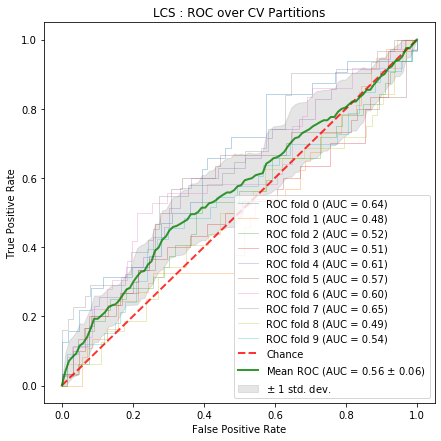

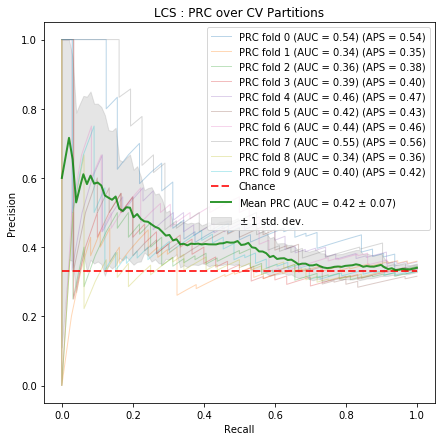

Avg. Model Balanced Accuracy = 0.5536018569219627 (std. dev. = 0.03240552865448368)
Avg. Model Accuracy = 0.6241601029704785 (std. dev. = 0.029732311254517203)
Avg. Model F1-Score = 0.3713045323076306 (std. dev. = 0.06190589643988712)
Avg. Model Recall = 0.33937960058927796 (std. dev. = 0.09157453300437784)
Avg. Model Specificity = 0.7678241132546476 (std. dev. = 0.06274774584448357)
Avg. Model Precision = 0.42494053846788776 (std. dev. = 0.0506428077725387)
Avg. Model True Positives = 11.0 (std. dev. = 2.5298221281347035)
Avg. Model True Negatives = 50.2 (std. dev. = 6.11228271597445)
Avg. Model False Positives = 15.0 (std. dev. = 3.605551275463989)
Avg. Model False Negatives = 21.8 (std. dev. = 4.1182520563948)
Avg. ROC AUC = 0.5618045957392209 (std. dev. = 0.05938354733736277)
Avg. PRC AUC = 0.4223482268139662 (std. dev. = 0.07163873142780071)
Avg. PRC Precision Score = 0.43614938928106584 (std. dev. = 0.06825466994105883)
LCS Run Time: 9105.083720207214


In [63]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec = eval_LCS(algorithm,cv_partitions,wd_path,output_folder,lcs_folder,data_name,iterations,algColor)
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
    
    elapsed_time = time.time() - start_time
    print('LCS Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

### Load and Evaluate LCS with QRF Predictions

Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF



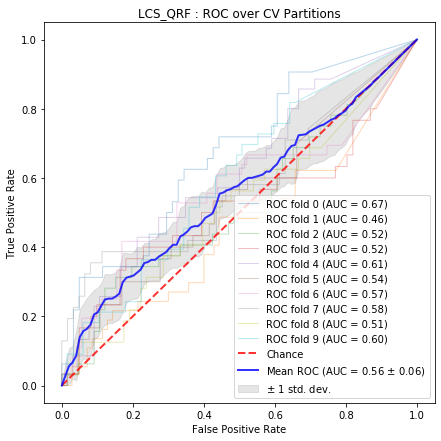

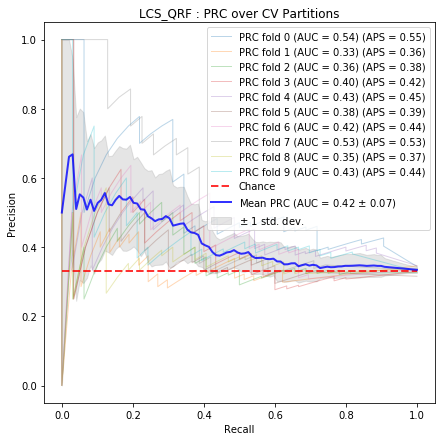

Avg. Model Balanced Accuracy = 0.5180933945361338 (std. dev. = 0.02043748638086014)
Avg. Model Accuracy = 0.6637832210505317 (std. dev. = 0.01716468581060463)
Avg. Model F1-Score = 0.13122236208923516 (std. dev. = 0.062134438293695034)
Avg. Model Recall = 0.07758643226385162 (std. dev. = 0.04072362774212513)
Avg. Model Specificity = 0.9586003568084159 (std. dev. = 0.019814032186925696)
Avg. Model Precision = 0.48960317460317454 (std. dev. = 0.20082421813885112)
Avg. Model True Positives = 2.5 (std. dev. = 1.2041594578792296)
Avg. Model True Negatives = 62.5 (std. dev. = 3.442382895611701)
Avg. Model False Positives = 2.7 (std. dev. = 1.2688577540449522)
Avg. Model False Negatives = 30.3 (std. dev. = 3.001666203960727)
Avg. ROC AUC = 0.5580182199139813 (std. dev. = 0.057174830332684924)
Avg. PRC AUC = 0.41830643288515895 (std. dev. = 0.06645103637425218)
Avg. PRC Precision Score = 0.4328237890904053 (std. dev. = 0.061298955719138265)


In [64]:
algorithm = 'LCS_QRF'
if algorithm in algorithmsToRun:
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec = eval_LCS_QRF(algorithm,cv_partitions,wd_path,output_folder,lcs_folder,data_name,iterations,algColor)
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

### Load and Evaluate LCS Feature Importance Estimates

In [65]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    FI_all = []
    FI_ave = [0]*len(ordered_feature_names) #Holds only the selected feature FI results for each partition
    
    #Gather all LCS feature importance results (specificity sums)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        scoreDict = {}
        fiFile = wd_path+lcs_folder+'/'+'ExSTraCS'+'_'+data_name+'_'+str(i)+'_Train_'+str(iterations)+'_PopStats.txt'
        fileObject = open(fiFile, 'r') 
        
        counter = 0
        tempList1 = []
        tempList2 = []
        for line in fileObject:
            if counter == 9:
                tempList1 = line.strip().split('\t')
            if counter == 10:
                tempList2 = line.strip().split('\t')
            counter += 1
        fileObject.close()
        
        for j in range(len(tempList1)):
            scoreDict[tempList1[j]] = float(tempList2[j])
 
        #Format feature importance scores as list (takes into account that all features are not in each CV partition)
        tempList = []
        j = 0
        for each in ordered_feature_names:
            if each in scoreDict:
                FI_ave[j] += float(scoreDict[each])
                tempList.append(float(scoreDict[each]))
            else:
                tempList.append(0)
            j += 1
            
        FI_all.append(tempList)
    
    
    dr = pd.DataFrame(FI_all)
    filepath = output_folder+'/'+algorithm+'_FI_'+data_name+'.csv'
    dr.to_csv(filepath, header=ordered_feature_names, index=False)  
    
    #Calculate Averages
    for i in range(0,len(FI_ave)):
        FI_ave[i] = FI_ave[i]/float(cv_partitions)
        
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)



---Feature Importances---



Names  Scores
1           cig_stop   627.3
17        diabetes_f   530.4
7       totalcarbadj   443.8
4       total_alcadj   408.3
10    total_GlyIndex   390.8
5       total_fatadj   376.3
14   totalCALCIUMadj   331.6
30            educat   323.6
3         pack_years   316.4
20            bmi_20   288.6
32     total_Marital   277.3
15          bmi_curc   276.0
2          cig_years   274.7
21            bmi_50   263.1
18           panc_fh   255.7
33           occupat   251.6
8   total_proteinadj   221.7
26        gallblad_f   217.1
24              ibup   203.5
36               sex   200.2

### Load and Evaluate LCS with QRF Feature Importance Estimates

In [66]:
algorithm = 'LCS_QRF'
if algorithm in algorithmsToRun:
    FI_all = []
    FI_ave = [0]*len(ordered_feature_names) #Holds only the selected feature FI results for each partition
    
    #Gather all LCS feature importance results (specificity sums)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        scoreDict = {}
        fiFile = wd_path+lcs_folder+'/'+'ExSTraCS'+'_'+data_name+'_'+str(i)+'_Train_RC_QRF_'+str(iterations)+'_PopStats.txt'
        fileObject = open(fiFile, 'r') 
        
        counter = 0
        tempList1 = []
        tempList2 = []
        for line in fileObject:
            if counter == 9:
                tempList1 = line.strip().split('\t')
            if counter == 10:
                tempList2 = line.strip().split('\t')
            counter += 1
        fileObject.close()
        
        for j in range(len(tempList1)):
            scoreDict[tempList1[j]] = float(tempList2[j])
 
        #Format feature importance scores as list (takes into account that all features are not in each CV partition)
        tempList = []
        j = 0
        for each in ordered_feature_names:
            if each in scoreDict:
                FI_ave[j] += float(scoreDict[each])
                tempList.append(float(scoreDict[each]))
            else:
                tempList.append(0)
            j += 1
            
        FI_all.append(tempList)
    
    
    dr = pd.DataFrame(FI_all)
    filepath = output_folder+'/'+algorithm+'_FI_'+data_name+'.csv'
    dr.to_csv(filepath, header=ordered_feature_names, index=False)  
    
    #Calculate Averages
    for i in range(0,len(FI_ave)):
        FI_ave[i] = FI_ave[i]/float(cv_partitions)
        
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)



---Feature Importances---



Names  Scores
1           cig_stop   489.5
17        diabetes_f   380.2
7       totalcarbadj   339.7
4       total_alcadj   295.8
10    total_GlyIndex   276.7
5       total_fatadj   267.9
30            educat   246.1
14   totalCALCIUMadj   243.4
3         pack_years   228.5
2          cig_years   213.7
20            bmi_20   208.5
32     total_Marital   204.7
15          bmi_curc   199.9
33           occupat   197.0
21            bmi_50   191.9
18           panc_fh   181.6
8   total_proteinadj   165.5
0           cig_stat   154.6
36               sex   153.8
26        gallblad_f   151.7

---
# Review result table (for global ROC and PRC figure building)

In [67]:
#Load pickle files of results
result_table = []

for algorithm in algorithmsToRun:
    tempDict = pickle.load(open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'rb'))
    result_table.append(tempDict)
    
result_table = pd.DataFrame.from_dict(result_table)

In [68]:
result_table
result_table.set_index('algorithm', inplace=True)

algorithm                                                fpr  \
0  logistic_regression  [0.0, 0.010101010101010102, 0.0202020202020202...   
1        decision_tree  [0.0, 0.010101010101010102, 0.0202020202020202...   
2        random_forest  [0.0, 0.010101010101010102, 0.0202020202020202...   
3          naive_bayes  [0.0, 0.010101010101010102, 0.0202020202020202...   
4                  XGB  [0.0, 0.010101010101010102, 0.0202020202020202...   
5                  LGB  [0.0, 0.010101010101010102, 0.0202020202020202...   
6                  SVM  [0.0, 0.010101010101010102, 0.0202020202020202...   
7                  ANN  [0.0, 0.010101010101010102, 0.0202020202020202...   
8                  LCS  [0.0, 0.010101010101010102, 0.0202020202020202...   
9              LCS_QRF  [0.0, 0.010101010101010102, 0.0202020202020202...   

                                                 tpr       auc  \
0  [0.0, 0.03633207070707071, 0.09363061663464889...  0.579802   
1  [0.0, 0.036133133831793826, 0.0637939436166668...  0.572881   
2  [0.0, 0.02513536866359447, 0.0863286935867581,...  0.571400   
3  [0.0, 0.03383214225956162, 0.05214022306764242...  0.579333   
4  [0.0, 0.047205668435507143, 0.0876104628927209...  0.535413   
5  [0.0, 0.04359814910218136, 0.06998351776577583...  0.529088   
6  [0.0, 0.03165933528836754, 0.07115586915990142...  0.579960   
7  [0.0, 0.01539141414141414, 0.04261011613834194...  0.574586   
8  [0.0, 0.04118314481217707, 0.07130289065772936...  0.562504   
9  [0.0, 0.028850195503421307, 0.0560251128799515...  0.558294   

                                                prec    pr_auc  ave_prec  
0  [0.4, 0.4909090909090909, 0.5818181818181818, ...  0.446160  0.461893  
1  [0.8, 0.7592088645597418, 0.7184177291194834, ...  0.455394  0.410296  
2  [0.4, 0.494949494949495, 0.5898989898989899, 0...  0.435236  0.449703  
3  [0.6, 0.6409090909090909, 0.6818181818181819, ...  0.433694  0.447354  
4  [0.6, 0.6607744107744108, 0.7215488215488216, ...  0.403270  0.417490  
5  [0.7, 0.740909090909091, 0.7818181818181819, 0...  0.397322  0.410291  
6  [0.4, 0.48989898989898994, 0.5797979797979799,...  0.433286  0.449456  
7  [0.4, 0.4803030303030303, 0.5606060606060607, ...  0.420305  0.437255  
8  [0.6, 0.657979797979798, 0.7159595959595959, 0...  0.421557  0.436149  
9  [0.5, 0.5806397306397307, 0.6612794612794614, ...  0.418389  0.432824

---
# ROC Plot Summarizing Analysis

([<matplotlib.axis.XTick at 0x22214e7c8c8>,
 <a list of 11 Text xticklabel objects>)

Text(0.5, 0, 'False Positive Rate')

([<matplotlib.axis.YTick at 0x2221884a408>,
 <a list of 11 Text yticklabel objects>)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Comparing Algorithms: Testing Data with CV')

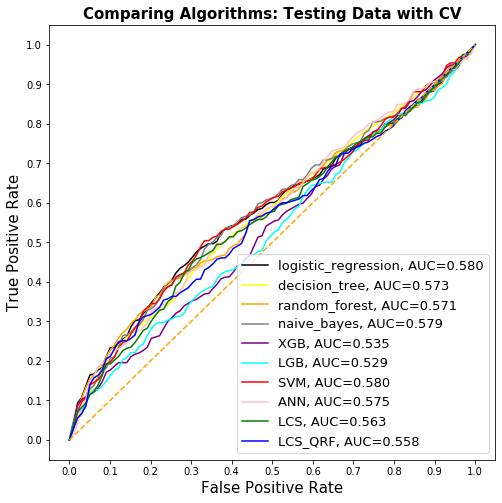

In [69]:
#Multi-algorithm ROC plot
fig = plt.figure(figsize=(8,8))
count = 0
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], color = algColors[count],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    count += 1
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('Comparing Algorithms: Testing Data with CV', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='best')
plt.savefig((wd_path+output_folder+'/'+'Compare_ROC_' + data_name), bbox_inches = "tight")
plt.show()


---
# PRC Plot Summarizing Analysis

([<matplotlib.axis.XTick at 0x222161fda08>,
 <a list of 11 Text xticklabel objects>)

Text(0.5, 0, 'Recall')

([<matplotlib.axis.YTick at 0x22214abc1c8>,
 <a list of 11 Text yticklabel objects>)

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Comparing Algorithms: Testing Data with CV')

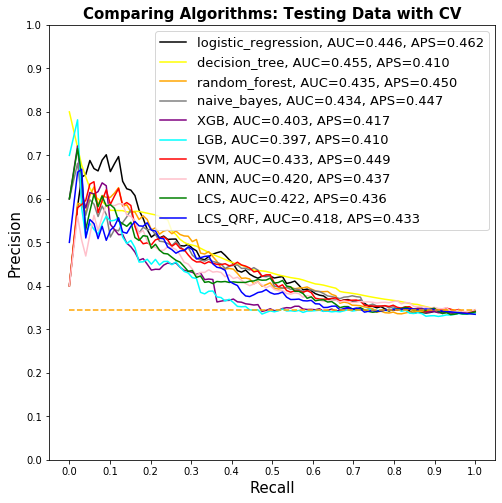

In [70]:
#Multi-algorithm PRC plot ['algorithm','fpr','tpr','auc','prec','pr_auc','ave_prec'])
#result_table.set_index('algorithm', inplace=True)

fig = plt.figure(figsize=(8,8))

count = 0
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['prec'], color = algColors[count],
             label="{}, AUC={:.3f}, APS={:.3f}".format(i, result_table.loc[i]['pr_auc'],result_table.loc[i]['ave_prec']))
    count += 1
noskill = len(yTestList[0][yTestList[0]==1]) / len(yTestList[0]) #Fraction of cases
plt.plot([0,1], [noskill,noskill], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Recall", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Precision", fontsize=15)

plt.title('Comparing Algorithms: Testing Data with CV', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='best')
plt.savefig((wd_path+output_folder+'/'+'Compare_PRC_' + data_name), bbox_inches = "tight")
plt.show()


---
# Summarize Algorithm Metrics 

In [71]:
td = pd.read_csv(wd_path+output_folder+'/'+algorithmsToRun[0]+'_Metrics_'+data_name+'.csv')
metrics = list(td.columns.values.tolist()) 

metric_summary = pd.DataFrame(index=metrics,columns=algorithmsToRun)
master_list = []

for algorithm in algorithmsToRun:
    #Open file
    td = pd.read_csv(wd_path+output_folder+'/'+algorithm+'_Metrics_'+data_name+'.csv')
    master_list.append(td)
    for metric in metrics:
        ave = td[metric].mean()
        sd = td[metric].std()
        metric_summary.at[metric, algorithm] = str(round(ave,4))+' ('+str(round(sd,4))+')'
    
metric_summary.to_csv(wd_path+output_folder+'/'+'Summary_Algorithm_Metrics_'+data_name+'.csv')   

In [72]:
metric_summary

logistic_regression    decision_tree    random_forest  \
Balanced Accuracy     0.5683 (0.0477)  0.5551 (0.0475)  0.5582 (0.0468)   
Accuracy              0.6443 (0.0742)  0.6471 (0.0544)  0.6325 (0.0488)   
F1_Score              0.3882 (0.0725)  0.3231 (0.1397)  0.3732 (0.0922)   
Recall                0.3423 (0.1051)  0.2783 (0.1548)  0.3355 (0.0981)   
Specificity           0.7944 (0.1468)   0.832 (0.1275)  0.7809 (0.0797)   
Precision             0.4889 (0.1183)   0.4782 (0.118)  0.4443 (0.0879)   
TP                      11.3 (3.8312)     9.1 (5.2164)    11.0 (3.2998)   
TN                     51.8 (10.1412)    54.4 (9.8342)     51.0 (6.733)   
FP                      13.4 (9.6632)    10.8 (8.0664)    14.2 (5.1164)   
FN                      21.5 (3.4075)     23.7 (5.697)    21.8 (3.6454)   
ROC_AUC               0.5792 (0.0709)  0.5729 (0.0394)  0.5708 (0.0586)   
PRC_AUC               0.4468 (0.0784)  0.4554 (0.0873)  0.4359 (0.0767)   
PRC_APS               0.4619 (0.0742)  0.4103 (0.0609)  0.4497 (0.0731)   

                       naive_bayes              XGB              LGB  \
Balanced Accuracy  0.5729 (0.0395)  0.5184 (0.0245)  0.5242 (0.0311)   
Accuracy            0.641 (0.0411)  0.5982 (0.0536)   0.5925 (0.043)   
F1_Score           0.4051 (0.0612)  0.3087 (0.0571)  0.3401 (0.0585)   
Recall             0.3673 (0.0695)  0.2777 (0.0938)    0.32 (0.0867)   
Specificity        0.7785 (0.0614)  0.7591 (0.1193)  0.7284 (0.0857)   
Precision          0.4595 (0.0742)  0.3884 (0.0761)  0.3755 (0.0445)   
TP                   12.0 (2.1602)     9.1 (3.1073)    10.5 (2.9533)   
TN                   50.8 (5.3083)    49.5 (8.0863)    47.5 (6.2761)   
FP                   14.4 (3.8644)    15.7 (7.6311)     17.7 (5.697)   
FN                   20.8 (3.1552)    23.7 (3.6225)    22.3 (3.2677)   
ROC_AUC            0.5789 (0.0595)   0.535 (0.0439)  0.5284 (0.0403)   
PRC_AUC            0.4342 (0.0607)  0.4039 (0.0737)  0.3983 (0.0665)   
PRC_APS            0.4474 (0.0605)  0.4175 (0.0695)  0.4103 (0.0625)   

                               SVM              ANN              LCS  \
Balanced Accuracy  0.5669 (0.0563)  0.5468 (0.0162)  0.5536 (0.0342)   
Accuracy           0.5932 (0.0655)  0.6592 (0.0287)  0.6242 (0.0313)   
F1_Score           0.4436 (0.0739)  0.2833 (0.0605)  0.3713 (0.0653)   
Recall             0.4907 (0.1156)  0.2081 (0.0757)  0.3394 (0.0965)   
Specificity        0.6432 (0.1133)  0.8854 (0.0693)  0.7678 (0.0661)   
Precision          0.4141 (0.0627)  0.5076 (0.1033)  0.4249 (0.0534)   
TP                   16.2 (4.4171)     6.8 (2.3944)    11.0 (2.6667)   
TN                   41.9 (7.4005)    57.8 (6.2325)    50.2 (6.4429)   
FP                   23.3 (7.5285)     7.4 (4.2999)    15.0 (3.8006)   
FN                   16.6 (3.5024)    26.0 (3.4319)     21.8 (4.341)   
ROC_AUC            0.5795 (0.0681)  0.5738 (0.0763)  0.5618 (0.0626)   
PRC_AUC            0.4342 (0.0728)    0.4213 (0.06)  0.4223 (0.0755)   
PRC_APS             0.4495 (0.069)  0.4373 (0.0583)  0.4361 (0.0719)   

                           LCS_QRF  
Balanced Accuracy  0.5181 (0.0215)  
Accuracy           0.6638 (0.0181)  
F1_Score           0.1312 (0.0655)  
Recall             0.0776 (0.0429)  
Specificity        0.9586 (0.0209)  
Precision          0.4896 (0.2117)  
TP                    2.5 (1.2693)  
TN                   62.5 (3.6286)  
FP                    2.7 (1.3375)  
FN                    30.3 (3.164)  
ROC_AUC             0.558 (0.0603)  
PRC_AUC              0.4183 (0.07)  
PRC_APS            0.4328 (0.0646)

---
# Performance Metric Boxplots Comparing Algorithms

Text(0.5, 1.0, 'Comparing Algorithm Balanced Accuracy')

Text(0, 0.5, 'Balanced Accuracy')

Text(0.5, 0, 'ML Algorithm')

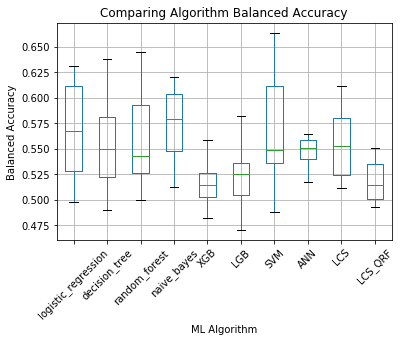

Text(0.5, 1.0, 'Comparing Algorithm Accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'ML Algorithm')

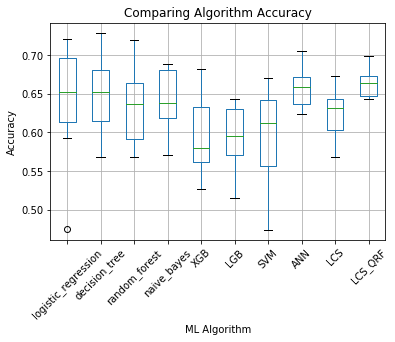

Text(0.5, 1.0, 'Comparing Algorithm F1_Score')

Text(0, 0.5, 'F1_Score')

Text(0.5, 0, 'ML Algorithm')

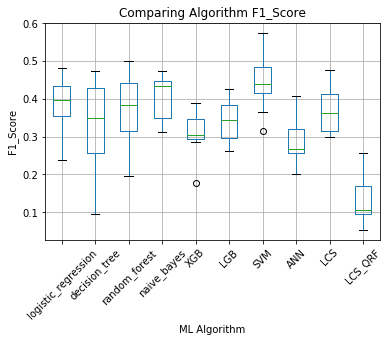

Text(0.5, 1.0, 'Comparing Algorithm Recall')

Text(0, 0.5, 'Recall')

Text(0.5, 0, 'ML Algorithm')

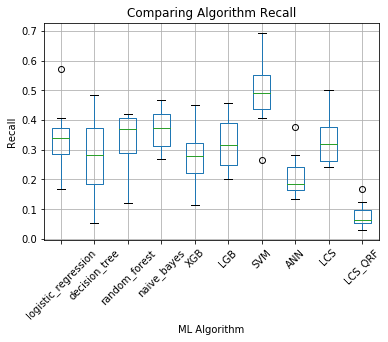

Text(0.5, 1.0, 'Comparing Algorithm Specificity')

Text(0, 0.5, 'Specificity')

Text(0.5, 0, 'ML Algorithm')

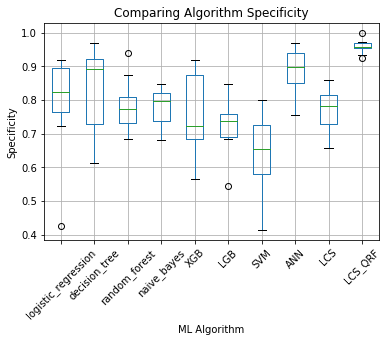

Text(0.5, 1.0, 'Comparing Algorithm Precision')

Text(0, 0.5, 'Precision')

Text(0.5, 0, 'ML Algorithm')

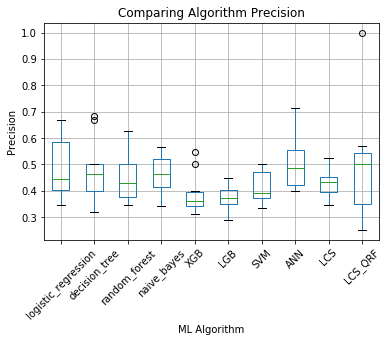

Text(0.5, 1.0, 'Comparing Algorithm TP')

Text(0, 0.5, 'TP')

Text(0.5, 0, 'ML Algorithm')

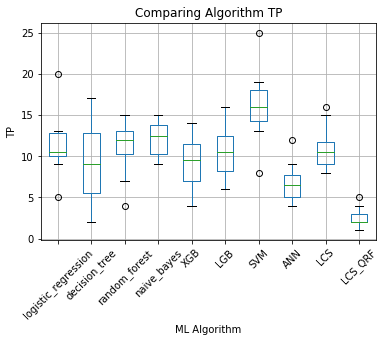

Text(0.5, 1.0, 'Comparing Algorithm TN')

Text(0, 0.5, 'TN')

Text(0.5, 0, 'ML Algorithm')

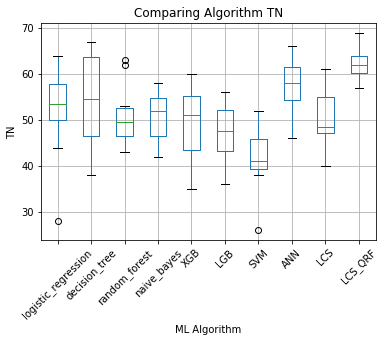

Text(0.5, 1.0, 'Comparing Algorithm FP')

Text(0, 0.5, 'FP')

Text(0.5, 0, 'ML Algorithm')

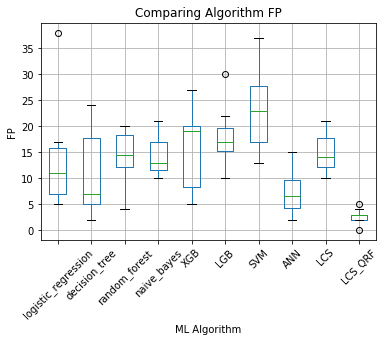

Text(0.5, 1.0, 'Comparing Algorithm FN')

Text(0, 0.5, 'FN')

Text(0.5, 0, 'ML Algorithm')

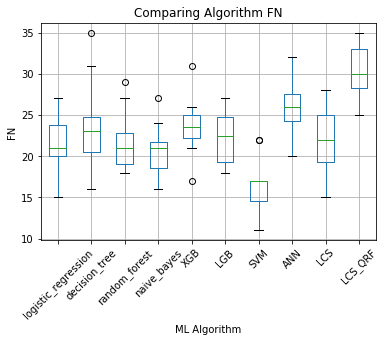

Text(0.5, 1.0, 'Comparing Algorithm ROC_AUC')

Text(0, 0.5, 'ROC_AUC')

Text(0.5, 0, 'ML Algorithm')

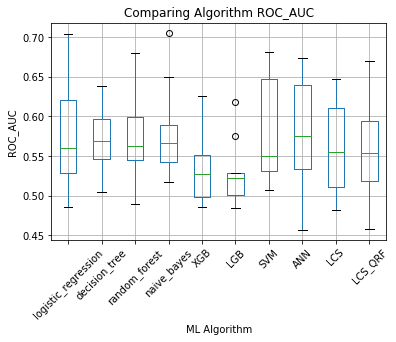

Text(0.5, 1.0, 'Comparing Algorithm PRC_AUC')

Text(0, 0.5, 'PRC_AUC')

Text(0.5, 0, 'ML Algorithm')

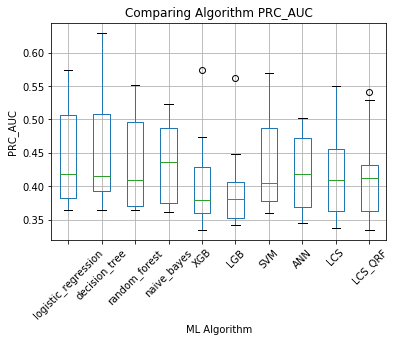

Text(0.5, 1.0, 'Comparing Algorithm PRC_APS')

Text(0, 0.5, 'PRC_APS')

Text(0.5, 0, 'ML Algorithm')

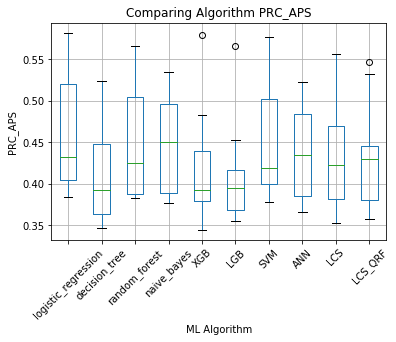

In [73]:

#For each metric
for metric in metrics:
    i = 0
    tempList = []
    for algorithm in algorithmsToRun:
        temp_td = master_list[i]
        tempList.append(temp_td[metric].tolist())
        i += 1
        
    td = pd.DataFrame(tempList)
    td = td.transpose()
    td.columns = algorithmsToRun
        
    boxplot = td.boxplot(column=algorithmsToRun,rot=45)
    plt.title('Comparing Algorithm '+ str(metric))
    plt.ylabel(str(metric))
    plt.xlabel('ML Algorithm')
    plt.savefig((wd_path+output_folder+'/'+'Compare_'+str(metric)+'_Boxplot_'+data_name), bbox_inches = "tight")
    plt.show()


---
# Statistical Comparisons
- Kruskal Wallis AOV comparing ML algorithms
- Mann-Whitney U test - Pairwise algorithm differences  

## Kruskal Wallis Test - Algorithm comparisons for each metric
- Are any algorithms performing statistically better or worse? 

## Mann-Whiney Test - Pairwise Post-Hoc Analysis 
- For any metric where kruskal wallis test was significant.

In [74]:
if len(algorithmsToRun) > 1:
    label = ['statistic','pvalue','sig']
    kruskal_summary = pd.DataFrame(index=metrics,columns=label)
    for metric in metrics:
        tempArray = []
        for i in range(len(algorithmsToRun)):
            tempArray.append(master_list[i][metric])
        result = stats.kruskal(*tempArray)
        #result = stats.kruskal(master_list[0][metric],master_list[1][metric],master_list[2][metric],master_list[3][metric],master_list[4][metric],master_list[5][metric],master_list[6][metric]) 
        kruskal_summary.at[metric, 'statistic'] = str(round(result[0],6))
        kruskal_summary.at[metric, 'pvalue'] = str(round(result[1],6))
        if result[1] < sig_cutoff:
            kruskal_summary.at[metric, 'sig'] = str('*')
        else:
            kruskal_summary.at[metric, 'sig'] = str('')

    kruskal_summary

    kruskal_summary.to_csv(wd_path+output_folder+'/'+'Summary_Algorithm_KruskalWallis_'+data_name+'.csv')   

statistic    pvalue sig
Balanced Accuracy  22.651122  0.007029   *
Accuracy           23.898954  0.004464   *
F1_Score           46.731909       0.0   *
Recall              48.56857       0.0   *
Specificity        47.003372       0.0   *
Precision          18.671486  0.028136   *
TP                 48.785553       0.0   *
TN                 38.269402   1.6e-05   *
FP                 46.917487       0.0   *
FN                 42.634104     3e-06   *
ROC_AUC             9.989703  0.351319    
PRC_AUC              6.50305  0.688704    
PRC_APS             7.809505  0.553452

In [75]:
if len(algorithmsToRun) > 1:
    algCount = len(algorithmsToRun)
    for metric in metrics:
        if kruskal_summary['sig'][metric] == '*':
            mann_stats = []
            #Balanced Accuracy
            for i in range(0,algCount-1):
                for j in range(i+1,algCount):
                    set1 = master_list[i][metric]
                    set2 = master_list[j][metric]

                    #print('Mann-WhitneyU: '+str(algorithmsToRun[i])+' vs. '+str(algorithmsToRun[j]))
                    report = stats.mannwhitneyu(set1,set2)
                    #report
                    tempstats = [algorithmsToRun[i], algorithmsToRun[j], report[0], report[1], '']
                    if report[1] < sig_cutoff:
                        tempstats[4] = '*'
                    mann_stats.append(tempstats)

            mann_stats_df = pd.DataFrame(mann_stats)
            mann_stats_df.columns = ['Algorithm 1', 'Algorithm 2', 'statistic', 'p-value', 'sig']
            filepath = wd_path+output_folder+'/'+'MannWhitney_'+str(metric)+'_'+data_name+'.csv'
            mann_stats_df.to_csv(filepath, index = False) 
            mann_stats_df

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       42.0  0.285375    
1   logistic_regression  random_forest       45.0  0.366865    
2   logistic_regression    naive_bayes       48.5  0.469860    
3   logistic_regression            XGB       15.0  0.004554   *
4   logistic_regression            LGB       20.5  0.014153   *
5   logistic_regression            SVM       49.0  0.484925    
6   logistic_regression            ANN       34.0  0.120661    
7   logistic_regression            LCS       40.0  0.236338    
8   logistic_regression        LCS_QRF       17.0  0.007010   *
9         decision_tree  random_forest       48.0  0.454861    
10        decision_tree    naive_bayes       39.0  0.213678    
11        decision_tree            XGB       29.0  0.060612    
12        decision_tree            LGB       30.0  0.070233    
13        decision_tree            SVM       45.0  0.366865    
14        decision_tree            ANN       49.0  0.484925    
15        decision_tree            LCS       50.0  0.484925    
16        decision_tree        LCS_QRF       24.0  0.026861   *
17        random_forest    naive_bayes       40.0  0.236338    
18        random_forest            XGB       22.5  0.020587   *
19        random_forest            LGB       29.0  0.060472    
20        random_forest            SVM       43.0  0.311588    
21        random_forest            ANN       49.0  0.484925    
22        random_forest            LCS       47.5  0.439892    
23        random_forest        LCS_QRF       22.0  0.018818   *
24          naive_bayes            XGB       12.0  0.002293   *
25          naive_bayes            LGB       18.0  0.008629   *
26          naive_bayes            SVM       47.0  0.425053    
27          naive_bayes            ANN       27.0  0.044487   *
28          naive_bayes            LCS       35.0  0.136518    
29          naive_bayes        LCS_QRF       13.0  0.002898   *
30                  XGB            LGB       40.0  0.236338    
31                  XGB            SVM       24.0  0.026951   *
32                  XGB            ANN       19.0  0.010567   *
33                  XGB            LCS       18.0  0.008629   *
34                  XGB        LCS_QRF       47.0  0.425053    
35                  LGB            SVM       25.0  0.032011   *
36                  LGB            ANN       25.0  0.032011   *
37                  LGB            LCS       27.5  0.048089   *
38                  LGB        LCS_QRF       41.0  0.260261    
39                  SVM            ANN       45.0  0.366865    
40                  SVM            LCS       43.0  0.311588    
41                  SVM        LCS_QRF       24.0  0.026951   *
42                  ANN            LCS       46.0  0.395668    
43                  ANN        LCS_QRF       13.0  0.002898   *
44                  LCS        LCS_QRF       21.0  0.015605   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       48.0  0.454861    
1   logistic_regression  random_forest       39.5  0.224761    
2   logistic_regression    naive_bayes       40.0  0.236338    
3   logistic_regression            XGB       25.0  0.032011   *
4   logistic_regression            LGB       23.0  0.022497   *
5   logistic_regression            SVM       27.5  0.048089   *
6   logistic_regression            ANN       47.0  0.424998    
7   logistic_regression            LCS       33.5  0.113151    
8   logistic_regression        LCS_QRF       43.0  0.311457    
9         decision_tree  random_forest       42.0  0.285230    
10        decision_tree    naive_bayes       49.0  0.484925    
11        decision_tree            XGB       28.0  0.052055    
12        decision_tree            LGB       20.5  0.014153   *
13        decision_tree            SVM       26.5  0.040992   *
14        decision_tree            ANN       44.0  0.338678    
15        decision_tree            LCS       35.5  0.144869    
16        decision_tree        LCS_QRF       42.0  0.285230    
17        random_forest    naive_bayes       41.0  0.260105    
18        random_forest            XGB       33.0  0.105975    
19        random_forest            LGB       27.0  0.044366   *
20        random_forest            SVM       33.0  0.105975    
21        random_forest            ANN       32.5  0.099298    
22        random_forest            LCS       44.5  0.352676    
23        random_forest        LCS_QRF       26.5  0.040877   *
24          naive_bayes            XGB       24.0  0.026861   *
25          naive_bayes            LGB       22.0  0.018818   *
26          naive_bayes            SVM       29.0  0.060472    
27          naive_bayes            ANN       39.0  0.213678    
28          naive_bayes            LCS       37.0  0.172171    
29          naive_bayes        LCS_QRF       37.5  0.182083    
30                  XGB            LGB       49.0  0.484925    
31                  XGB            SVM       49.5  0.500000    
32                  XGB            ANN       21.0  0.015605   *
33                  XGB            LCS       33.5  0.113151    
34                  XGB        LCS_QRF       15.5  0.005068   *
35                  LGB            SVM       47.5  0.439892    
36                  LGB            ANN        9.0  0.001101   *
37                  LGB            LCS       29.0  0.060472    
38                  LGB        LCS_QRF        0.5  0.000106   *
39                  SVM            ANN       19.5  0.011645   *
40                  SVM            LCS       38.5  0.202751    
41                  SVM        LCS_QRF       12.5  0.002571   *
42                  ANN            LCS       23.0  0.022497   *
43                  ANN        LCS_QRF       44.5  0.352570    
44                  LCS        LCS_QRF       13.0  0.002898   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       37.0  0.172352    
1   logistic_regression  random_forest       44.0  0.338792    
2   logistic_regression    naive_bayes       43.0  0.311588    
3   logistic_regression            XGB       17.0  0.007010   *
4   logistic_regression            LGB       27.5  0.048089   *
5   logistic_regression            SVM       31.0  0.080986    
6   logistic_regression            ANN       15.0  0.004541   *
7   logistic_regression            LCS       38.0  0.192337    
8   logistic_regression        LCS_QRF        1.0  0.000123   *
9         decision_tree  random_forest       42.0  0.285375    
10        decision_tree    naive_bayes       32.5  0.099298    
11        decision_tree            XGB       43.0  0.311588    
12        decision_tree            LGB       48.0  0.454861    
13        decision_tree            SVM       23.0  0.022577   *
14        decision_tree            ANN       36.0  0.153654    
15        decision_tree            LCS       44.0  0.338792    
16        decision_tree        LCS_QRF       13.5  0.003241   *
17        random_forest    naive_bayes       41.5  0.272599    
18        random_forest            XGB       27.5  0.048089   *
19        random_forest            LGB       36.0  0.153563    
20        random_forest            SVM       28.0  0.052055    
21        random_forest            ANN       20.0  0.012846   *
22        random_forest            LCS       47.5  0.439892    
23        random_forest        LCS_QRF        2.0  0.000165   *
24          naive_bayes            XGB       12.0  0.002293   *
25          naive_bayes            LGB       21.0  0.015605   *
26          naive_bayes            SVM       38.5  0.202751    
27          naive_bayes            ANN        7.0  0.000655   *
28          naive_bayes            LCS       35.0  0.136338    
29          naive_bayes        LCS_QRF        0.0  0.000091   *
30                  XGB            LGB       39.0  0.213678    
31                  XGB            SVM        5.0  0.000384   *
32                  XGB            ANN       33.0  0.106061    
33                  XGB            LCS       25.0  0.032011   *
34                  XGB        LCS_QRF        2.0  0.000165   *
35                  LGB            SVM       10.5  0.001593   *
36                  LGB            ANN       23.0  0.022537   *
37                  LGB            LCS       37.5  0.182083    
38                  LGB        LCS_QRF        0.0  0.000091   *
39                  SVM            ANN        4.0  0.000290   *
40                  SVM            LCS       23.0  0.022577   *
41                  SVM        LCS_QRF        0.0  0.000091   *
42                  ANN            LCS       14.0  0.003631   *
43                  ANN        LCS_QRF        4.0  0.000290   *
44                  LCS        LCS_QRF        0.0  0.000091   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       37.5  0.181902    
1   logistic_regression  random_forest       43.0  0.311195    
2   logistic_regression    naive_bayes       37.0  0.171989    
3   logistic_regression            XGB       32.0  0.092938    
4   logistic_regression            LGB       43.5  0.324828    
5   logistic_regression            SVM       17.0  0.007010   *
6   logistic_regression            ANN       14.5  0.004016   *
7   logistic_regression            LCS       45.0  0.366720    
8   logistic_regression        LCS_QRF        0.5  0.000105   *
9         decision_tree  random_forest       37.5  0.181993    
10        decision_tree    naive_bayes       32.5  0.099298    
11        decision_tree            XGB       48.0  0.454827    
12        decision_tree            LGB       43.0  0.311326    
13        decision_tree            SVM       12.0  0.002293   *
14        decision_tree            ANN       34.0  0.120129    
15        decision_tree            LCS       37.0  0.172261    
16        decision_tree        LCS_QRF       14.0  0.003609   *
17        random_forest    naive_bayes       38.5  0.202309    
18        random_forest            XGB       29.5  0.065140    
19        random_forest            LGB       43.0  0.311129    
20        random_forest            SVM       12.0  0.002286   *
21        random_forest            ANN       18.0  0.008587   *
22        random_forest            LCS       44.5  0.352570    
23        random_forest        LCS_QRF        2.0  0.000163   *
24          naive_bayes            XGB       23.0  0.022577   *
25          naive_bayes            LGB       31.0  0.080749    
26          naive_bayes            SVM       17.0  0.007010   *
27          naive_bayes            ANN        7.5  0.000743   *
28          naive_bayes            LCS       37.5  0.181993    
29          naive_bayes        LCS_QRF        0.0  0.000091   *
30                  XGB            LGB       36.5  0.162694    
31                  XGB            SVM        8.5  0.000966   *
32                  XGB            ANN       27.0  0.044306   *
33                  XGB            LCS       31.5  0.086647    
34                  XGB        LCS_QRF        2.0  0.000164   *
35                  LGB            SVM       11.0  0.001799   *
36                  LGB            ANN       15.5  0.004998   *
37                  LGB            LCS       44.5  0.352464    
38                  LGB        LCS_QRF        0.0  0.000090   *
39                  SVM            ANN        2.0  0.000164   *
40                  SVM            LCS       16.0  0.005603   *
41                  SVM        LCS_QRF        0.0  0.000091   *
42                  ANN            LCS       12.5  0.002554   *
43                  ANN        LCS_QRF        4.0  0.000285   *
44                  LCS        LCS_QRF        0.0  0.000090   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       40.0  0.236338    
1   logistic_regression  random_forest       37.5  0.182083    
2   logistic_regression    naive_bayes       35.0  0.136518    
3   logistic_regression            XGB       37.0  0.172352    
4   logistic_regression            LGB       22.0  0.018746   *
5   logistic_regression            SVM       16.0  0.005649   *
6   logistic_regression            ANN       25.5  0.034769   *
7   logistic_regression            LCS       34.0  0.120661    
8   logistic_regression        LCS_QRF        0.0  0.000091   *
9         decision_tree  random_forest       38.5  0.202751    
10        decision_tree    naive_bayes       33.5  0.113151    
11        decision_tree            XGB       28.5  0.056138    
12        decision_tree            LGB       25.0  0.032011   *
13        decision_tree            SVM       15.0  0.004541   *
14        decision_tree            ANN       41.0  0.260261    
15        decision_tree            LCS       32.0  0.092938    
16        decision_tree        LCS_QRF       13.5  0.003241   *
17        random_forest    naive_bayes       47.5  0.439892    
18        random_forest            XGB       40.5  0.247903    
19        random_forest            LGB       33.0  0.105975    
20        random_forest            SVM       16.0  0.005649   *
21        random_forest            ANN       16.0  0.005665   *
22        random_forest            LCS       48.0  0.454827    
23        random_forest        LCS_QRF        2.0  0.000165   *
24          naive_bayes            XGB       42.5  0.298282    
25          naive_bayes            LGB       34.0  0.120484    
26          naive_bayes            SVM       12.0  0.002286   *
27          naive_bayes            ANN       12.5  0.002571   *
28          naive_bayes            LCS       44.5  0.352676    
29          naive_bayes        LCS_QRF        0.0  0.000091   *
30                  XGB            LGB       47.5  0.439892    
31                  XGB            SVM       26.0  0.037776   *
32                  XGB            ANN       18.0  0.008629   *
33                  XGB            LCS       46.5  0.410265    
34                  XGB        LCS_QRF        0.0  0.000091   *
35                  LGB            SVM       27.0  0.044426   *
36                  LGB            ANN        6.5  0.000574   *
37                  LGB            LCS       37.5  0.182083    
38                  LGB        LCS_QRF        0.0  0.000091   *
39                  SVM            ANN        2.0  0.000164   *
40                  SVM            LCS       15.5  0.005054   *
41                  SVM        LCS_QRF        0.0  0.000091   *
42                  ANN            LCS       11.0  0.001805   *
43                  ANN        LCS_QRF       13.5  0.003241   *
44                  LCS        LCS_QRF        0.0  0.000091   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       49.5  0.500000    
1   logistic_regression  random_forest       38.5  0.202397    
2   logistic_regression    naive_bayes       44.5  0.352676    
3   logistic_regression            XGB       19.0  0.010519   *
4   logistic_regression            LGB       20.5  0.014123   *
5   logistic_regression            SVM       32.0  0.092938    
6   logistic_regression            ANN       44.5  0.352676    
7   logistic_regression            LCS       38.5  0.202751    
8   logistic_regression        LCS_QRF       43.5  0.324766    
9         decision_tree  random_forest       42.0  0.283838    
10        decision_tree    naive_bayes       50.0  0.484914    
11        decision_tree            XGB       25.0  0.031611   *
12        decision_tree            LGB       19.0  0.010494   *
13        decision_tree            SVM       32.5  0.098875    
14        decision_tree            ANN       38.0  0.191619    
15        decision_tree            LCS       36.0  0.153289    
16        decision_tree        LCS_QRF       49.0  0.484787    
17        random_forest    naive_bayes       42.0  0.285085    
18        random_forest            XGB       27.5  0.047401   *
19        random_forest            LGB       27.0  0.044066   *
20        random_forest            SVM       38.0  0.191349    
21        random_forest            ANN       30.0  0.069411    
22        random_forest            LCS       46.5  0.410132    
23        random_forest        LCS_QRF       45.5  0.379638    
24          naive_bayes            XGB       23.0  0.022577   *
25          naive_bayes            LGB       17.5  0.007743   *
26          naive_bayes            SVM       32.5  0.099298    
27          naive_bayes            ANN       38.5  0.202751    
28          naive_bayes            LCS       35.0  0.136518    
29          naive_bayes        LCS_QRF       48.0  0.454793    
30                  XGB            LGB       44.0  0.338735    
31                  XGB            SVM       38.0  0.192158    
32                  XGB            ANN       12.5  0.002554   *
33                  XGB            LCS       27.5  0.048089   *
34                  XGB        LCS_QRF       35.5  0.143867    
35                  LGB            SVM       34.0  0.120572    
36                  LGB            ANN        8.0  0.000850   *
37                  LGB            LCS       24.5  0.029296   *
38                  LGB        LCS_QRF       32.0  0.092524    
39                  SVM            ANN       19.5  0.011645   *
40                  SVM            LCS       45.5  0.381141    
41                  SVM        LCS_QRF       35.0  0.135523    
42                  ANN            LCS       24.5  0.029343   *
43                  ANN        LCS_QRF       42.5  0.297518    
44                  LCS        LCS_QRF       39.5  0.224419

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       38.5  0.201328    
1   logistic_regression  random_forest       43.5  0.321987    
2   logistic_regression    naive_bayes       38.5  0.200428    
3   logistic_regression            XGB       33.5  0.110863    
4   logistic_regression            LGB       44.0  0.337285    
5   logistic_regression            SVM       18.0  0.008420   *
6   logistic_regression            ANN       13.5  0.003072   *
7   logistic_regression            LCS       44.5  0.351337    
8   logistic_regression        LCS_QRF        0.5  0.000096   *
9         decision_tree  random_forest       38.5  0.200609    
10        decision_tree    naive_bayes       32.5  0.098536    
11        decision_tree            XGB       49.0  0.484851    
12        decision_tree            LGB       41.5  0.271839    
13        decision_tree            SVM       13.5  0.003191   *
14        decision_tree            ANN       35.5  0.143409    
15        decision_tree            LCS       39.0  0.212805    
16        decision_tree        LCS_QRF       12.5  0.002271   *
17        random_forest    naive_bayes       43.0  0.308715    
18        random_forest            XGB       30.5  0.073845    
19        random_forest            LGB       41.5  0.269040    
20        random_forest            SVM       12.5  0.002382   *
21        random_forest            ANN       16.5  0.005976   *
22        random_forest            LCS       43.0  0.309867    
23        random_forest        LCS_QRF        1.5  0.000125   *
24          naive_bayes            XGB       23.0  0.021853   *
25          naive_bayes            LGB       32.5  0.097600    
26          naive_bayes            SVM       16.5  0.006107   *
27          naive_bayes            ANN        5.5  0.000417   *
28          naive_bayes            LCS       36.5  0.160209    
29          naive_bayes        LCS_QRF        0.0  0.000084   *
30                  XGB            LGB       38.0  0.191349    
31                  XGB            SVM        7.5  0.000731   *
32                  XGB            ANN       27.5  0.046774   *
33                  XGB            LCS       34.5  0.126620    
34                  XGB        LCS_QRF        1.5  0.000131   *
35                  LGB            SVM       13.0  0.002770   *
36                  LGB            ANN       15.0  0.004386   *
37                  LGB            LCS       45.5  0.379997    
38                  LGB        LCS_QRF        0.0  0.000084   *
39                  SVM            ANN        2.5  0.000183   *
40                  SVM            LCS       16.0  0.005482   *
41                  SVM        LCS_QRF        0.0  0.000084   *
42                  ANN            LCS       10.5  0.001497   *
43                  ANN        LCS_QRF        3.0  0.000195   *
44                  LCS        LCS_QRF        0.0  0.000083   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       43.5  0.324828    
1   logistic_regression  random_forest       39.0  0.213330    
2   logistic_regression    naive_bayes       40.0  0.236088    
3   logistic_regression            XGB       40.5  0.247903    
4   logistic_regression            LGB       28.0  0.051599    
5   logistic_regression            SVM       17.5  0.007724   *
6   logistic_regression            ANN       30.5  0.074925    
7   logistic_regression            LCS       36.0  0.153198    
8   logistic_regression        LCS_QRF       11.0  0.001755   *
9         decision_tree  random_forest       38.0  0.191709    
10        decision_tree    naive_bayes       37.5  0.181449    
11        decision_tree            XGB       33.5  0.112713    
12        decision_tree            LGB       28.0  0.051534    
13        decision_tree            SVM       15.5  0.004984   *
14        decision_tree            ANN       40.0  0.235333    
15        decision_tree            LCS       38.5  0.202131    
16        decision_tree        LCS_QRF       27.0  0.044126   *
17        random_forest    naive_bayes       46.5  0.410132    
18        random_forest            XGB       46.5  0.410065    
19        random_forest            LGB       38.0  0.191619    
20        random_forest            SVM       17.5  0.007705   *
21        random_forest            ANN       21.5  0.016978   *
22        random_forest            LCS       47.0  0.424858    
23        random_forest        LCS_QRF       11.0  0.001774   *
24          naive_bayes            XGB       46.0  0.395361    
25          naive_bayes            LGB       35.0  0.136067    
26          naive_bayes            SVM       13.5  0.003211   *
27          naive_bayes            ANN       19.5  0.011490   *
28          naive_bayes            LCS       48.5  0.469769    
29          naive_bayes        LCS_QRF        1.0  0.000122   *
30                  XGB            LGB       42.0  0.284867    
31                  XGB            SVM       23.5  0.024427   *
32                  XGB            ANN       19.0  0.010374   *
33                  XGB            LCS       49.0  0.484897    
34                  XGB        LCS_QRF        4.0  0.000285   *
35                  LGB            SVM       27.5  0.047964   *
36                  LGB            ANN       12.0  0.002240   *
37                  LGB            LCS       40.0  0.235418    
38                  LGB        LCS_QRF        0.0  0.000090   *
39                  SVM            ANN        2.5  0.000187   *
40                  SVM            LCS       18.5  0.009465   *
41                  SVM        LCS_QRF        0.0  0.000090   *
42                  ANN            LCS       22.5  0.020320   *
43                  ANN        LCS_QRF       26.0  0.037281   *
44                  LCS        LCS_QRF        3.5  0.000247   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       41.5  0.271992    
1   logistic_regression  random_forest       37.5  0.180904    
2   logistic_regression    naive_bayes       33.5  0.111570    
3   logistic_regression            XGB       37.0  0.171167    
4   logistic_regression            LGB       23.0  0.022174   *
5   logistic_regression            SVM       16.5  0.006140   *
6   logistic_regression            ANN       25.5  0.034087   *
7   logistic_regression            LCS       32.0  0.092358    
8   logistic_regression        LCS_QRF        0.5  0.000095   *
9         decision_tree  random_forest       37.0  0.171716    
10        decision_tree    naive_bayes       34.0  0.119774    
11        decision_tree            XGB       29.5  0.064561    
12        decision_tree            LGB       27.5  0.047776   *
13        decision_tree            SVM       15.0  0.004476   *
14        decision_tree            ANN       40.5  0.247577    
15        decision_tree            LCS       32.5  0.098960    
16        decision_tree        LCS_QRF       12.5  0.002303   *
17        random_forest    naive_bayes       49.5  0.500000    
18        random_forest            XGB       41.5  0.271380    
19        random_forest            LGB       34.5  0.127433    
20        random_forest            SVM       16.0  0.005301   *
21        random_forest            ANN       16.0  0.005542   *
22        random_forest            LCS       46.5  0.409931    
23        random_forest        LCS_QRF        1.5  0.000129   *
24          naive_bayes            XGB       42.0  0.284574    
25          naive_bayes            LGB       33.0  0.104419    
26          naive_bayes            SVM       15.5  0.004886   *
27          naive_bayes            ANN       11.5  0.001933   *
28          naive_bayes            LCS       43.5  0.323770    
29          naive_bayes        LCS_QRF        0.0  0.000082   *
30                  XGB            LGB       47.5  0.439689    
31                  XGB            SVM       25.5  0.034139   *
32                  XGB            ANN       18.5  0.009442   *
33                  XGB            LCS       44.5  0.352358    
34                  XGB        LCS_QRF        0.5  0.000097   *
35                  LGB            SVM       29.5  0.064561    
36                  LGB            ANN        5.0  0.000379   *
37                  LGB            LCS       36.5  0.162146    
38                  LGB        LCS_QRF        0.0  0.000084   *
39                  SVM            ANN        1.5  0.000140   *
40                  SVM            LCS       17.5  0.007647   *
41                  SVM        LCS_QRF        0.0  0.000083   *
42                  ANN            LCS       10.0  0.001398   *
43                  ANN        LCS_QRF       13.5  0.002937   *
44                  LCS        LCS_QRF        0.0  0.000084   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       40.0  0.235418    
1   logistic_regression  random_forest       47.5  0.439392    
2   logistic_regression    naive_bayes       44.0  0.337226    
3   logistic_regression            XGB       31.5  0.085673    
4   logistic_regression            LGB       46.0  0.394972    
5   logistic_regression            SVM       17.0  0.006777   *
6   logistic_regression            ANN       17.5  0.007550   *
7   logistic_regression            LCS       46.5  0.409797    
8   logistic_regression        LCS_QRF        1.5  0.000136   *
9         decision_tree  random_forest       38.0  0.191349    
10        decision_tree    naive_bayes       33.0  0.105026    
11        decision_tree            XGB       44.5  0.351823    
12        decision_tree            LGB       47.5  0.439712    
13        decision_tree            SVM       11.5  0.001926   *
14        decision_tree            ANN       29.5  0.064488    
15        decision_tree            LCS       44.0  0.338217    
16        decision_tree        LCS_QRF       17.0  0.006848   *
17        random_forest    naive_bayes       43.0  0.309598    
18        random_forest            XGB       31.5  0.085673    
19        random_forest            LGB       45.0  0.365546    
20        random_forest            SVM       13.0  0.002726   *
21        random_forest            ANN       19.5  0.011412   *
22        random_forest            LCS       48.0  0.454588    
23        random_forest        LCS_QRF        4.5  0.000316   *
24          naive_bayes            XGB       24.5  0.028679   *
25          naive_bayes            LGB       38.5  0.200969    
26          naive_bayes            SVM       19.5  0.011155   *
27          naive_bayes            ANN       14.0  0.003522   *
28          naive_bayes            LCS       42.5  0.297378    
29          naive_bayes        LCS_QRF        1.0  0.000116   *
30                  XGB            LGB       41.0  0.259315    
31                  XGB            SVM        7.0  0.000588   *
32                  XGB            ANN       29.0  0.059280    
33                  XGB            LCS       39.0  0.212278    
34                  XGB        LCS_QRF        9.0  0.001055   *
35                  LGB            SVM       10.0  0.001347   *
36                  LGB            ANN       22.5  0.019979   *
37                  LGB            LCS       48.5  0.469735    
38                  LGB        LCS_QRF        2.5  0.000182   *
39                  SVM            ANN        2.0  0.000152   *
40                  SVM            LCS       19.5  0.011335   *
41                  SVM        LCS_QRF        0.0  0.000083   *
42                  ANN            LCS       23.0  0.021893   *
43                  ANN        LCS_QRF       18.0  0.008214   *
44                  LCS        LCS_QRF        4.0  0.000274   *

---
# Visualize Feature Importance Results Across Algorithms

## Specify dataset specific paths/names

In [76]:
figx = 24
figy = 12
    
#Feature names to use in the final publication figures
df = pd.read_csv(wd_path+output_folder+'/'+algorithmsToRun[0]+'_FI_'+data_name+'.csv')

printfeatureNames = list(df.columns)
print(printfeatureNames)

['cig_stat', 'cig_stop', 'cig_years', 'pack_years', 'total_alcadj', 'total_fatadj', 'tot_Kcal', 'totalcarbadj', 'total_proteinadj', 'totalfolate_NDSRadj', 'total_GlyIndex', 'total_GlyLoad', 'totalcholadj', 'Totalredmeatadj', 'totalCALCIUMadj', 'bmi_curc', 'bmi_curr', 'diabetes_f', 'panc_fh', 'fh_cancer', 'bmi_20', 'bmi_50', 'asp', 'asppd', 'ibup', 'ibuppd', 'gallblad_f', 'liver_comorbidity', 'age', 'agelevel', 'educat', 'race7', 'total_Marital', 'occupat', 'center', 'rndyear', 'sex']


## Load feature importance and balanced accuracy results
- Do this generically so that future algorithms can be added here
- Identify a feature list for each algorithm (only features with average scores over zero)
- Identify union of these feature lists - master feature list to be included in bar chart
- Have a max_features to visualize - use ranking to reduce above list as needed to top n features only.
- Add ability to load LCS or other external algorithm to these results

In [77]:
#algorithm feature importance dataframe list (used to generate FI boxplots for each algorithm)
fi_df_list = []
#algorithm feature importance averages list (used to generate composite FI barplots)
fi_ave_list = []
#algorithm focus metric averages list (used in weighted FI viz)
ave_metric_list = []
#list of pre-feature selection features as they appear in FI reports for each algorithm
all_feature_list = []

In [78]:
for each in algorithmsToRun:
    #Get relevant feature importance info
    temp_df = pd.read_csv(wd_path+output_folder+'/'+each+'_FI_'+data_name+'.csv')
    if each == algorithmsToRun[0]: #Should be same for all algorithm files (i.e. all original features in standard CV dataset order)
        all_feature_list = temp_df.columns.tolist()
    fi_df_list.append(temp_df) 
    fi_ave_list.append(temp_df.mean().tolist())
    
    #Get relevant metric info
    tmp_df = pd.read_csv(wd_path+output_folder+'/'+each+'_Metrics_'+data_name+'.csv')
    ave_metric_list.append(tmp_df[focus_metric].mean())
ave_metric_list

[0.5683332496733177,
 0.5551454048517147,
 0.558233716899524,
 0.5728992394579444,
 0.5184010801195246,
 0.5241669610764628,
 0.5669417614354298,
 0.5467702067557652,
 0.5536018569219627,
 0.5180933945361338]

### Normalize average scores (Range 0-1)

In [79]:
#Normalize average scores so all values range between 0 and 1 (important for combining FI's)
fi_ave_norm_list = []
for each in fi_ave_list: #each algorithm   
    normList = []
    for i in range(len(each)):
        if each[i] <= 0:
            normList.append(0)
        else:
            normList.append((each[i])/(max(each)))
    fi_ave_norm_list.append(normList)


### Identify features with non-zero averages

In [80]:
# For each algorithm identify all non-zero features
alg_non_zero_FI_list = []
for each in fi_ave_list: #each algorithm
    
    temp_non_zero_list = []
    for i in range(len(each)): #each feature
        if each[i] > 0.0:
            temp_non_zero_list.append(all_feature_list[i])
    
    alg_non_zero_FI_list.append(temp_non_zero_list)

### Identify union of features with non-zero averages over all algorithms

In [81]:
#Identify a union list over all algorithms of features with non-zero FI (These are candidates for vizualization)
non_zero_union_features = alg_non_zero_FI_list[0] #grab first algorithm's list

for j in range(1,len(algorithmsToRun)):
    #print(j)
    non_zero_union_features = list(set(non_zero_union_features) | set(alg_non_zero_FI_list[j]))

#print(non_zero_union_features)

non_zero_union_indexes = []
for i in non_zero_union_features:
    non_zero_union_indexes.append(all_feature_list.index(i))
non_zero_union_indexes

[34,
 21,
 23,
 14,
 15,
 30,
 5,
 33,
 28,
 0,
 6,
 36,
 7,
 9,
 20,
 26,
 35,
 25,
 10,
 11,
 2,
 22,
 32,
 1,
 24,
 16,
 18,
 8,
 4,
 19,
 17,
 13,
 31,
 27,
 3,
 29]

### Identify list of top features over all algorithms to visualize

In [82]:
#If remaining non-zero feature list is still larger than we want to visualize, pick only top features for visualization
featuresToViz = None
if len(non_zero_union_features) > topResults:
    #Identify a top set of feature values
    scoreSumDict = {}
    i = 0
    for each in non_zero_union_features: #for each non-zero feature
        for j in range(len(algorithmsToRun)): #for each algorithm
            #grab target score from each algorithm
            score = fi_ave_norm_list[j][non_zero_union_indexes[i]]
            #multiply score by algorithm performance weight
            score = score*ave_metric_list[j]
            if not each in scoreSumDict:
                scoreSumDict[each] = score
            else:
                scoreSumDict[each] += score
        i += 1
        
    for each in scoreSumDict:
        scoreSumDict[each] = scoreSumDict[each]/ len(algorithmsToRun)
    #print(scoreSumDict)

    #Rank and select top features to visualize

    #Sort features by decreasing score
    scoreSumDict_features = sorted(scoreSumDict, key=lambda x: scoreSumDict[x], reverse=True)
    #scoreSumDict_features

    featuresToViz = scoreSumDict_features[0:topResults]
    #featuresToViz
else:
    featuresToViz = non_zero_union_features #Ranked feature name order

## Generate individual feature importance boxplots for each algorithm

Text(0.5, 1.0, 'logistic_regression')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x22219231708>,
 <a list of 37 Text xticklabel objects>)

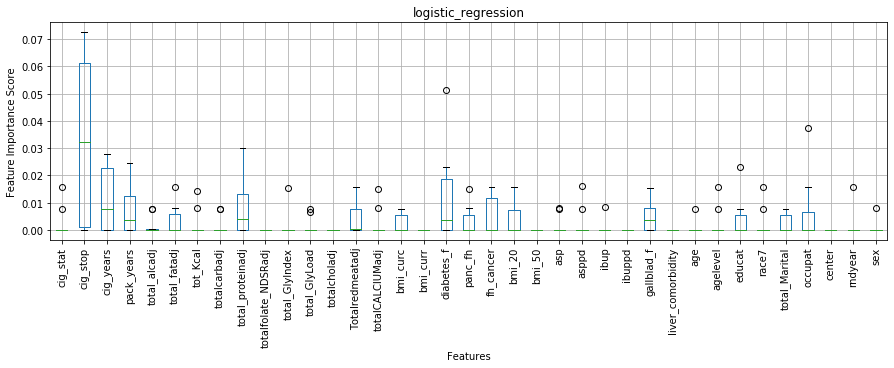

Text(0.5, 1.0, 'decision_tree')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x22214f72ac8>,
 <a list of 37 Text xticklabel objects>)

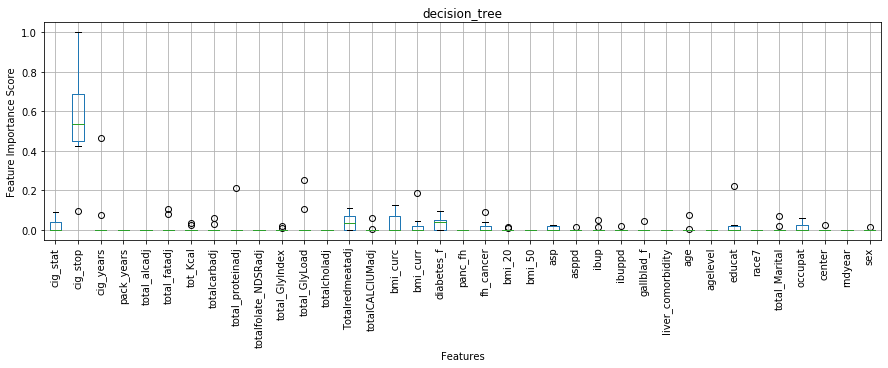

Text(0.5, 1.0, 'random_forest')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x2220ed39d88>,
 <a list of 37 Text xticklabel objects>)

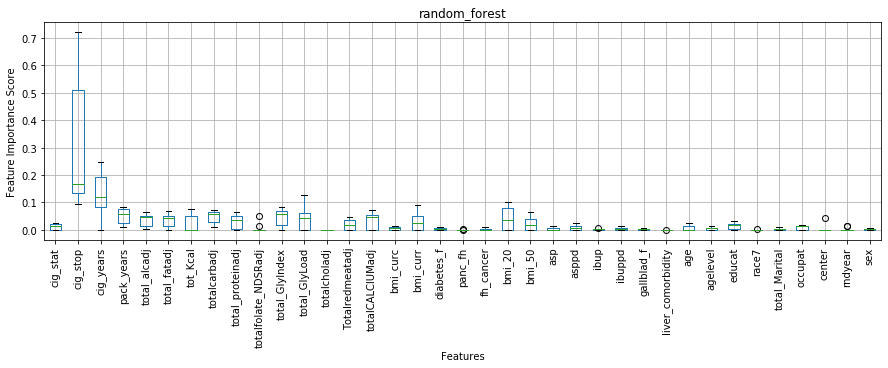

Text(0.5, 1.0, 'naive_bayes')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x22218452d08>,
 <a list of 37 Text xticklabel objects>)

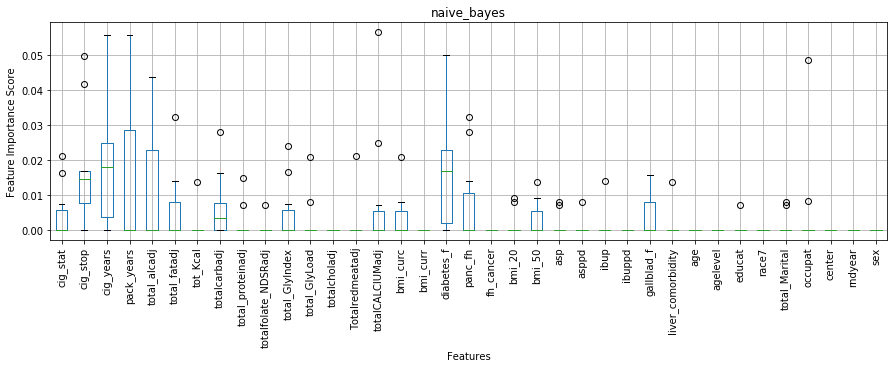

Text(0.5, 1.0, 'XGB')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x22218ada108>,
 <a list of 37 Text xticklabel objects>)

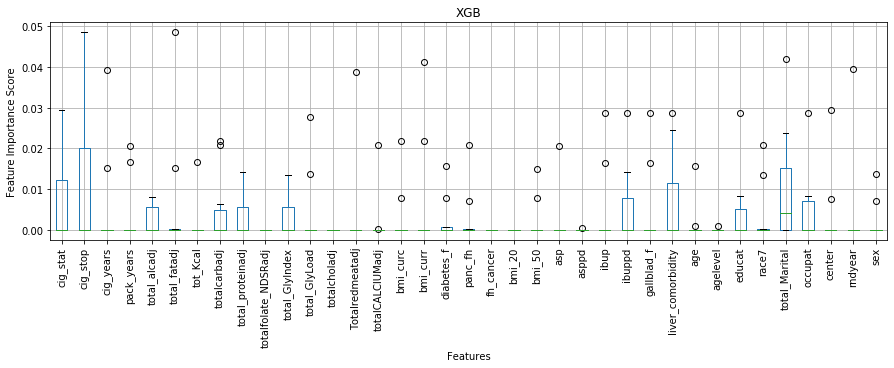

Text(0.5, 1.0, 'LGB')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x22219cb0f48>,
 <a list of 37 Text xticklabel objects>)

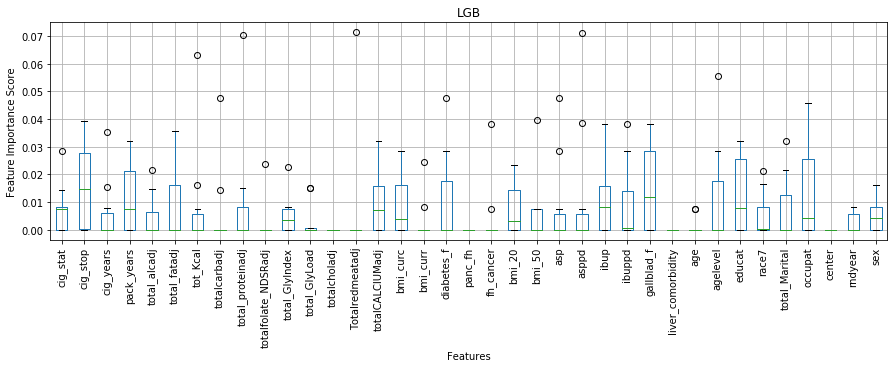

Text(0.5, 1.0, 'SVM')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x222144b2f08>,
 <a list of 37 Text xticklabel objects>)

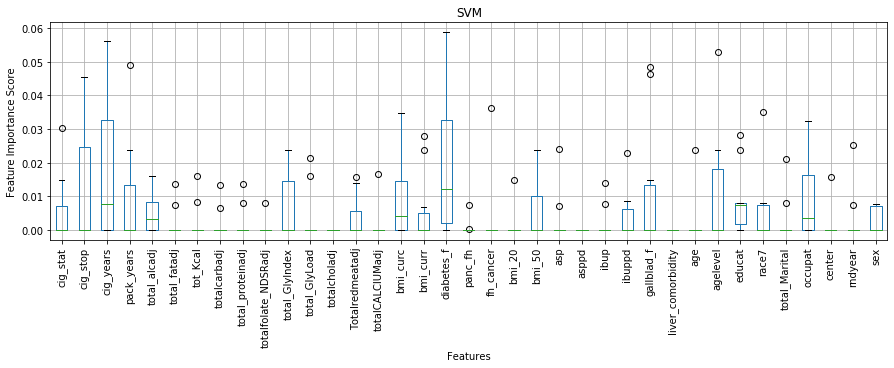

Text(0.5, 1.0, 'ANN')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x22218a544c8>,
 <a list of 37 Text xticklabel objects>)

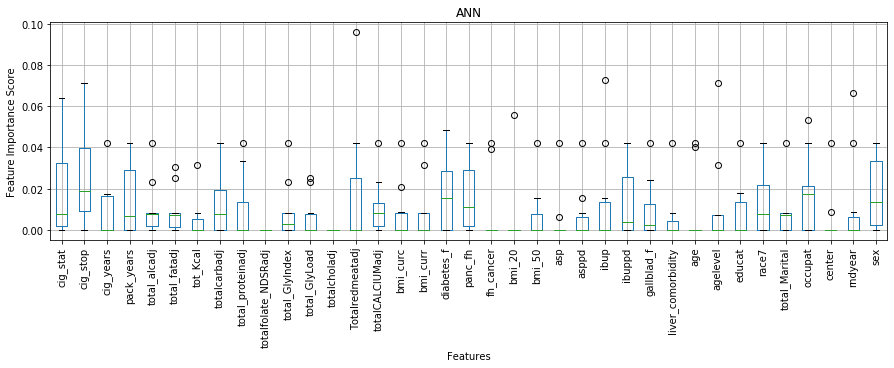

Text(0.5, 1.0, 'LCS')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x2221923f788>,
 <a list of 37 Text xticklabel objects>)

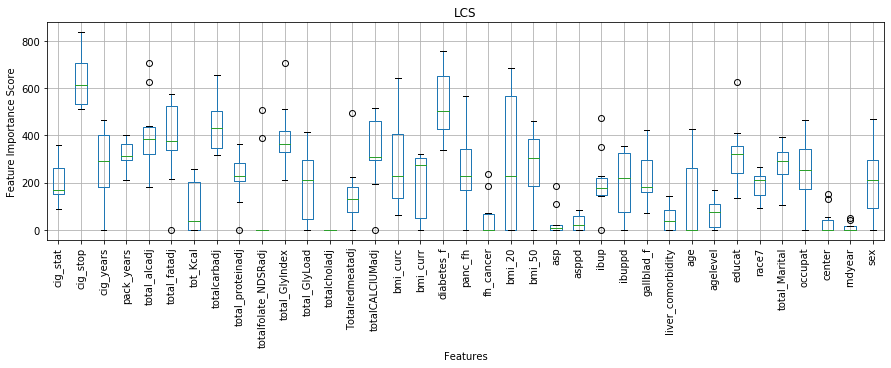

Text(0.5, 1.0, 'LCS_QRF')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x222199ba348>,
 <a list of 37 Text xticklabel objects>)

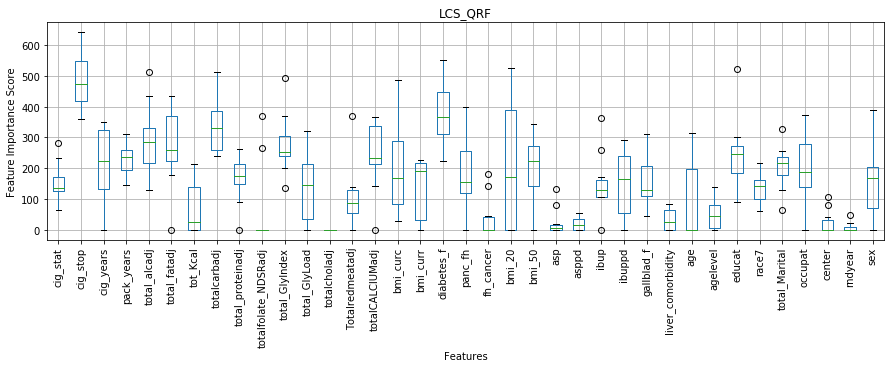

In [83]:
counter = 0
for df in fi_df_list:
    fig = plt.figure(figsize=(15,4))
    boxplot = df.boxplot(rot=90)
    plt.title(algorithmsToRun[counter])
    plt.ylabel('Feature Importance Score')
    plt.xlabel('Features')
    plt.xticks(np.arange(1,len(printfeatureNames)+1), printfeatureNames,rotation='vertical')
    plt.savefig((wd_path+output_folder+'/'+algorithmsToRun[counter]+'_boxplot_' + data_name), bbox_inches = "tight")
    plt.show()

    counter += 1

### Create Normalized dataframes with feature viz subsets

In [84]:
featuresToViz

feature_indexToViz = []
for i in featuresToViz:
    feature_indexToViz.append(all_feature_list.index(i))
feature_indexToViz

#Preserve features in original dataset order for consistency
top_fi_ave_norm_list = []
for i in range(len(algorithmsToRun)):
    tempList = []
    for j in range(len(fi_ave_norm_list[i])):
        if j in feature_indexToViz:
            tempList.append(fi_ave_norm_list[i][j])
    top_fi_ave_norm_list.append(tempList)

#Create feature name list in propper order
all_feature_listToViz = []
for j in (all_feature_list):
    if j in featuresToViz:
        all_feature_listToViz.append(j)
all_feature_listToViz

['cig_stop',
 'diabetes_f',
 'cig_years',
 'pack_years',
 'occupat',
 'gallblad_f',
 'totalcarbadj',
 'total_fatadj',
 'total_alcadj',
 'educat',
 'totalCALCIUMadj',
 'cig_stat',
 'total_GlyIndex',
 'bmi_curc',
 'total_Marital',
 'total_proteinadj',
 'Totalredmeatadj',
 'ibup',
 'ibuppd',
 'bmi_50']

[1, 17, 2, 3, 33, 26, 7, 5, 4, 30, 14, 0, 10, 15, 32, 8, 13, 24, 25, 21]

['cig_stat',
 'cig_stop',
 'cig_years',
 'pack_years',
 'total_alcadj',
 'total_fatadj',
 'totalcarbadj',
 'total_proteinadj',
 'total_GlyIndex',
 'Totalredmeatadj',
 'totalCALCIUMadj',
 'bmi_curc',
 'diabetes_f',
 'bmi_50',
 'ibup',
 'ibuppd',
 'gallblad_f',
 'educat',
 'total_Marital',
 'occupat']

In [85]:
def compound_FI_plot(fi_list,algorithmsToRun,algColors,all_feature_listToViz,figName):
    
    # y-axis in bold
    rc('font', weight='bold', size=16)
    
    # The position of the bars on the x-axis
    r = all_feature_listToViz
    barWidth = 0.75
    plt.figure(figsize=(figx,figy))
            
    lines = None
    if len(algorithmsToRun) == 1:
        print("Plotting with 1 algorithm.")
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        lines = (p1[0])
        
    elif len(algorithmsToRun) == 2:
        print("Plotting with 2 algorithms.")
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0])
        
    elif len(algorithmsToRun) == 3:
        print("Plotting with 3 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0])
        
    elif len(algorithmsToRun) == 4:
        print("Plotting with 4 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0])
        
    elif len(algorithmsToRun) == 5:
        print("Plotting with 5 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0])
        
    elif len(algorithmsToRun) == 6:
        print("Plotting with 6 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0])
        
    elif len(algorithmsToRun) == 7:
        print("Plotting with 7 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0])

    elif len(algorithmsToRun) == 8:
        print("Plotting with 8 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0])
        
    elif len(algorithmsToRun) == 9:
        print("Plotting with 9 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        bottom9 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        p9 = plt.bar(r, fi_list[8], bottom=bottom9, color=algColors[8], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0]) 

    elif len(algorithmsToRun) == 10:
        print("Plotting with 10 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        bottom9 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7])]
        bottom10 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7], fi_list[8])]

        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        p9 = plt.bar(r, fi_list[8], bottom=bottom9, color=algColors[8], edgecolor='white', width=barWidth)
        p10 = plt.bar(r, fi_list[9], bottom=bottom10, color=algColors[9], edgecolor='white', width=barWidth)

        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0],p10[0]) 
        
    # Custom X axis
    plt.xticks(np.arange(len(all_feature_listToViz)), all_feature_listToViz,rotation='vertical')
    plt.xlabel("Feature", fontsize=20)
    plt.ylabel("Normalized Feature Importance", fontsize=20)
    plt.legend(lines, methodsKey, loc=0,fontsize=16)
    plt.savefig(wd_path+output_folder+'/Compare_FI_'+figName+'_'+data_name, bbox_inches = 'tight')
    # Show graphic
    plt.show()

## Compound Feature Importance Plot (Normalized only)

Plotting with 10 algorithms.


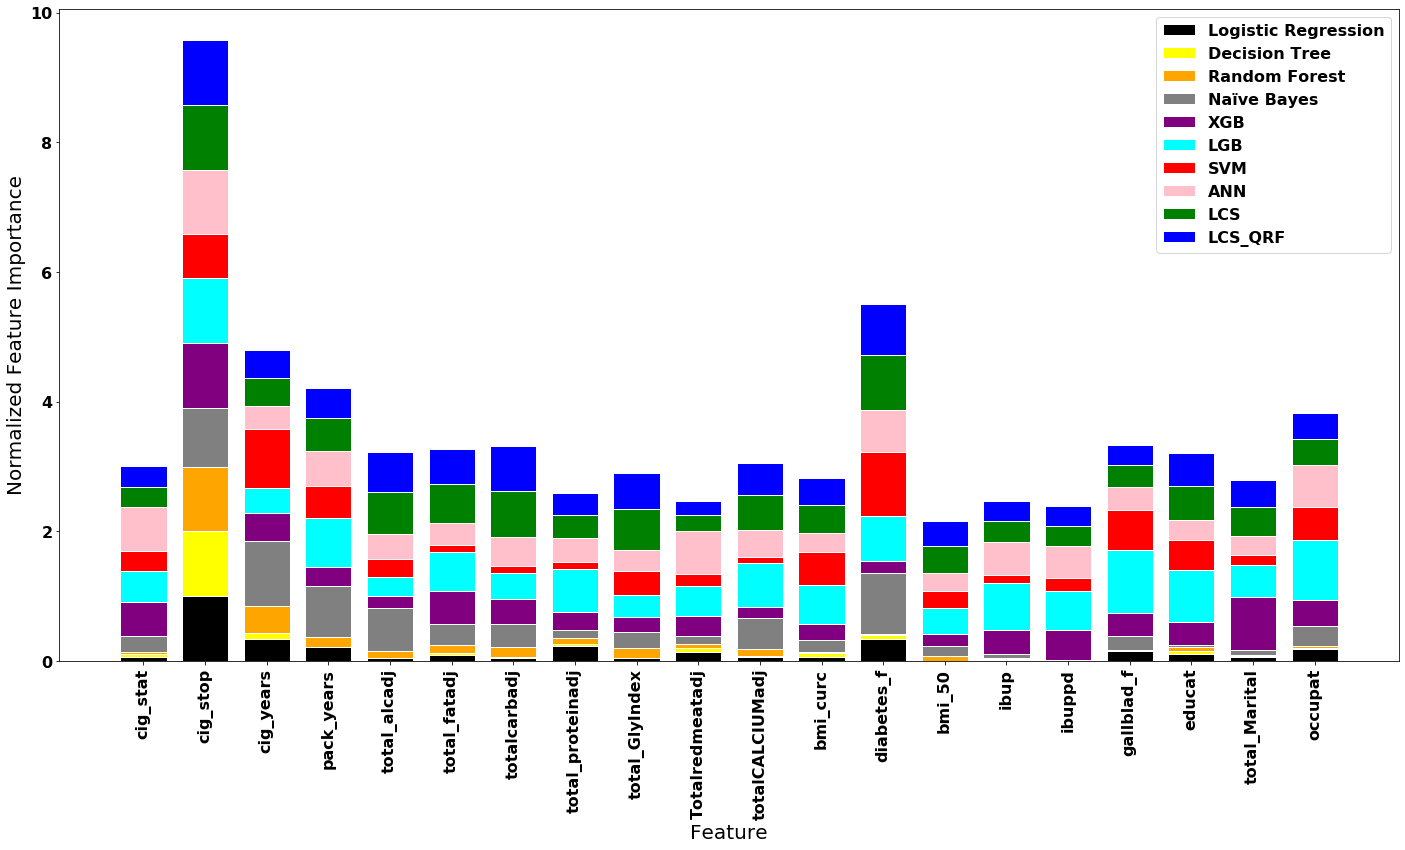

In [86]:
compound_FI_plot(top_fi_ave_norm_list,algorithmsToRun,algColors,all_feature_listToViz,'Norm')

##  Fraction Adjustment of Normalized Feature importances
- Each scores from each algorithm divided by sum of all scores

In [87]:
fracLists = []

for each in top_fi_ave_norm_list:
    fracList = []
    for i in range(len(each)):
        fracList.append((each[i]/(sum(each))))
    fracLists.append(fracList)

## Compound Feature Importance Plot (Normalized + Fraction Adjustment)

Plotting with 10 algorithms.


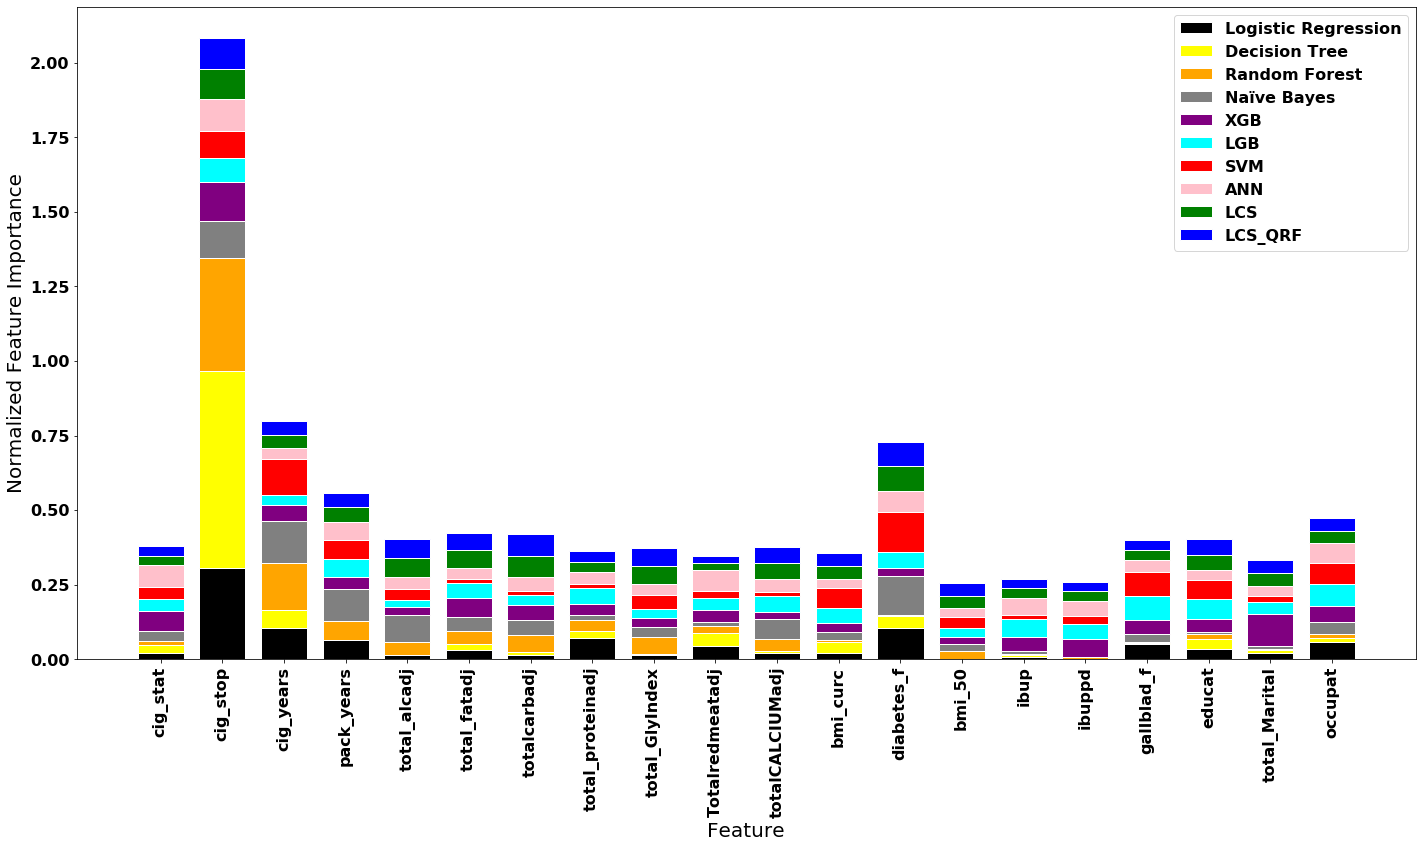

In [88]:
compound_FI_plot(fracLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Frac')

##  Performance Weighting of Normalized Feature importances

In [89]:
#Prepare weights
weights = []

# replace all balanced accuraces <=.5 with 0
for i in range(len(ave_metric_list)):
    if ave_metric_list[i] <= .5:
        ave_metric_list[i] = 0

# normalize balanced accuracies
for i in range(len(ave_metric_list)):
    if ave_metric_list[i] == 0:
        weights.append(0)
    else:
        weights.append((ave_metric_list[i]-0.5)/0.5)
        
        
# Weight normalized feature importances
weightedLists = []

for i in range(len(top_fi_ave_norm_list)):
    weightList = np.multiply(weights[i],top_fi_ave_norm_list[i]).tolist()
    weightedLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Perf. Weight Adjustment)

Plotting with 10 algorithms.


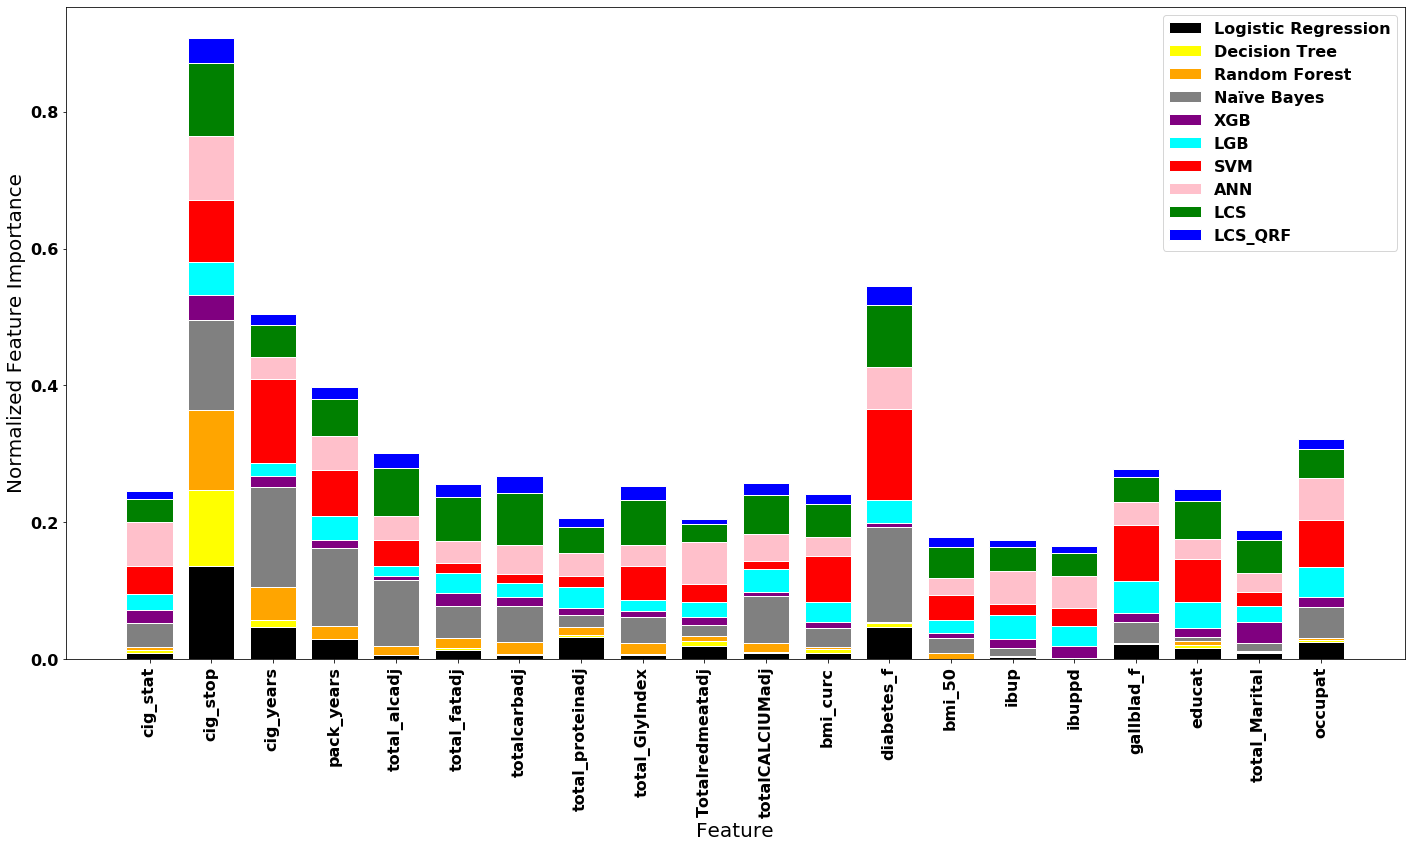

In [90]:
compound_FI_plot(weightedLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Weight')

##  Performance Weighting of Fract. Adj. and Normalized Feature importances

In [91]:
# Weight normalized feature importances
weightedFracLists = []

for i in range(len(fracLists)):
    weightList = np.multiply(weights[i],fracLists[i]).tolist()
    weightedFracLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Frac. + Perf. Weight Adjustment)

Plotting with 10 algorithms.


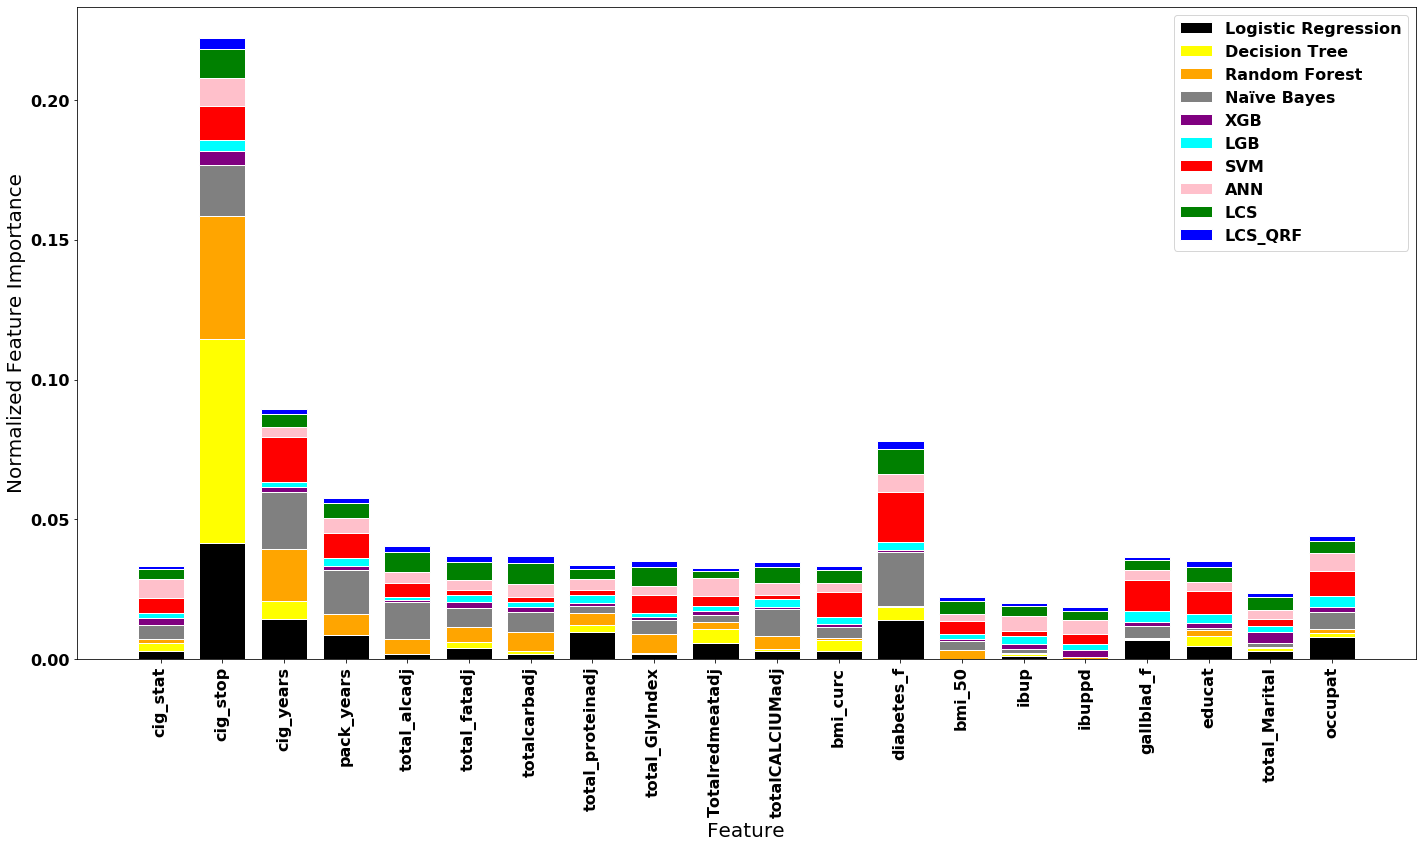

In [92]:
compound_FI_plot(weightedFracLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Frac_Weight')

# Runtime Report

In [93]:
notebook_elapsed_time = time.time() - notebook_start_time
print('Pipeline Run Time: '+ str(notebook_elapsed_time))
run_time_dict['pipeline'] = notebook_elapsed_time
print(run_time_dict)

Pipeline Run Time: 16742.56901884079
{'mutual_information': 2.1562607288360596, 'multisurf': 169.15310287475586, 'logistic_regression': 122.38004541397095, 'decision_tree': 110.0914626121521, 'random_forest': 1552.6087908744812, 'naive_bayes': 1.7603187561035156, 'XGB': 1047.6246118545532, 'LGB': 438.0280499458313, 'SVM': 2801.1137437820435, 'ANN': 1360.6948790550232, 'LCS': 9105.083720207214, 'pipeline': 16742.56901884079}
